# IT5306 - Distributed Computing Concepts for AI
  ## Assignment 01 - Analysis of a Data set using PySpark
  **239216U - A.M.K.N.K.Jayawardhana**

---
  
  ### Selected Dataset:
  **"Global Demographic Dynamics: Population Trends"** Data set
  downloaded from https://www.kaggle.com/datasets/programmerrdai/global-demographic-dynamics-population-trends/data?select=US_PopAgeStruct_20230713030811.csv

  origin: https://unctadstat.unctad.org/datacentre/

  File : US_PopAgeStruct_20230713030811.csv - 121mb

 **Theme**: Population and labour force

 **Description**:

This table provides estimates of population by gender and age-group, from 1950 to 2021 and projections from 2022 to 2050 (medium fertility variant), expressed in thousands.

 **Sources**:

UN DESA Population Division, World Population Prospects 2022

 **Notes**:

De facto population in a country, area or region as of 1 July of the indicated year.  

 **Dimensions**:
SERIES,
AGE CLASS,
ECONOMY,
YEAR,
SEX

**Indicators**:
Absolute value,
Absolute value in hundred,
Absolute value in thousands,
Absolute value in millions,
Absolute value in billions

# Table of Content

1.   Basic Setup
    * install pyspark  
    * Import libraries
    * Configure Spark and Initialize Spark Session
    *  Mount Google Drive wiht previously uploaded dataset or upload datase file
    *  Create and Display the Spark DataFrame

2.   Understand the data set
    * Describe data set
    * Display Schema
    * check no. of partions
    * Data cleaning
    * Describe data set
    * check no. of partions
    * check for removed unique values
    * Filter the DataFrame for entries where 'Absolute value in thousands' is 0.0

3.  Analysing the world
    * population over the years
        * total population over the years
        * total male & female population over the years

    * population Pyramids
      * total population by age in 1950/ 2021 / 2050
      * total male population by age in 1950/ 2021 / 2050
      * total female population  by age in 1950/ 2021 / 2050
      * combined population Pyramids in 1950/ 2021 / 2050

    * Gender difference
      * variation of total population by age group over the year
      * variation of male population by age group over the year
      * variation of femal population by age group over the year

    * Aging
      * calculate population above 60 years - get percentage by total population and add to graph

    * Workforce
      * calculate population between between 20 and 60 years  - pet percentage by total population and add to graph

    * Children
      * calculate population below 20 years - get percentage by total population and add to graph

4.   Analysing Countries    
    * Filter countries and other Economies

    * get total population by country for year 1950/ 2021 / 2050
    * Plot 10 highest total population by country for year 1950/ 2021 / 2050
    * Plot 10 lowest total population by country for year 1950/ 2021 / 2050

    * calculate population growth rates by countries
    * plot 10 countries with highest and lowest growth rates
    *Analysing Japan /Qatar /Sri Lanka

5.   Understand the non-country economies

6.  Predicting total population using Linear Regression


# 1. Basic Setup

In [1]:
#install pyspark
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless &> /dev/null

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=f5ae826692fda83b96cd60e7988fe688df81301feabf44d2dd9ab179a9142e82
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
#Import libraries
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.functions import col, year, avg, format_number, lit, round, sum as spark_sum
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import pandas as pd


In [3]:
# Initialize Spark Session
spark = SparkSession.builder.appName("Population Trends Analysis").getOrCreate()

In [4]:
#upload dataset file
#from google.colab import files

#uploaded = files.upload()
#filename = 'US_PopAgeStruct_20230713030811.csv'


#df = spark.read.csv(filename,header=True, inferSchema=True)


In [5]:
# Mount Google Drive
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
# Create and Display the Spark DataFrame
filepath = '/content/drive/MyDrive/Colab Notebooks/Distributed Computing Concepts for AI Assignment/US_PopAgeStruct_20230713030811.csv'

df_orig = spark.read.csv(filepath, header=True, inferSchema=True)
df_orig.show(5)

+----+-------+--------------------+---+----------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|Year|Economy|       Economy Label|Sex| Sex Label|AgeClass| AgeClass Label|Absolute value in thousands|Absolute value in thousands Footnote|Absolute value in thousands Missing value|
+----+-------+--------------------+---+----------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|1950|      1|Individual economies|  0|Both sexes|       0|All age classes|                       NULL|                                NULL|                           Not applicable|
|1950|      1|Individual economies|  0|Both sexes|       1|          [0-4]|                       NULL|                                NULL|                           Not applicable|
|1950|      1|Individual economies|  0|Both sexes|       2|          [5-9]|          

# 2. Understand the data set

## Understand Original Dataset

In [7]:
#Display Schema
df_orig.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Economy: integer (nullable = true)
 |-- Economy Label: string (nullable = true)
 |-- Sex: integer (nullable = true)
 |-- Sex Label: string (nullable = true)
 |-- AgeClass: integer (nullable = true)
 |-- AgeClass Label: string (nullable = true)
 |-- Absolute value in thousands: double (nullable = true)
 |-- Absolute value in thousands Footnote: string (nullable = true)
 |-- Absolute value in thousands Missing value: string (nullable = true)



In [8]:
# Describe the data set
df_orig.describe().show()

+-------+------------------+------------------+-------------+-----------------+----------+-----------------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|summary|              Year|           Economy|Economy Label|              Sex| Sex Label|         AgeClass| AgeClass Label|Absolute value in thousands|Absolute value in thousands Footnote|Absolute value in thousands Missing value|
+-------+------------------+------------------+-------------+-----------------+----------+-----------------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|  count|           2083686|           2083686|      2083686|          2083686|   2083686|          2083686|        2083686|                    1909151|                                   3|                                   174535|
|   mean|2000.0392448766272|1068.9245510120047|         NULL|           

In [9]:
# Check the number of partitions
print(f"Initial number of partitions: {df_orig.rdd.getNumPartitions()}")

Initial number of partitions: 2


In [10]:
df_orig.show(5)

+----+-------+--------------------+---+----------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|Year|Economy|       Economy Label|Sex| Sex Label|AgeClass| AgeClass Label|Absolute value in thousands|Absolute value in thousands Footnote|Absolute value in thousands Missing value|
+----+-------+--------------------+---+----------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|1950|      1|Individual economies|  0|Both sexes|       0|All age classes|                       NULL|                                NULL|                           Not applicable|
|1950|      1|Individual economies|  0|Both sexes|       1|          [0-4]|                       NULL|                                NULL|                           Not applicable|
|1950|      1|Individual economies|  0|Both sexes|       2|          [5-9]|          

## Clean Data and Understand Cleaned Dataset

In [11]:
# Data Cleaning
df_cleaned = df_orig.dropna(subset=['Absolute value in thousands'])

In [12]:
# Display the cleaned data
df_cleaned.show(5)

+----+-------+-------------+---+----------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|Year|Economy|Economy Label|Sex| Sex Label|AgeClass| AgeClass Label|Absolute value in thousands|Absolute value in thousands Footnote|Absolute value in thousands Missing value|
+----+-------+-------------+---+----------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|1950|      4|  Afghanistan|  0|Both sexes|       0|All age classes|                   7480.461|                                NULL|                                     NULL|
|1950|      4|  Afghanistan|  0|Both sexes|       1|          [0-4]|                   1248.282|                                NULL|                                     NULL|
|1950|      4|  Afghanistan|  0|Both sexes|       2|          [5-9]|                    966.211|                        

In [13]:
# Describe the cleaned data set
df_cleaned.describe().show()

+-------+------------------+-----------------+-------------+------------------+----------+------------------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|summary|              Year|          Economy|Economy Label|               Sex| Sex Label|          AgeClass| AgeClass Label|Absolute value in thousands|Absolute value in thousands Footnote|Absolute value in thousands Missing value|
+-------+------------------+-----------------+-------------+------------------+----------+------------------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|  count|           1909151|          1909151|      1909151|           1909151|   1909151|           1909151|        1909151|                    1909151|                                   3|                                        0|
|   mean|2001.2274890776057|1120.403789956897|         NULL|0.999947

In [14]:
# Check the number of partitions
print(f"Initial number of partitions: {df_cleaned.rdd.getNumPartitions()}")

Initial number of partitions: 2


Next check whether any unique values has been totally removed when dropping null values

In [15]:
# Get the list of column headings
# df_cleaned_columns = df_cleaned.columns

Columns = ["Economy", "Economy Label", "Sex", "Sex Label", "AgeClass", "AgeClass Label"]

# Function to print unique values for each column
def print_values(value):
    unique_values_orig = sorted(df_orig.select(value).distinct().rdd.flatMap(lambda x: x).collect())
    unique_values_cleaned = sorted(df_cleaned.select(value).distinct().rdd.flatMap(lambda x: x).collect())
    print("Unique values of ", value)
    print("Original:", len(unique_values_orig))
    print("Cleaned:", len(unique_values_cleaned))


# Collect the list of column headings to the driver and iterate over them
for column in Columns:
    print_values(column)


Unique values of  Economy
Original: 313
Cleaned: 312
Unique values of  Economy Label
Original: 313
Cleaned: 312
Unique values of  Sex
Original: 3
Cleaned: 3
Unique values of  Sex Label
Original: 3
Cleaned: 3
Unique values of  AgeClass
Original: 22
Cleaned: 22
Unique values of  AgeClass Label
Original: 22
Cleaned: 22


Here We understand there were 313 Economy Values, but after cleaning there is only 12. Next let's findout what has been removed.

In [16]:
# Get original economy Label list and cleaned economy Label list
df_orig_list = df_orig.select("Economy Label").distinct().rdd.flatMap(lambda x: x).collect()
df_clean_list = df_cleaned.select("Economy Label").distinct().rdd.flatMap(lambda x: x).collect()

# Create DataFrames from lists
df1 = spark.createDataFrame([(val,) for val in df_orig_list], ["value"])
df2 = spark.createDataFrame([(val,) for val in df_clean_list], ["value"])

# Perform left anti join operation to find values in df1 that are not in df2
missing_values_df = df1.join(df2, df1.value == df2.value, how='left_anti')

# Show the result
missing_values_df.show()


+--------------------+
|               value|
+--------------------+
|Individual economies|
+--------------------+



Here we understand that "Individual Economies" have been totally removed. Thus there are no data of "Individual Economies" in the cleaned dataset.

Next let's understand what are the unique values in Economy, Sex and Age

In [17]:
# Select only 'Sex' and 'Sex Label' columns
sex_df = df_cleaned.select('Sex', 'Sex Label')

# Drop duplicate rows to get unique combinations
unique_sex_df = sex_df.dropDuplicates()

# Sort the DataFrame by 'Sex'
sorted_unique_sex_df = unique_sex_df.orderBy('Sex')

# Show the resulting DataFrame
sorted_unique_sex_df.show()

+---+----------+
|Sex| Sex Label|
+---+----------+
|  0|Both sexes|
|  1|    Female|
|  2|      Male|
+---+----------+



In [18]:
# Select only 'AgeClass' and 'Age Label' columns
Age_df = df_cleaned.select('AgeClass', 'AgeClass Label')

# Drop duplicate rows to get unique combinations
unique_Age_df = Age_df.dropDuplicates()

# Sort the DataFrame by 'AgeClass'
sorted_unique_Age_df = unique_Age_df.orderBy('AgeClass')

# Show the resulting DataFrame
sorted_unique_Age_df.show(22)

+--------+---------------+
|AgeClass| AgeClass Label|
+--------+---------------+
|       0|All age classes|
|       1|          [0-4]|
|       2|          [5-9]|
|       3|        [10-14]|
|       4|        [15-19]|
|       5|        [20-24]|
|       6|        [25-29]|
|       7|        [30-34]|
|       8|        [35-39]|
|       9|        [40-44]|
|      10|        [45-49]|
|      11|        [50-54]|
|      12|        [55-59]|
|      13|        [60-64]|
|      14|        [65-69]|
|      15|        [70-74]|
|      16|        [75-79]|
|      17|        [80-84]|
|      18|        [85-89]|
|      19|        [90-94]|
|      20|        [95-99]|
|      21|         [100+]|
+--------+---------------+



In [19]:
# Select only 'Economy' and 'Economy Label' columns
economy_df = df_cleaned.select('Economy', 'Economy Label')

# Drop duplicate rows to get unique combinations
unique_economy_df = economy_df.dropDuplicates()

# Sort the DataFrame by 'Economy'
sorted_unique_economy_df = unique_economy_df.orderBy('Economy')

# Show the resulting DataFrame
sorted_unique_economy_df.show()


+-------+-------------------+
|Economy|      Economy Label|
+-------+-------------------+
|      0|              World|
|      4|        Afghanistan|
|      8|            Albania|
|     12|            Algeria|
|     16|     American Samoa|
|     20|            Andorra|
|     24|             Angola|
|     28|Antigua and Barbuda|
|     31|         Azerbaijan|
|     32|          Argentina|
|     36|          Australia|
|     40|            Austria|
|     44|            Bahamas|
|     48|            Bahrain|
|     50|         Bangladesh|
|     51|            Armenia|
|     52|           Barbados|
|     56|            Belgium|
|     60|            Bermuda|
|     64|             Bhutan|
+-------+-------------------+
only showing top 20 rows



Next in the description we can see there are only three values "Absolute value in thousands Footnote". Let's check what are those and to which economy, sex and age they belong to.

In [20]:
# Filter the DataFrame for Footnote entries
footnote_entries_df = df_cleaned.dropna(subset=['Absolute value in thousands Footnote'])

# Show the filtered DataFrame
footnote_entries_df.show(truncate=False)

+----+-------+-------------+---+----------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|Year|Economy|Economy Label|Sex|Sex Label |AgeClass|AgeClass Label |Absolute value in thousands|Absolute value in thousands Footnote|Absolute value in thousands Missing value|
+----+-------+-------------+---+----------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|1975|196    |Cyprus       |0  |Both sexes|0       |All age classes|501.774                    |Break                               |NULL                                     |
|2015|804    |Ukraine      |0  |Both sexes|0       |All age classes|44982.564                  |Break                               |NULL                                     |
|2022|804    |Ukraine      |0  |Both sexes|0       |All age classes|39701.739                  |Break                   

In the description we can see there are 0.0 values for "Absolute value in thousands". Let's check what are those and to which economy, sex and age they belong to.

In [21]:
# Filter the DataFrame for entries where 'Absolute value in thousands' is 0.0
zero_entries_df = df_cleaned.filter(df_cleaned["Absolute value in thousands"] == 0.0)

# Show the filtered DataFrame
zero_entries_df.show(5, truncate=False)

zero_entries_df.describe().show()


+----+-------+--------------+---+----------+--------+--------------+---------------------------+------------------------------------+-----------------------------------------+
|Year|Economy|Economy Label |Sex|Sex Label |AgeClass|AgeClass Label|Absolute value in thousands|Absolute value in thousands Footnote|Absolute value in thousands Missing value|
+----+-------+--------------+---+----------+--------+--------------+---------------------------+------------------------------------+-----------------------------------------+
|1950|4      |Afghanistan   |0  |Both sexes|21      |[100+]        |0.0                        |NULL                                |NULL                                     |
|1950|4      |Afghanistan   |2  |Male      |21      |[100+]        |0.0                        |NULL                                |NULL                                     |
|1950|4      |Afghanistan   |1  |Female    |21      |[100+]        |0.0                        |NULL                    

Here we can see most of 0.0 values belong to AgeClass close to 100. Which means there can be no older people  in some countries for some years. Let's check all the age classes .

In [22]:
# Select only 'Sex' and 'AgeClass Label' columns
temp_df = zero_entries_df.select('Sex', 'AgeClass Label', 'Absolute value in thousands')

# Drop duplicate rows to get unique combinations
unique_temp_df = temp_df.dropDuplicates()

# Sort the DataFrame by 'AgeClass Label'
sorted_unique_temp_df = unique_temp_df.orderBy('AgeClass Label')

# Show the resulting DataFrame
sorted_unique_temp_df.show()

+---+--------------+---------------------------+
|Sex|AgeClass Label|Absolute value in thousands|
+---+--------------+---------------------------+
|  1|        [100+]|                        0.0|
|  0|        [100+]|                        0.0|
|  2|        [100+]|                        0.0|
|  2|       [80-84]|                        0.0|
|  0|       [85-89]|                        0.0|
|  2|       [85-89]|                        0.0|
|  1|       [85-89]|                        0.0|
|  2|       [90-94]|                        0.0|
|  0|       [90-94]|                        0.0|
|  1|       [90-94]|                        0.0|
|  0|       [95-99]|                        0.0|
|  1|       [95-99]|                        0.0|
|  2|       [95-99]|                        0.0|
+---+--------------+---------------------------+



For ageClass [80-84] only males are not available. For [85-89], [90-94, [95-99],[100+] people of all classes can be zero.


Next, check the count of 0.0 entries for each age class

In [23]:
temp_df.groupBy('AgeClass Label').count().show()

+--------------+-----+
|AgeClass Label|count|
+--------------+-----+
|       [90-94]| 1386|
|       [95-99]| 5537|
|       [80-84]|    6|
|        [100+]|17166|
|       [85-89]|   87|
+--------------+-----+



# Analysing the world

## total population in the world over the years

+----+-------+-------------+---+----------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|Year|Economy|Economy Label|Sex|Sex Label |AgeClass|AgeClass Label |Absolute value in thousands|Absolute value in thousands Footnote|Absolute value in thousands Missing value|
+----+-------+-------------+---+----------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|1950|0      |World        |0  |Both sexes|0       |All age classes|2499322.166                |NULL                                |NULL                                     |
|1951|0      |World        |0  |Both sexes|0       |All age classes|2543130.378                |NULL                                |NULL                                     |
|1952|0      |World        |0  |Both sexes|0       |All age classes|2590270.906                |NULL                    

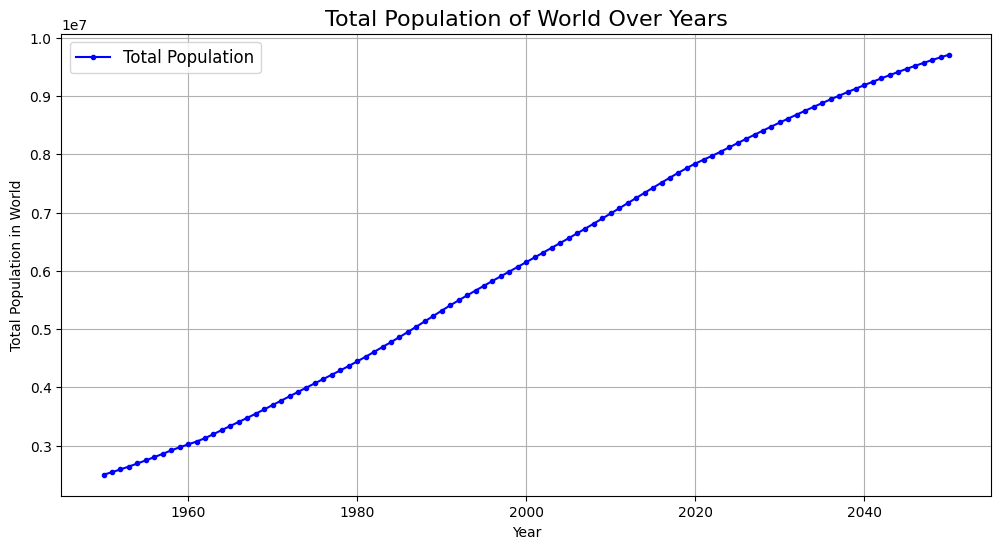

In [24]:
world_df = df_cleaned.filter((df_cleaned["Economy Label"] == "World"))

world_all_df = world_df.filter((world_df['AgeClass Label'] == 'All age classes') & (world_df['Sex Label'] == 'Both sexes'))
world_all_df.show(5,truncate=False)
world_all_df.describe().show()

# Convert to Pandas DataFrame for visualization
world_all_pd = world_all_df.toPandas()

# Plot total population over years
plt.figure(figsize=(12, 6))
plt.plot(world_all_pd["Year"], world_all_pd["Absolute value in thousands"], marker='.', linestyle='-', color='blue', label='Total Population')
plt.xlabel("Year")
plt.ylabel("Total Population in World")
plt.title("Total Population of World Over Years", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

plt.show()

## total male and female population over the years


Male Population

+----+-------+-------------+---+---------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|Year|Economy|Economy Label|Sex|Sex Label|AgeClass|AgeClass Label |Absolute value in thousands|Absolute value in thousands Footnote|Absolute value in thousands Missing value|
+----+-------+-------------+---+---------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|1950|0      |World        |2  |Male     |0       |All age classes|1245362.962                |NULL                                |NULL                                     |
|1951|0      |World        |2  |Male     |0       |All age classes|1267473.187                |NULL                                |NULL                                     |
|1952|0      |World        |2  |Male     |0       |All age classes|1291399.978                |NULL        

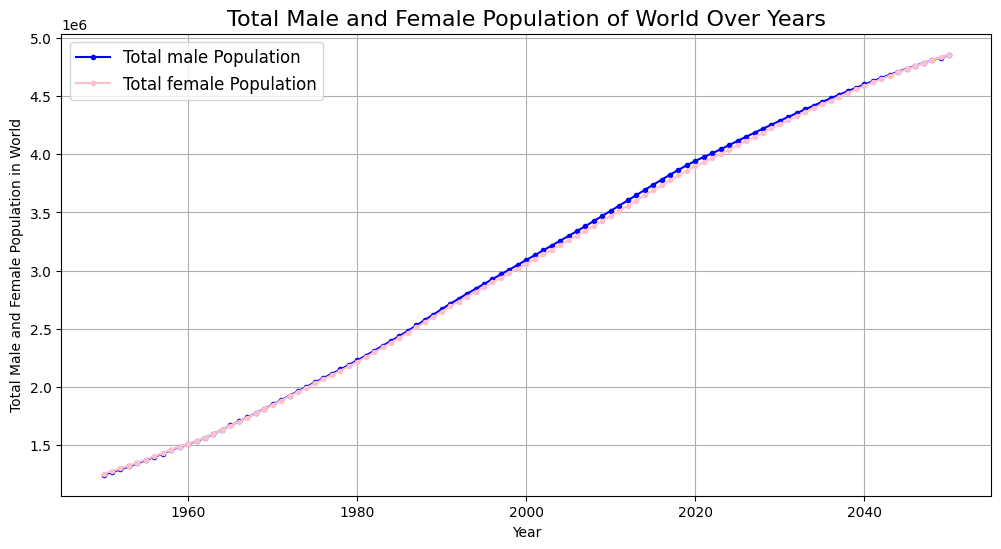

In [25]:
world_male_df = world_df[(world_df['AgeClass Label'] == 'All age classes') & (world_df['Sex Label'] == 'Male')]
print('\nMale Population\n')
world_male_df.show(5,truncate=False)
world_male_df.describe().show()

world_female_df = world_df[(world_df['AgeClass Label'] == 'All age classes') & (world_df['Sex Label'] == 'Female')]
print('\nFemale Population\n')
world_female_df.show(5,truncate=False)
world_female_df.describe().show()

# Convert to Pandas DataFrame for visualization
world_male_pd = world_male_df.toPandas()
world_female_pd = world_female_df.toPandas()

# Plot total population over years
plt.figure(figsize=(12, 6))
plt.plot(world_male_pd["Year"], world_male_pd["Absolute value in thousands"], marker='.', linestyle='-', color='blue', label='Total male Population')
plt.plot(world_female_pd["Year"], world_female_pd["Absolute value in thousands"], marker='.', linestyle='-', color='pink', label='Total female Population')
plt.xlabel("Year")
plt.ylabel("Total Male and Female Population in World")
plt.title("Total Male and Female Population of World Over Years", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

plt.show()

## population Pyramids

* total population by age in 1950/ 2021 / 2050
* population pyramids in 1950/ 2021 / 2050
* combined male and female population Pyramids in 1950/ 2021 / 2050

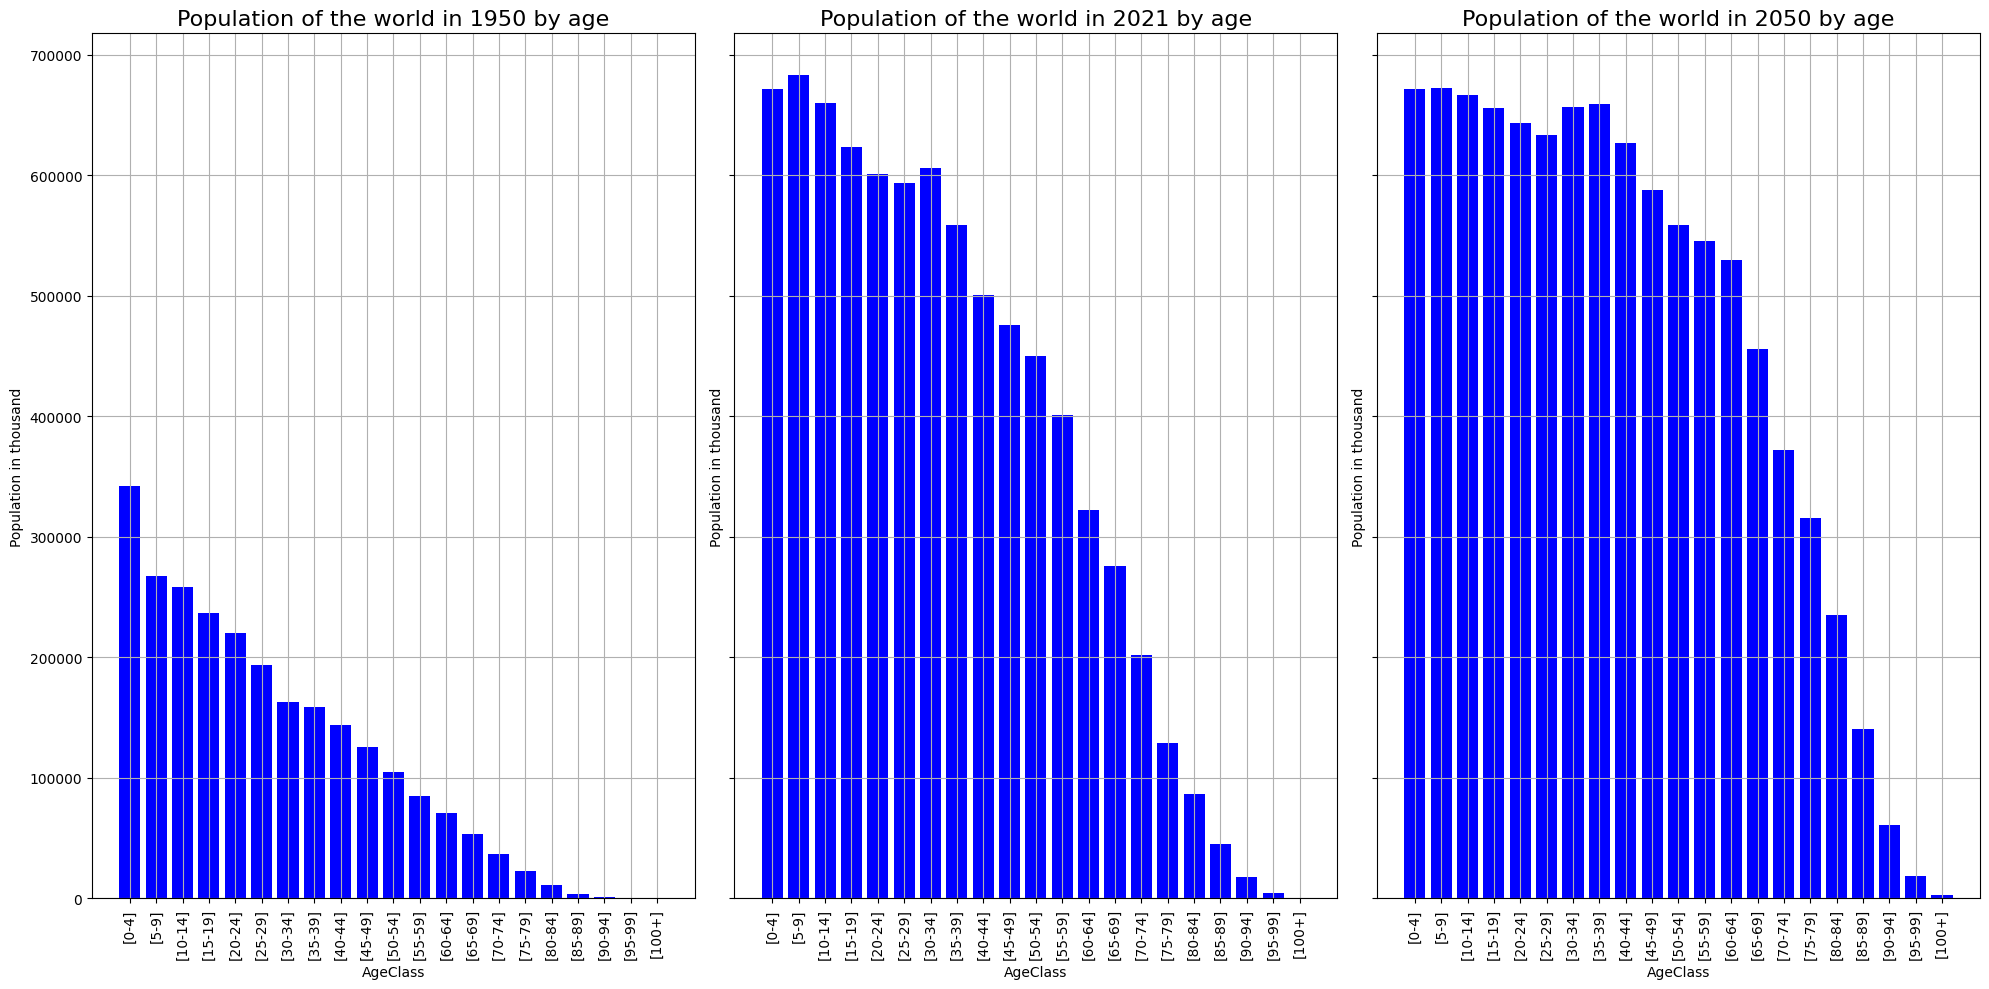

In [26]:
world_all_agewise_1950_df = world_df.filter((world_df['Year'] == '1950') & (world_df['Sex Label'] == 'Both sexes') & (world_df['AgeClass'] != '0'))
world_all_agewise_2021_df = world_df.filter((world_df['Year'] == '2021') & (world_df['Sex Label'] == 'Both sexes') & (world_df['AgeClass'] != '0'))
world_all_agewise_2050_df = world_df.filter((world_df['Year'] == '2050') & (world_df['Sex Label'] == 'Both sexes') & (world_df['AgeClass'] != '0'))

# Convert to Pandas DataFrame for visualization
world_all_agewise_1950_pd = world_all_agewise_1950_df.toPandas()
world_all_agewise_2021_pd = world_all_agewise_2021_df.toPandas()
world_all_agewise_2050_pd = world_all_agewise_2050_df.toPandas()

# Plotting side by side
fig, axes = plt.subplots(1, 3, figsize=(20, 10), sharey=True)

# Plot total population over years
#plt.figure(figsize=(12, 6))

# Plot for 1950
axes[0].bar(world_all_agewise_1950_pd["AgeClass Label"], world_all_agewise_1950_pd["Absolute value in thousands"],  color='blue')
axes[0].set_xlabel("AgeClass")
axes[0].set_ylabel("Population in thousand")
axes[0].set_title("Population of the world in 1950 by age", fontsize=16)
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=90)  # Rotate labels

# Plot for 2021
axes[1].bar(world_all_agewise_2021_pd["AgeClass Label"], world_all_agewise_2021_pd["Absolute value in thousands"],  color='blue')
axes[1].set_xlabel("AgeClass")
axes[1].set_ylabel("Population in thousand")
axes[1].set_title("Population of the world in 2021 by age", fontsize=16)
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=90)  # Rotate labels

# Plot for 2050
axes[2].bar(world_all_agewise_2050_pd["AgeClass Label"], world_all_agewise_2050_pd["Absolute value in thousands"],  color='blue')
axes[2].set_xlabel("AgeClass")
axes[2].set_ylabel("Population in thousand")
axes[2].set_title("Population of the world in 2050 by age", fontsize=16)
axes[2].grid(True)
axes[2].tick_params(axis='x', rotation=90)  # Rotate labels

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

* survival rate of infants is high
* Longivity of people has increased

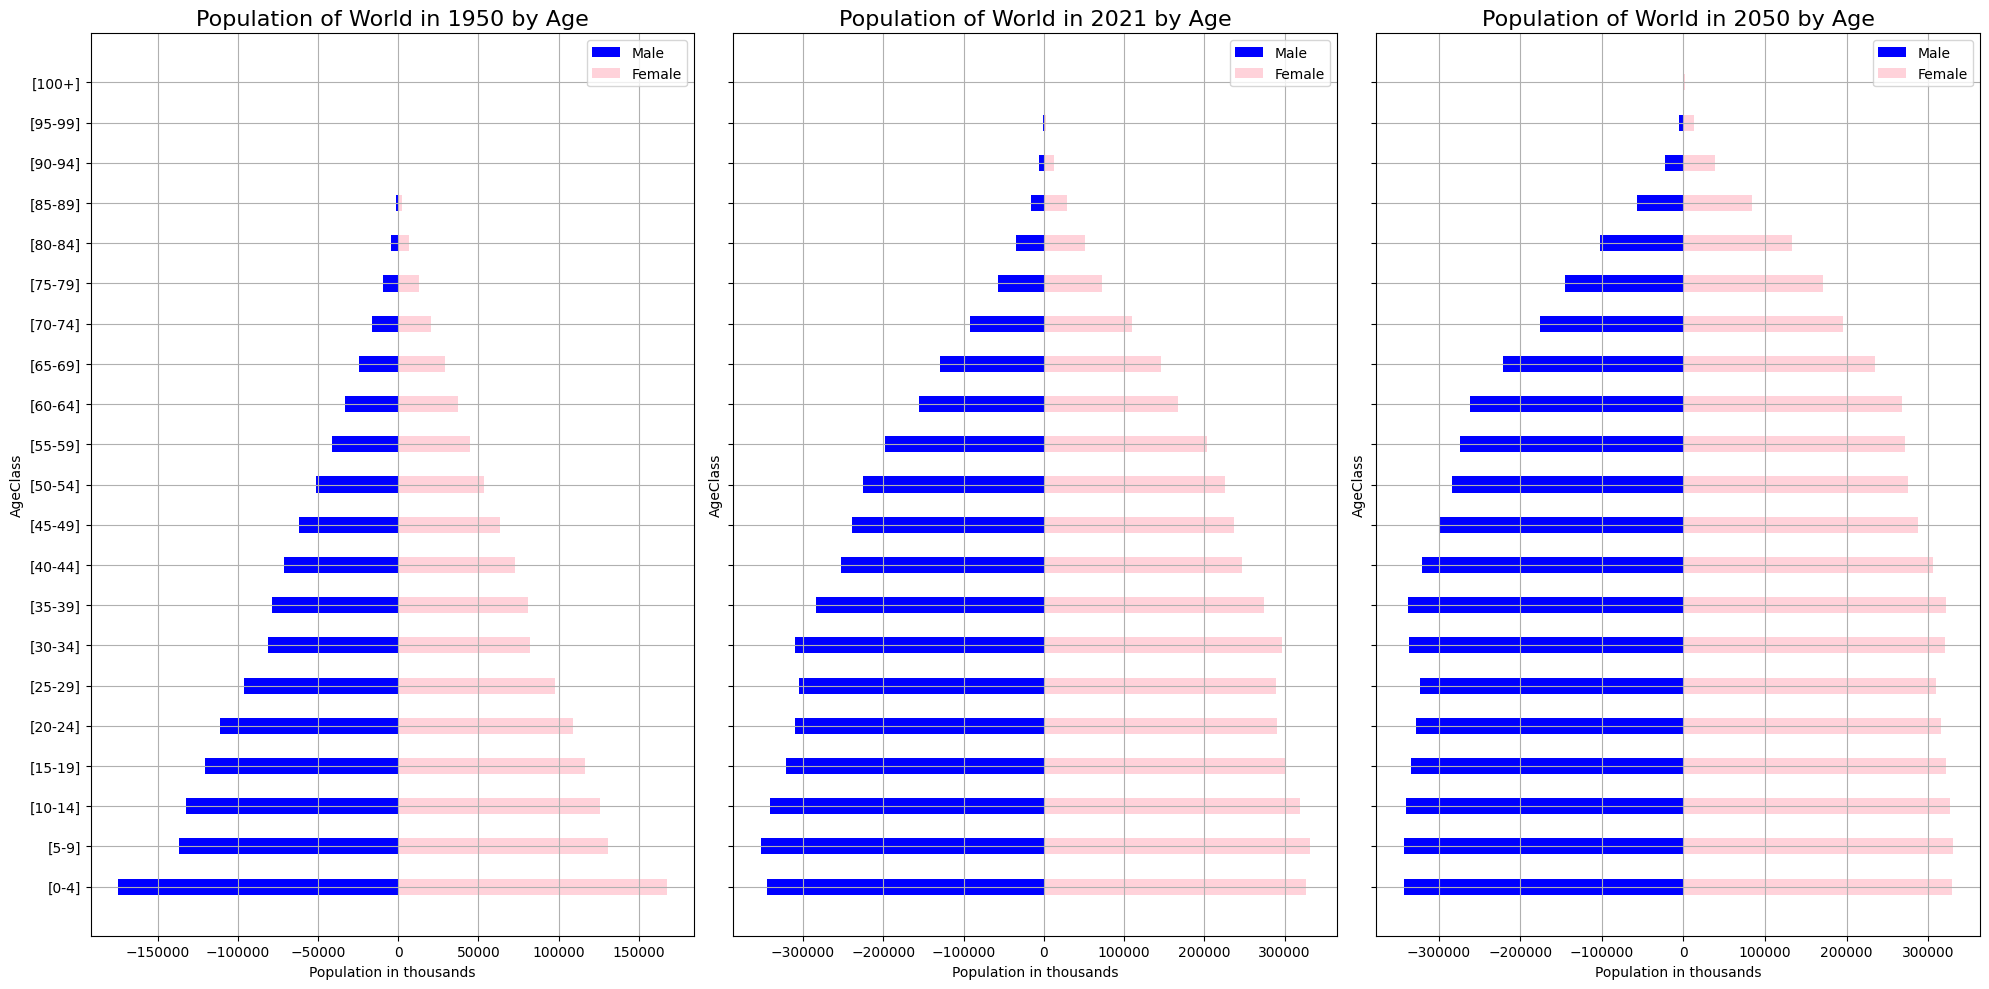

In [27]:
# World Male Population by Age
world_male_agewise_1950_df = world_df.filter((world_df['Year'] == '1950') & (world_df['Sex Label'] == 'Male') & (world_df['AgeClass'] != '0'))
world_male_agewise_2021_df = world_df.filter((world_df['Year'] == '2021') & (world_df['Sex Label'] == 'Male') & (world_df['AgeClass'] != '0'))
world_male_agewise_2050_df = world_df.filter((world_df['Year'] == '2050') & (world_df['Sex Label'] == 'Male') & (world_df['AgeClass'] != '0'))

# World Female Population by Age
world_female_agewise_1950_df = world_df.filter((world_df['Year'] == '1950') & (world_df['Sex Label'] == 'Female') & (world_df['AgeClass'] != '0'))
world_female_agewise_2021_df = world_df.filter((world_df['Year'] == '2021') & (world_df['Sex Label'] == 'Female') & (world_df['AgeClass'] != '0'))
world_female_agewise_2050_df = world_df.filter((world_df['Year'] == '2050') & (world_df['Sex Label'] == 'Female') & (world_df['AgeClass'] != '0'))

# Convert to Pandas DataFrame for visualization
world_male_agewise_1950_pd = world_male_agewise_1950_df.toPandas()
world_male_agewise_2021_pd = world_male_agewise_2021_df.toPandas()
world_male_agewise_2050_pd = world_male_agewise_2050_df.toPandas()

world_female_agewise_1950_pd = world_female_agewise_1950_df.toPandas()
world_female_agewise_2021_pd = world_female_agewise_2021_df.toPandas()
world_female_agewise_2050_pd = world_female_agewise_2050_df.toPandas()

# Plotting side by side
fig, axes = plt.subplots(1, 3, figsize=(20, 10), sharey=True)

# Function to plot population pyramid for a given year
def plot_population_pyramid(ax, male_pd, female_pd, year):
    bar_width = 0.4
    age_classes = male_pd["AgeClass Label"]
    male_population = -male_pd["Absolute value in thousands"]  # Negative for left side
    female_population = female_pd["Absolute value in thousands"]

    ax.barh(age_classes, male_population, bar_width, label='Male', color='blue')
    ax.barh(age_classes, female_population, bar_width, label='Female', color='pink', alpha=0.7)

    ax.set_xlabel("Population in thousands")
    ax.set_ylabel("AgeClass")
    ax.set_title(f"Population of World in {year} by Age", fontsize=16)
    ax.grid(True)
    ax.legend()

# Plot for 1950
plot_population_pyramid(axes[0], world_male_agewise_1950_pd, world_female_agewise_1950_pd, 1950)
# Plot for 2021
plot_population_pyramid(axes[1], world_male_agewise_2021_pd, world_female_agewise_2021_pd, 2021)
# Plot for 2050
plot_population_pyramid(axes[2], world_male_agewise_2050_pd, world_female_agewise_2050_pd, 2050)

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

Population is aging - percentage of people above 60 years old are increasing over time

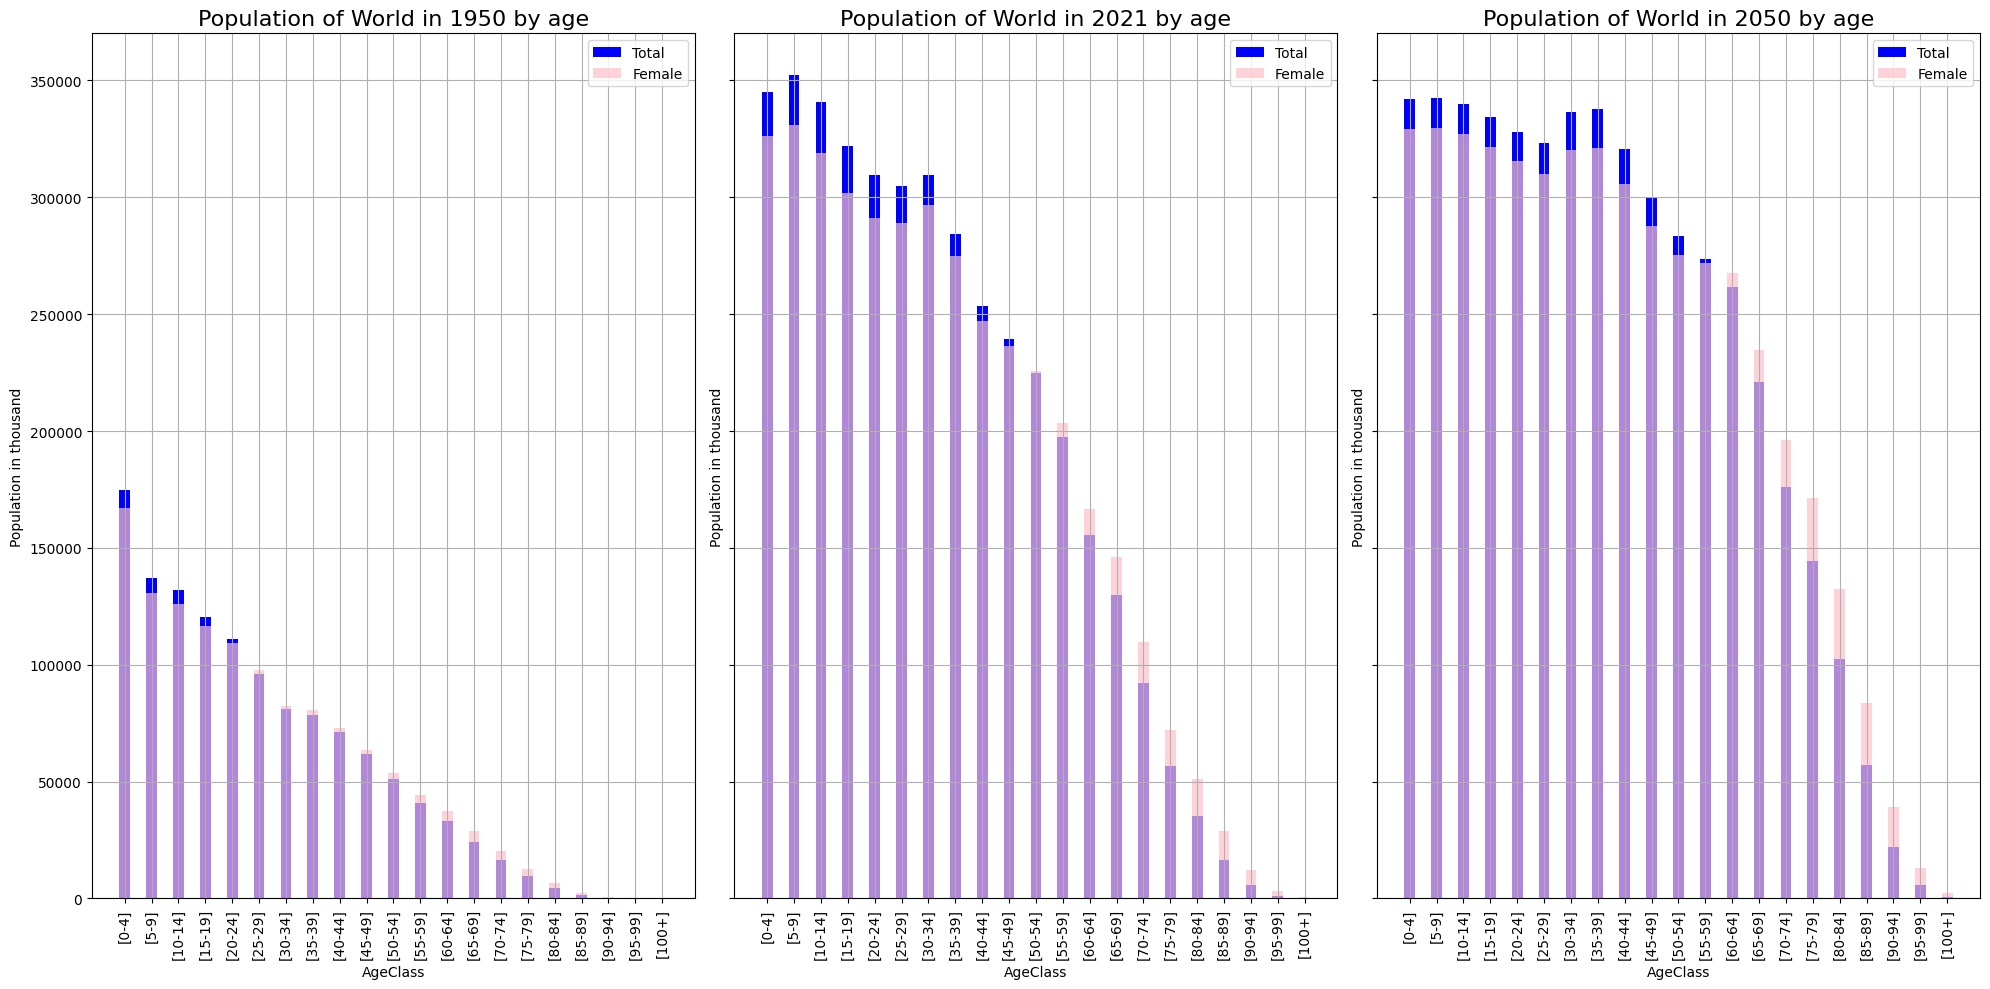

In [28]:
# World Male Population by Age
world_male_agewise_1950_df = world_df.filter((world_df['Year'] == '1950') & (world_df['Sex Label'] == 'Male') & (world_df['AgeClass'] != '0'))
world_male_agewise_2021_df = world_df.filter((world_df['Year'] == '2021') & (world_df['Sex Label'] == 'Male') & (world_df['AgeClass'] != '0'))
world_male_agewise_2050_df = world_df.filter((world_df['Year'] == '2050') & (world_df['Sex Label'] == 'Male') & (world_df['AgeClass'] != '0'))

# Convert to Pandas DataFrame for visualization
world_male_agewise_1950_pd = world_male_agewise_1950_df.toPandas()
world_male_agewise_2021_pd = world_male_agewise_2021_df.toPandas()
world_male_agewise_2050_pd = world_male_agewise_2050_df.toPandas()

# World Female Population by Age
world_female_agewise_1950_df = world_df.filter((world_df['Year'] == '1950') & (world_df['Sex Label'] == 'Female') & (world_df['AgeClass'] != '0'))
world_female_agewise_2021_df = world_df.filter((world_df['Year'] == '2021') & (world_df['Sex Label'] == 'Female') & (world_df['AgeClass'] != '0'))
world_female_agewise_2050_df = world_df.filter((world_df['Year'] == '2050') & (world_df['Sex Label'] == 'Female') & (world_df['AgeClass'] != '0'))

# Convert to Pandas DataFrame for visualization
world_female_agewise_1950_pd = world_female_agewise_1950_df.toPandas()
world_female_agewise_2021_pd = world_female_agewise_2021_df.toPandas()
world_female_agewise_2050_pd = world_female_agewise_2050_df.toPandas()


# Plotting side by side
fig, axes = plt.subplots(1, 3, figsize=(20, 10), sharey=True)

# Function to plot population pyramid for a given year
def plot_population_pyramid(ax, male_pd, female_pd, year):
    bar_width = 0.4
    age_classes = male_pd["AgeClass Label"]
    total_population = male_pd["Absolute value in thousands"]
    female_population = female_pd["Absolute value in thousands"]

    ax.bar(age_classes, total_population, bar_width, label='Total', color='blue')
    ax.bar(age_classes, female_population, bar_width, label='Female', color='pink', alpha=0.7)

    ax.set_xlabel("AgeClass")
    ax.set_ylabel("Population in thousand")
    ax.set_title(f"Population of World in {year} by age", fontsize=16)
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)  # Rotate labels
    ax.legend()

# Plot for 1950
plot_population_pyramid(axes[0], world_male_agewise_1950_pd, world_female_agewise_1950_pd, 1950)

# Plot for 2021
plot_population_pyramid(axes[1], world_male_agewise_2021_pd, world_female_agewise_2021_pd, 2021)

# Plot for 2050
plot_population_pyramid(axes[2], world_male_agewise_2050_pd, world_female_agewise_2050_pd, 2050)

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


* Longivity of people have increase over the years
* Longivity of male have increase over the years
* More male births than female
* women outlive men

## variation of total population by age group over the year

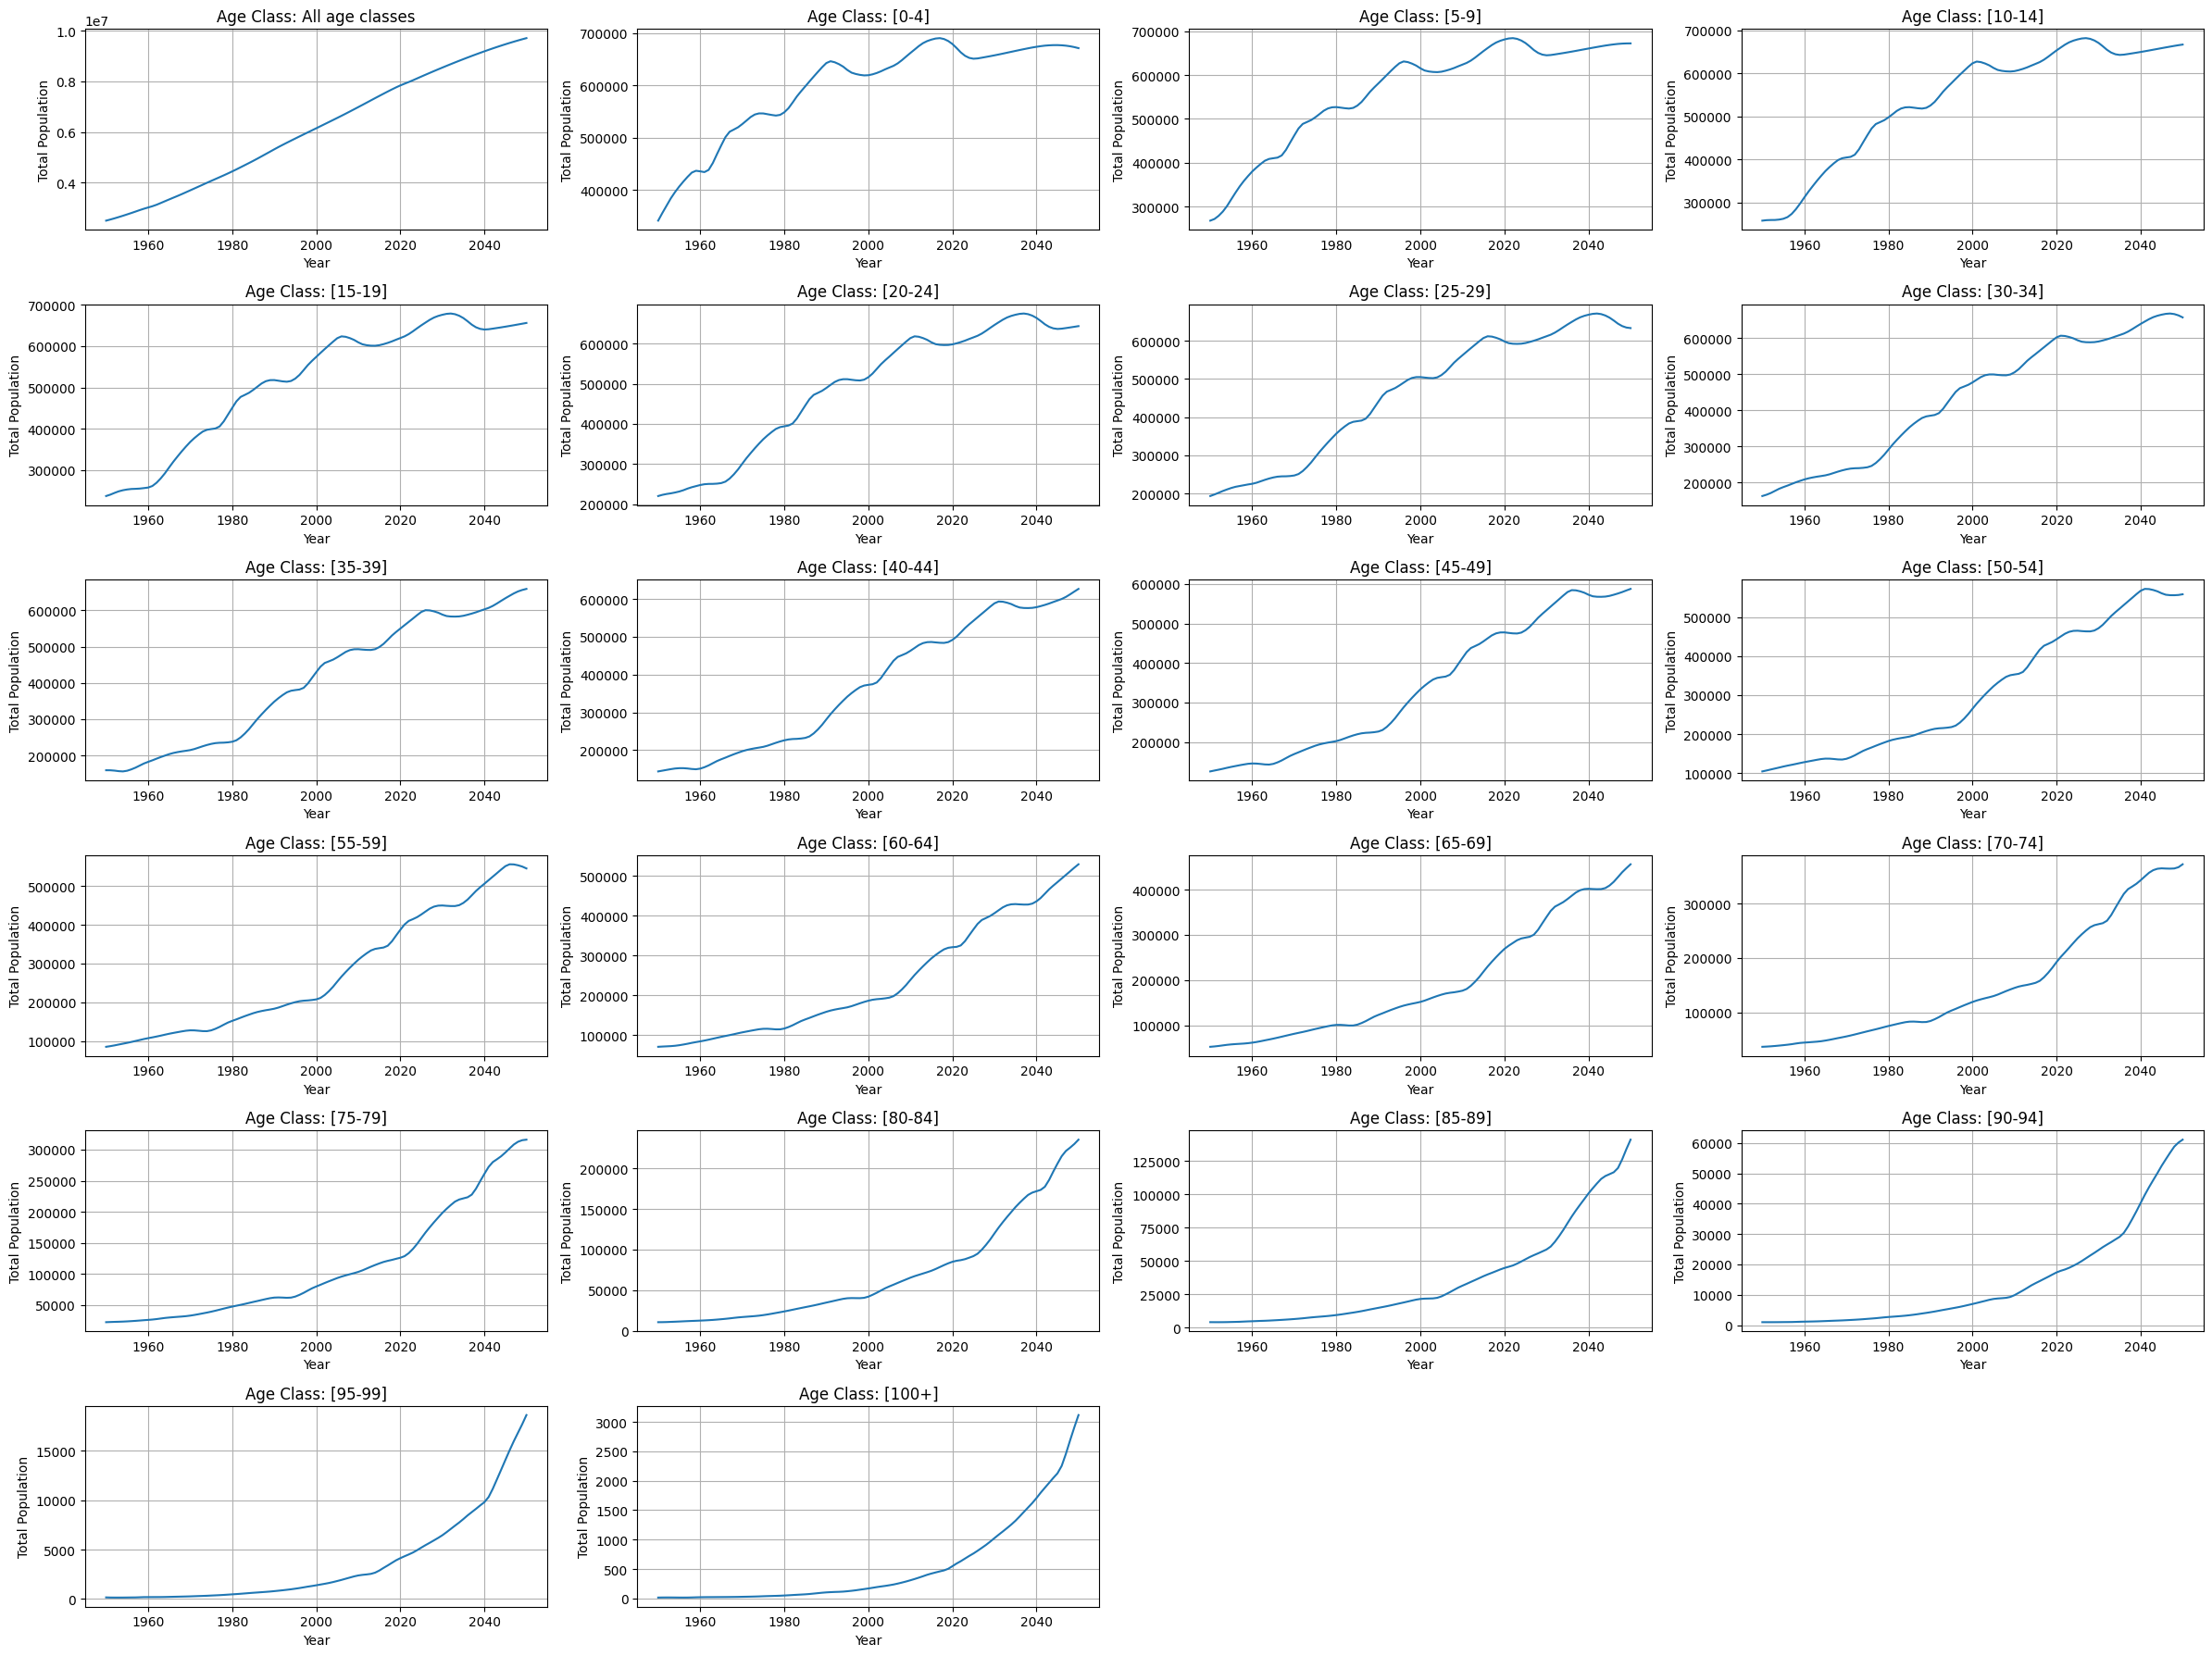

In [29]:
ageClass_labels = ['All age classes',	'[0-4]', '[5-9]', '[10-14]', '[15-19]', '[20-24]' , 	'[25-29]' , 	'[30-34]' , 	'[35-39]' , 	'[40-44]' , 	'[45-49]' , 	'[50-54]' , 	'[55-59]' , 	'[60-64]' , 	'[65-69]' , 	'[70-74]' , 	'[75-79]' , 	'[80-84]' , 	'[85-89]' , 	'[90-94]' , 	'[95-99]' , 	'[100+]']
ageClass_codes = sorted(world_df.select("AgeClass").distinct().rdd.flatMap(lambda x: x).collect())
age_class_mapping = dict(zip(ageClass_codes, ageClass_labels))

fig, axs = plt.subplots(6, 4, figsize=(24, 18))
axs = axs.flatten()  # Flatten the array for easier indexing

for i, code in enumerate(ageClass_codes):
    ageClass_df = world_df.filter((world_df['AgeClass'] == code) & (world_df['Sex Label'] == 'Both sexes'))
    ageClass_pd = ageClass_df.toPandas()


    if ageClass_pd.empty:
        continue

    age_class = age_class_mapping.get(code, "Label not found")

    axs[i].plot(ageClass_pd['Year'], ageClass_pd['Absolute value in thousands'])
    axs[i].set_xlabel("Year")
    axs[i].set_ylabel("Total Population")
    axs[i].set_title(f"Age Class: {age_class}")
    axs[i].grid(True)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

## variation of male and female total population by age group over the year

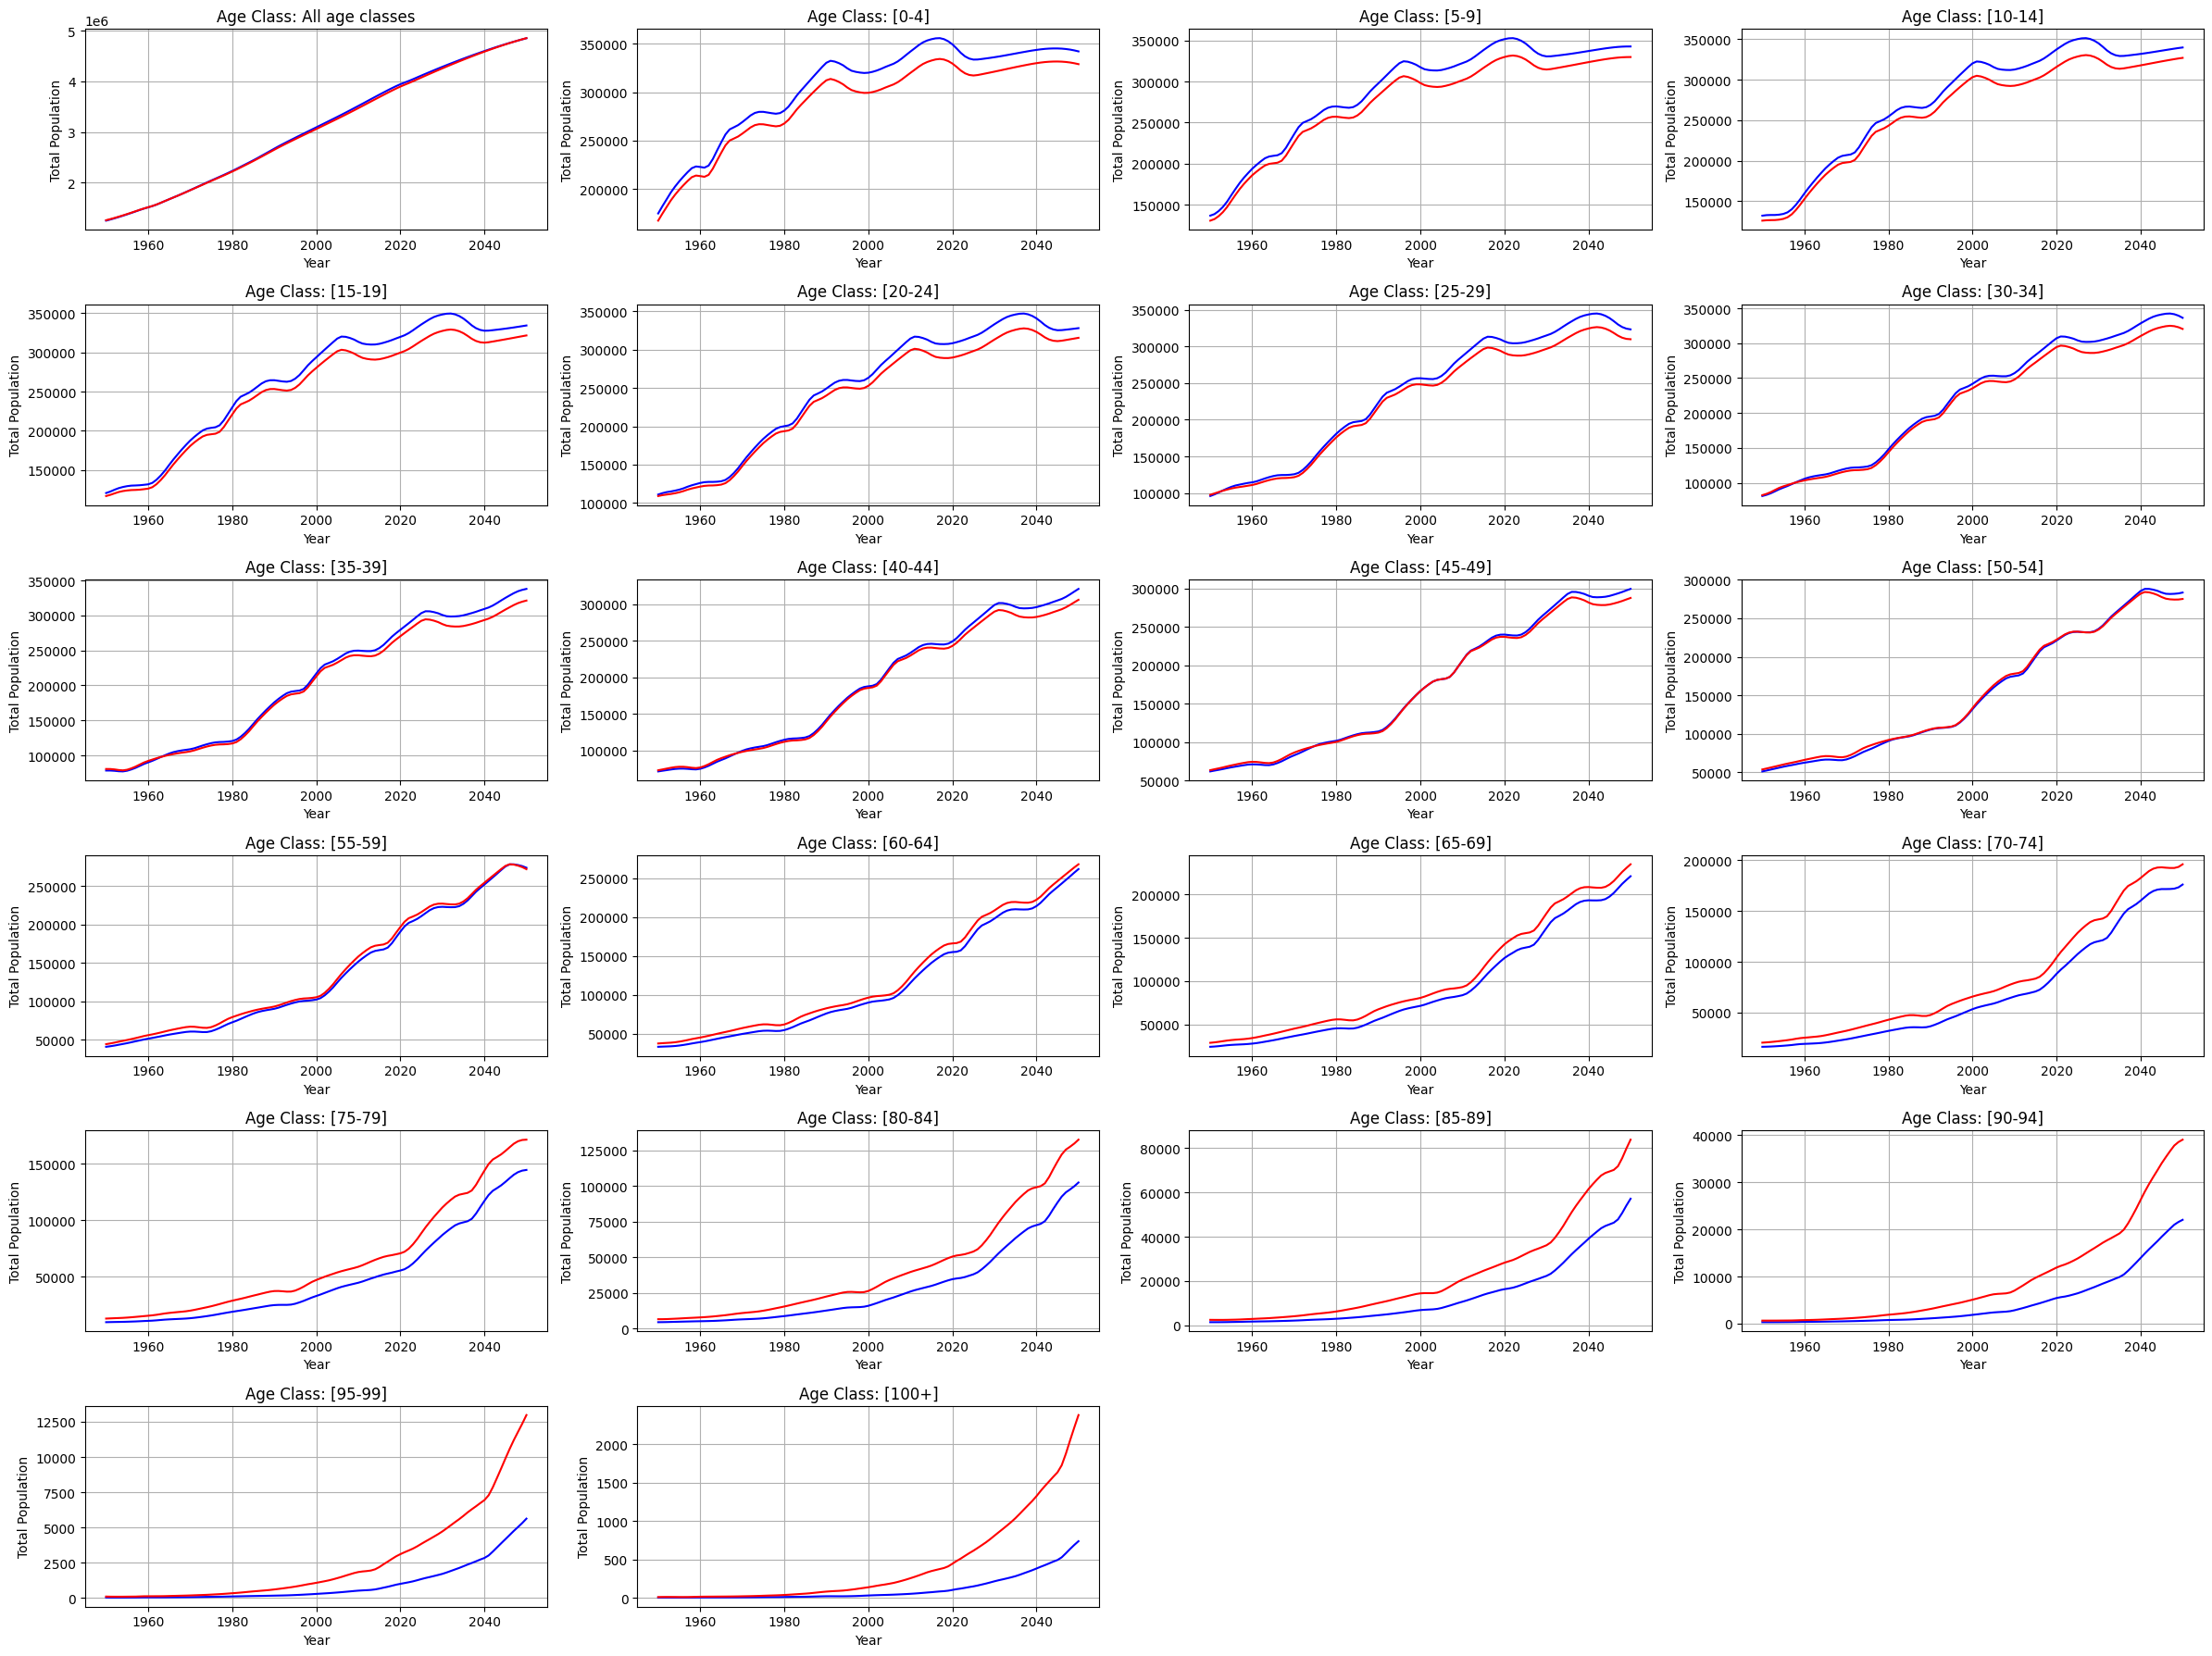

In [30]:
ageClass_labels = ['All age classes',	'[0-4]', '[5-9]', '[10-14]', '[15-19]', '[20-24]' , 	'[25-29]' , 	'[30-34]' , 	'[35-39]' , 	'[40-44]' , 	'[45-49]' , 	'[50-54]' , 	'[55-59]' , 	'[60-64]' , 	'[65-69]' , 	'[70-74]' , 	'[75-79]' , 	'[80-84]' , 	'[85-89]' , 	'[90-94]' , 	'[95-99]' , 	'[100+]']
ageClass_codes = sorted(world_df.select("AgeClass").distinct().rdd.flatMap(lambda x: x).collect())
age_class_mapping = dict(zip(ageClass_codes, ageClass_labels))

fig, axs = plt.subplots(6, 4, figsize=(24, 18))
axs = axs.flatten()  # Flatten the array for easier indexing

for i, code in enumerate(ageClass_codes):
    ageClass_male_df = world_df.filter((world_df['AgeClass'] == code) & (world_df['Sex Label'] == 'Male'))
    ageClass_female_df = world_df.filter((world_df['AgeClass'] == code) & (world_df['Sex Label'] == 'Female'))
    male_pd = ageClass_male_df.toPandas()
    female_pd = ageClass_female_df.toPandas()


    if ageClass_pd.empty:
        continue

    age_class = age_class_mapping.get(code, "Label not found")

    axs[i].plot(male_pd['Year'], male_pd['Absolute value in thousands'], color = 'blue', label = 'male')
    axs[i].plot(female_pd['Year'], female_pd['Absolute value in thousands'], color = 'red', label = 'female')
    axs[i].set_xlabel("Year")
    axs[i].set_ylabel("Total Population")
    axs[i].set_title(f"Age Class: {age_class}")
    axs[i].grid(True)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

## Percentage of Population Above Sixty Over the Years in the world

In [31]:
world_df = df_cleaned[(df_cleaned['Economy Label'] == 'World') & (df_cleaned['Sex Label'] == 'Both sexes')]
world_df = world_df[['Year', 'AgeClass Label', 'Absolute value in thousands']]
world_df.show(5,truncate=False)

+----+---------------+---------------------------+
|Year|AgeClass Label |Absolute value in thousands|
+----+---------------+---------------------------+
|1950|All age classes|2499322.166                |
|1950|[0-4]          |341876.795                 |
|1950|[5-9]          |267730.584                 |
|1950|[10-14]        |258080.868                 |
|1950|[15-19]        |237173.367                 |
+----+---------------+---------------------------+
only showing top 5 rows



In [32]:
# Filter for AgeClass_Label above 60 and group by year to sum the Absolute value
temp_df = world_df.filter(world_df["AgeClass Label"].isin(['[60-64]', '[65-69]' ,	'[70-74]' ,	'[75-79]' ,	'[80-84]' ,	'[85-89]' ,	'[90-94]', '[95-99]',	'[100+]'])).groupBy("Year").agg(
    spark_sum("Absolute value in thousands").alias("Value")
)

# Add the new AgeClass_Label
temp_df = temp_df.withColumn("AgeClass Label", lit("Above Sixty"))

# Select columns in the correct order
temp_df = temp_df.select("Year", "AgeClass Label", "Value")

# Combine the original DataFrame with the new rows
world_sixty_df = world_df.union(temp_df)

# Show the result
world_sixty_df.orderBy("Year").show(5,truncate=False)

+----+---------------+---------------------------+
|Year|AgeClass Label |Absolute value in thousands|
+----+---------------+---------------------------+
|1950|Above Sixty    |199004.203                 |
|1950|All age classes|2499322.166                |
|1950|[0-4]          |341876.795                 |
|1950|[5-9]          |267730.584                 |
|1950|[10-14]        |258080.868                 |
+----+---------------+---------------------------+
only showing top 5 rows



In [33]:

# Filter to include only rows with AgeClass_Label All age classes and Above Sixty
world_filtered_df = world_sixty_df.filter(world_sixty_df["AgeClass Label"].isin('All age classes', 'Above Sixty'))
world_filtered_df.orderBy("Year").show(5)

# Order by year and AgeClass_Label
world_filtered_df = world_filtered_df.orderBy("Year", "AgeClass Label")

tt_df = world_filtered_df.groupBy("Year").pivot("AgeClass Label").sum("Absolute value in thousands")
tt_df.orderBy("Year").show(5)

percentage_df = tt_df.withColumn("Percentage", round((tt_df['Above Sixty'] * 100)/ tt_df['All age classes'], 2))
percentage_df.select("Year","Percentage").orderBy("Year").show(5)
percentage_df.describe().show()


+----+---------------+---------------------------+
|Year| AgeClass Label|Absolute value in thousands|
+----+---------------+---------------------------+
|1950|    Above Sixty|                 199004.203|
|1950|All age classes|                2499322.166|
|1951|    Above Sixty|         201079.19399999996|
|1951|All age classes|                2543130.378|
|1952|    Above Sixty|                 203479.123|
+----+---------------+---------------------------+
only showing top 5 rows

+----+------------------+---------------+
|Year|       Above Sixty|All age classes|
+----+------------------+---------------+
|1950|        199004.203|    2499322.166|
|1951|201079.19399999996|    2543130.378|
|1952|        203479.123|    2590270.906|
|1953|206348.56300000002|    2640278.794|
|1954|209683.62600000005|    2691979.337|
+----+------------------+---------------+
only showing top 5 rows

+----+----------+
|Year|Percentage|
+----+----------+
|1950|      7.96|
|1951|      7.91|
|1952|      7.86|
|1953

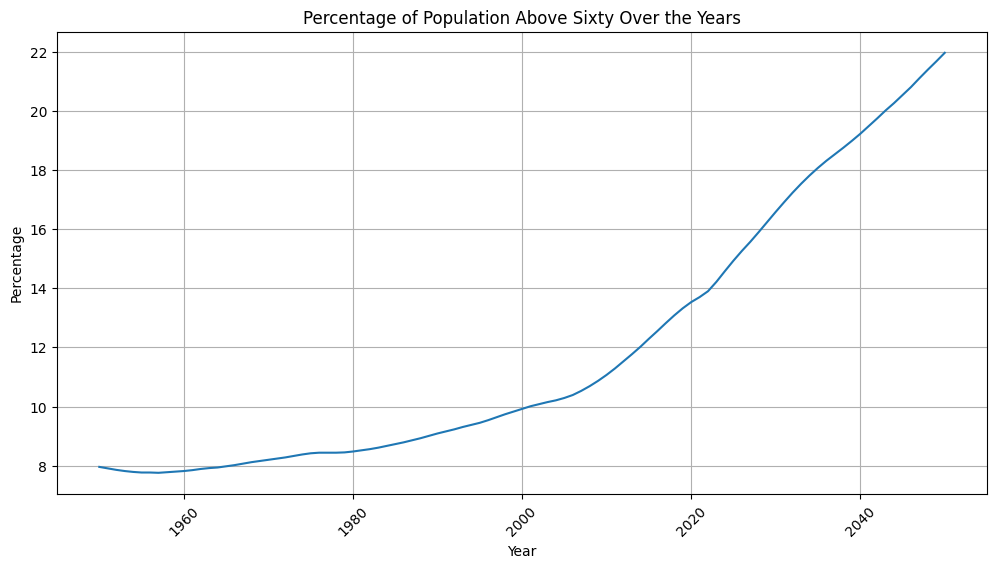

In [34]:
# Convert Spark DataFrame to Pandas DataFrame
percentage_pd_df = percentage_df.toPandas()

# Sort the Pandas DataFrame by 'Year'
percentage_pd_df = percentage_pd_df.sort_values(by='Year')

# Plot the percentage over the years
plt.figure(figsize=(12, 6))
plt.plot(percentage_pd_df['Year'], percentage_pd_df['Percentage'])
plt.title('Percentage of Population Above Sixty Over the Years')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

## Percentage of Workforce Over the Years in the world

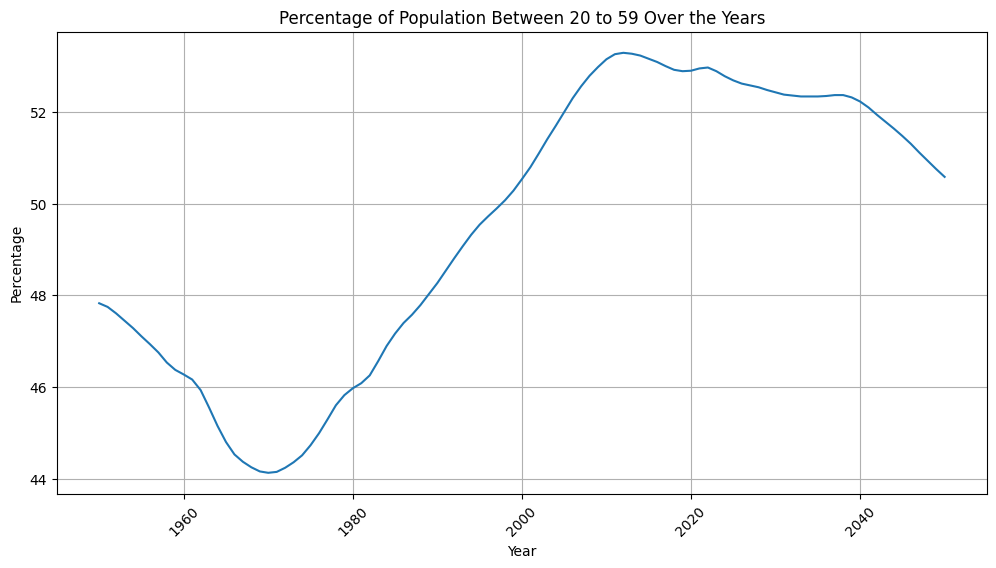

In [35]:
# Filter for AgeClass_Label above 60 and group by year to sum the Absolute value
temp_df = world_df.filter(world_df["AgeClass Label"].isin(['[20-24]' , 	'[25-29]' , 	'[30-34]' , 	'[35-39]' , 	'[40-44]' , 	'[45-49]' , 	'[50-54]' , 	'[55-59]'])).groupBy("Year").agg(
    spark_sum("Absolute value in thousands").alias("Value")
)

# Add the new AgeClass_Label
temp_df = temp_df.withColumn("AgeClass Label", lit("Above Sixty"))

# Select columns in the correct order
temp_df = temp_df.select("Year", "AgeClass Label", "Value")

# Combine the original DataFrame with the new rows
world_sixty_df = world_df.union(temp_df)

# Filter to include only rows with AgeClass_Label All age classes and Above Sixty
world_filtered_df = world_sixty_df.filter(world_sixty_df["AgeClass Label"].isin('All age classes', 'Above Sixty'))

# Order by year and AgeClass_Label
world_filtered_df = world_filtered_df.orderBy("Year", "AgeClass Label")

tt_df = world_filtered_df.groupBy("Year").pivot("AgeClass Label").sum("Absolute value in thousands")

percentage_df = tt_df.withColumn("Percentage", round((tt_df['Above Sixty'] * 100)/ tt_df['All age classes'], 2))

# Convert Spark DataFrame to Pandas DataFrame
percentage_pd_df = percentage_df.toPandas()

# Sort the Pandas DataFrame by 'Year'
percentage_pd_df = percentage_pd_df.sort_values(by='Year')

# Plot the percentage over the years
plt.figure(figsize=(12, 6))
plt.plot(percentage_pd_df['Year'], percentage_pd_df['Percentage'])
plt.title('Percentage of Population Between 20 to 59 Over the Years')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

Post-War Demographic Shifts: After World War II, many countries experienced a significant shift in demographics. The baby boom led to a temporary increase in the population, but many of these individuals were not yet of working age by the 1970s.

High Fertility Rates: In the mid-20th century, many countries, especially in the developing world, had high fertility rates. The large number of births during this period contributed to a youthful population structure, reducing the proportion of the adult population.

Improved Healthcare and Lower Infant Mortality: Advances in healthcare, vaccinations, and public health measures led to lower infant and child mortality rates. As more children survived into adolescence and adulthood, the percentage of younger age groups increased relative to the 20-59 age group.

## Percentage of Children Over the Years in the world

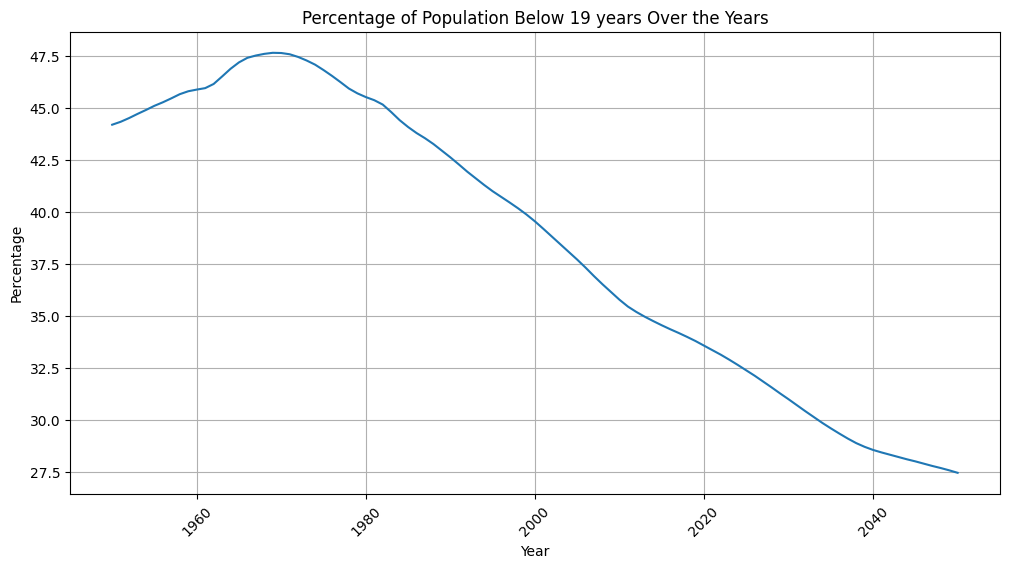

In [36]:
# Filter for AgeClass_Label above 60 and group by year to sum the Absolute value
temp_df = world_df.filter(world_df["AgeClass Label"].isin(['[0-4]', '[5-9]', '[10-14]', '[15-19]'])).groupBy("Year").agg(
    spark_sum("Absolute value in thousands").alias("Value")
)

# Add the new AgeClass_Label
temp_df = temp_df.withColumn("AgeClass Label", lit("Above Sixty"))

# Select columns in the correct order
temp_df = temp_df.select("Year", "AgeClass Label", "Value")

# Combine the original DataFrame with the new rows
world_sixty_df = world_df.union(temp_df)

# Filter to include only rows with AgeClass_Label All age classes and Above Sixty
world_filtered_df = world_sixty_df.filter(world_sixty_df["AgeClass Label"].isin('All age classes', 'Above Sixty'))

# Order by year and AgeClass_Label
world_filtered_df = world_filtered_df.orderBy("Year", "AgeClass Label")

tt_df = world_filtered_df.groupBy("Year").pivot("AgeClass Label").sum("Absolute value in thousands")

percentage_df = tt_df.withColumn("Percentage", round((tt_df['Above Sixty'] * 100)/ tt_df['All age classes'], 2))

# Convert Spark DataFrame to Pandas DataFrame
percentage_pd_df = percentage_df.toPandas()

# Sort the Pandas DataFrame by 'Year'
percentage_pd_df = percentage_pd_df.sort_values(by='Year')

# Plot the percentage over the years
plt.figure(figsize=(12, 6))
plt.plot(percentage_pd_df['Year'], percentage_pd_df['Percentage'])
plt.title('Percentage of Population Below 19 years Over the Years')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

Post-World War II Baby Boom: After World War II, many countries experienced a significant increase in birth rates, known as the baby boom. This increase in the number of births led to a higher proportion of children and teenagers in the population

High Fertility Rates in Developing Countries: During this period, many developing countries experienced high fertility rates, meaning that women were having more children on average. This contributed significantly to a youthful population structure, as a large number of children were born in these countries.

Improved Healthcare and Lower Infant Mortality: Advances in medical technology, vaccinations, and overall improvements in public health led to a significant decrease in infant and child mortality rates. More children surviving past infancy and early childhood meant that the proportion of young people in the population increased.

# 3. Analysing Countries

## Filter Countries and Other Economies

Below we see 'Economy' have countries and other categories like, continents, organizations, Islands etc. Let's filter out countries and non-country economies to analyse seperately.

In [37]:
# List all available Economy and Economy Labels
economy_df = df_cleaned.select("Economy", "Economy Label").distinct()
economy_df.orderBy('Economy Label').show(20, truncate=False)

economy_df.describe().show()

+-------+-------------------+
|Economy|Economy Label      |
+-------+-------------------+
|4      |Afghanistan        |
|5100   |Africa             |
|8      |Albania            |
|12     |Algeria            |
|16     |American Samoa     |
|5200   |Americas           |
|20     |Andorra            |
|24     |Angola             |
|660    |Anguilla           |
|28     |Antigua and Barbuda|
|32     |Argentina          |
|51     |Armenia            |
|533    |Aruba              |
|5300   |Asia               |
|5600   |Asia and Oceania   |
|36     |Australia          |
|40     |Austria            |
|31     |Azerbaijan         |
|2711   |BRICS              |
|44     |Bahamas            |
+-------+-------------------+
only showing top 20 rows

+-------+-----------------+-------------+
|summary|          Economy|Economy Label|
+-------+-----------------+-------------+
|  count|              312|          312|
|   mean|           1078.0|         NULL|
| stddev|1528.278362214023|         NULL|
| 

Thses are the 195 Countries identifies by UN (including countries that changes names).

In [38]:
country_names = [
    "Afghanistan",
    "Albania",
    "Algeria",
    "Andorra",
    "Angola",
    "Antigua and Barbuda",
    "Argentina",
    "Armenia",
    "Australia",
    "Austria",
    "Azerbaijan",
    "Bahamas",
    "Bahrain",
    "Bangladesh",
    "Barbados",
    "Belarus",
    "Belgium",
    "Belize",
    "Benin",
    "Bhutan",
    "Bolivia (Plurinational State of)",
    "Bosnia and Herzegovina",
    "Botswana",
    "Brazil",
    "Brunei Darussalam",
    "Bulgaria",
    "Burkina Faso",
    "Burundi",
    "Cabo Verde",
    "Cambodia",
    "Cameroon",
    "Canada",
    "Central African Republic",
    "Chad",
    "Chile",
    "China",
    "Colombia",
    "Comoros",
    "Congo, Dem. Rep. of the",
    "Costa Rica",
    "Croatia",
    "Cuba",
    "Cyprus",
    "Czechia",
    "Côte d'Ivoire",
    "Denmark",
    "Djibouti",
    "Dominica",
    "Dominican Republic",
    "DR Congo",
    "Ecuador",
    "Egypt",
    "El Salvador",
    "Equatorial Guinea",
    "Eritrea",
    "Estonia",
    "Eswatini",
    "Ethiopia",
    "Fiji",
    "Finland",
    "France",
    "Gabon",
    "Gambia",
    "Georgia",
    "Germany",
    "Ghana",
    "Greece",
    "Grenada",
    "Guatemala",
    "Guinea",
    "Guinea-Bissau",
    "Guyana",
    "Haiti",
    "Holy See",
    "Honduras",
    "Hungary",
    "Iceland",
    "India",
    "Indonesia",
    "Iran (Islamic Republic of)",
    "Iraq",
    "Ireland",
    "Israel",
    "Italy",
    "Jamaica",
    "Japan",
    "Jordan",
    "Kazakhstan",
    "Kenya",
    "Kiribati",
    "Kuwait",
    "Kyrgyzstan",
    "Lao People's Dem. Rep.",
    "Latvia",
    "Lebanon",
    "Lesotho",
    "Liberia",
    "Libya",
    "Liechtenstein",
    "Lithuania",
    "Luxembourg",
    "Madagascar",
    "Malawi",
    "Malaysia",
    "Maldives",
    "Mali",
    "Malta",
    "Marshall Islands",
    "Mauritania",
    "Mauritius",
    "Mexico",
    "Micronesia (Federated States of)",
    "Moldova, Republic of",
    "Monaco",
    "Mongolia",
    "Montenegro",
    "Morocco",
    "Mozambique",
    "Myanmar",
    "Namibia",
    "Nauru",
    "Nepal",
    "Netherlands (Kingdom of the)",
    "New Zealand",
    "Nicaragua",
    "Niger",
    "Nigeria",
    "Korea, Republic of",
    "North Macedonia",
    "Norway",
    "Oman",
    "Pakistan",
    "Palau",
    "Panama",
    "Papua New Guinea",
    "Paraguay",
    "Peru",
    "Philippines",
    "Poland",
    "Portugal",
    "Qatar",
    "Romania",
    "Russian Federation",
    "Rwanda",
    "Saint Kitts and Nevis",
    "Saint Lucia",
    "Samoa",
    "San Marino",
    "Sao Tome and Principe",
    "Saudi Arabia",
    "Senegal",
    "Serbia",
    "Seychelles",
    "Sierra Leone",
    "Singapore",
    "Slovakia",
    "Slovenia",
    "Solomon Islands",
    "Somalia",
    "South Africa",
    "Korea, Dem. People's Rep. of",
    "South Sudan",
    "Spain",
    "Sri Lanka",
    "Saint Vincent and the Grenadines",
    "State of Palestine",
    "Sudan",
    "Suriname",
    "Sweden",
    "Switzerland",
    "Syrian Arab Republic",
    "Tajikistan",
    "Tanzania, United Republic of",
    "Thailand",
    "Timor-Leste",
    "Togo",
    "Tonga",
    "Trinidad and Tobago",
    "Tunisia",
    "Türkiye",
    "Turkmenistan",
    "Tuvalu",
    "Uganda",
    "Ukraine",
    "United Arab Emirates",
    "United Kingdom",
    "United States of America",
    "Uruguay",
    "Uzbekistan",
    "Vanuatu",
    "Venezuela (Bolivarian Rep. of)",
    "Viet Nam",
    "Yemen",
    "Zambia",
    "Zimbabwe",
    'Yemen, Democratic',
    'Sudan (...2011)',
    'Indonesia (...2002)',
    'Germany, Federal Republic of',
    'Ethiopia (...1991)',
    'Czechoslovakia',
    'Congo']

print("country_names:", len(country_names))

# Broadcast the list for efficient filtering
country_names_broadcast = spark.sparkContext.broadcast(country_names)



country_names: 202


In [39]:
# Define a UDF to identify non-country economy labels
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType

def is_country(economy_label):
    return economy_label in country_names_broadcast.value

is_country_udf = udf(is_country, BooleanType())

# Add a column to identify if an Economy Label is a country
economy_temp_df = economy_df.withColumn("IsCountry", is_country_udf(economy_df["Economy Label"]))
non_countries_temp_df = economy_temp_df.filter(~economy_temp_df["IsCountry"])
non_countries_temp_df.show(5, truncate=False)
non_countries_temp_df.describe().show()


+-------+--------------------------------+---------+
|Economy|Economy Label                   |IsCountry|
+-------+--------------------------------+---------+
|5123   |Southern Africa                 |false    |
|1550   |Developed economies: Oceania    |false    |
|654    |Saint Helena                    |false    |
|92     |British Virgin Islands          |false    |
|582    |Pacific Islands, Trust Territory|false    |
+-------+--------------------------------+---------+
only showing top 5 rows

+-------+------------------+--------------------+
|summary|           Economy|       Economy Label|
+-------+------------------+--------------------+
|  count|               111|                 111|
|   mean|  2242.09009009009|                NULL|
| stddev|2088.4446694285525|                NULL|
|    min|                 0|              Africa|
|    max|              5706|Yugoslavia, Soc. ...|
+-------+------------------+--------------------+



Seperate and get the country only list

In [40]:
# Filter the cleaned dataset to exclude entries that are not countries

# First, get a list of non-country economy
non_country_economy = non_countries_temp_df.select("Economy").rdd.flatMap(lambda x: x).collect()

# Filter the cleaned dataset
country_df = df_cleaned.filter(~df_cleaned["Economy"].isin(non_country_economy))
country_df.show(truncate=False)
country_df.describe().show()

print("Economy Labels:", sorted(country_df.select("Economy Label").distinct().rdd.flatMap(lambda x: x).collect()))
print("Economy Labels:", len(country_df.select("Economy Label").distinct().rdd.flatMap(lambda x: x).collect()))

+----+-------+-------------+---+----------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|Year|Economy|Economy Label|Sex|Sex Label |AgeClass|AgeClass Label |Absolute value in thousands|Absolute value in thousands Footnote|Absolute value in thousands Missing value|
+----+-------+-------------+---+----------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|1950|4      |Afghanistan  |0  |Both sexes|0       |All age classes|7480.461                   |NULL                                |NULL                                     |
|1950|4      |Afghanistan  |0  |Both sexes|1       |[0-4]          |1248.282                   |NULL                                |NULL                                     |
|1950|4      |Afghanistan  |0  |Both sexes|2       |[5-9]          |966.211                    |NULL                    

Seperate and get the non-country only list

In [41]:
# Filter the cleaned dataset
non_countries_df = df_cleaned.filter(df_cleaned["Economy"].isin(non_country_economy))
non_countries_df.show(truncate=False)
non_countries_df.describe().show()

print("Economy Labels:", sorted(country_df.select("Economy Label").distinct().rdd.flatMap(lambda x: x).collect()))
print("Economy Labels:", len(country_df.select("Economy Label").distinct().rdd.flatMap(lambda x: x).collect()))
print("Economy Labels:", sorted(non_countries_df.select("Economy Label").distinct().rdd.flatMap(lambda x: x).collect()))
print("Economy Labels:", len(non_countries_df.select("Economy Label").distinct().rdd.flatMap(lambda x: x).collect()))

+----+-------+--------------+---+----------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|Year|Economy|Economy Label |Sex|Sex Label |AgeClass|AgeClass Label |Absolute value in thousands|Absolute value in thousands Footnote|Absolute value in thousands Missing value|
+----+-------+--------------+---+----------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|1950|16     |American Samoa|0  |Both sexes|0       |All age classes|19.032                     |NULL                                |NULL                                     |
|1950|16     |American Samoa|0  |Both sexes|1       |[0-4]          |3.554                      |NULL                                |NULL                                     |
|1950|16     |American Samoa|0  |Both sexes|2       |[5-9]          |2.886                      |NULL              

In [42]:
df_c_list = sorted(country_df.select("Economy Label").distinct().rdd.flatMap(lambda x: x).collect())
#df_clean_list = df_cleaned.select("Economy Label").distinct().rdd.flatMap(lambda x: x).collect()

# Find missing countries
missing_countries = set(country_names) - set(df_c_list)
print("Missing countries:", missing_countries)
print("Number of missing countries:", len(missing_countries))


Missing countries: {'DR Congo'}
Number of missing countries: 1


## Get total population by country

+----+-------+-------------+---+----------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|Year|Economy|Economy Label|Sex|Sex Label |AgeClass|AgeClass Label |Absolute value in thousands|Absolute value in thousands Footnote|Absolute value in thousands Missing value|
+----+-------+-------------+---+----------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|2021|4      |Afghanistan  |0  |Both sexes|0       |All age classes|40099.462                  |NULL                                |NULL                                     |
|2021|8      |Albania      |0  |Both sexes|0       |All age classes|2854.71                    |NULL                                |NULL                                     |
|2021|12     |Algeria      |0  |Both sexes|0       |All age classes|44177.969                  |NULL                    

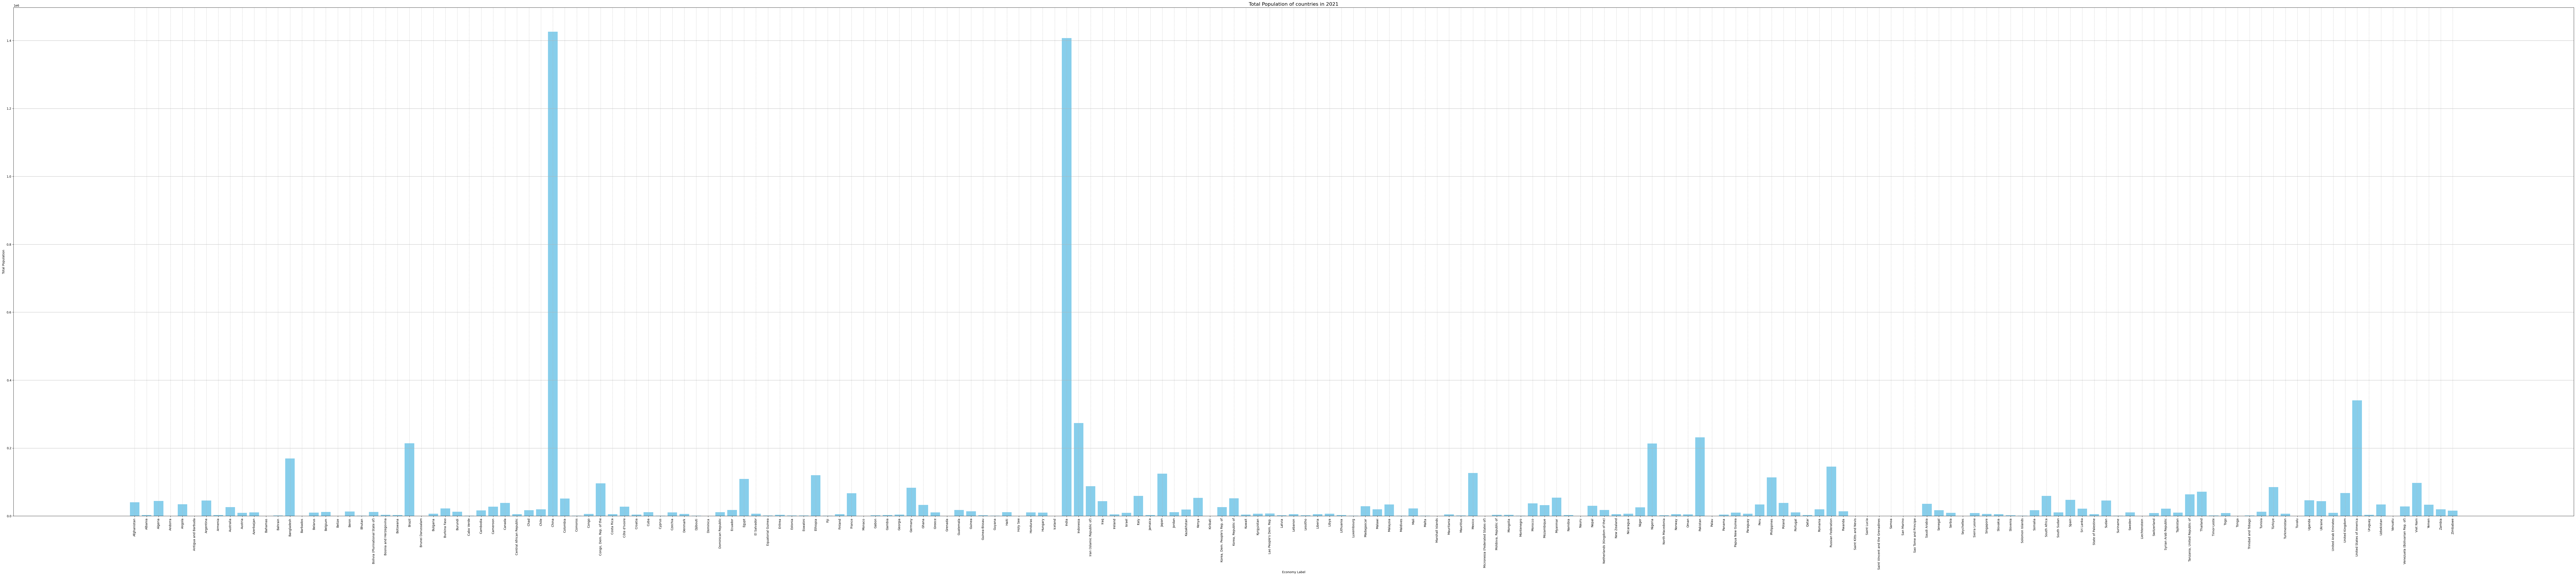

In [43]:
# Get total population by country in 1950/2021/2050
total_population_by_country_1950_df = country_df[(country_df['AgeClass'] == '0') & (country_df['Sex Label'] == 'Both sexes') & (country_df['Year'] == '1950')]
total_population_by_country_2021_df = country_df[(country_df['AgeClass'] == '0') & (country_df['Sex Label'] == 'Both sexes') & (country_df['Year'] == '2021')]
total_population_by_country_2050_df = country_df[(country_df['AgeClass'] == '0') & (country_df['Sex Label'] == 'Both sexes') & (country_df['Year'] == '2050')]

#Show details of 2021
total_population_by_country_2021_df.show(5,truncate=False)
total_population_by_country_2021_df.describe().show()

# Convert to Pandas DataFrame for visualization
total_population_by_country_pd = total_population_by_country_2021_df.toPandas()

# Plot total population by country in 2021
plt.figure(figsize=(150, 30))
plt.bar(
    total_population_by_country_pd["Economy Label"],
    total_population_by_country_pd["Absolute value in thousands"],
    color='skyblue'
)
plt.xlabel("Economy Label")
plt.ylabel("Total Population")
plt.title("Total Population of countries in 2021", fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add vertical grid lines
plt.xticks(rotation=90)
plt.grid(True)

plt.show()

## Plot 10 highest total population by country in 1950/2021/2050

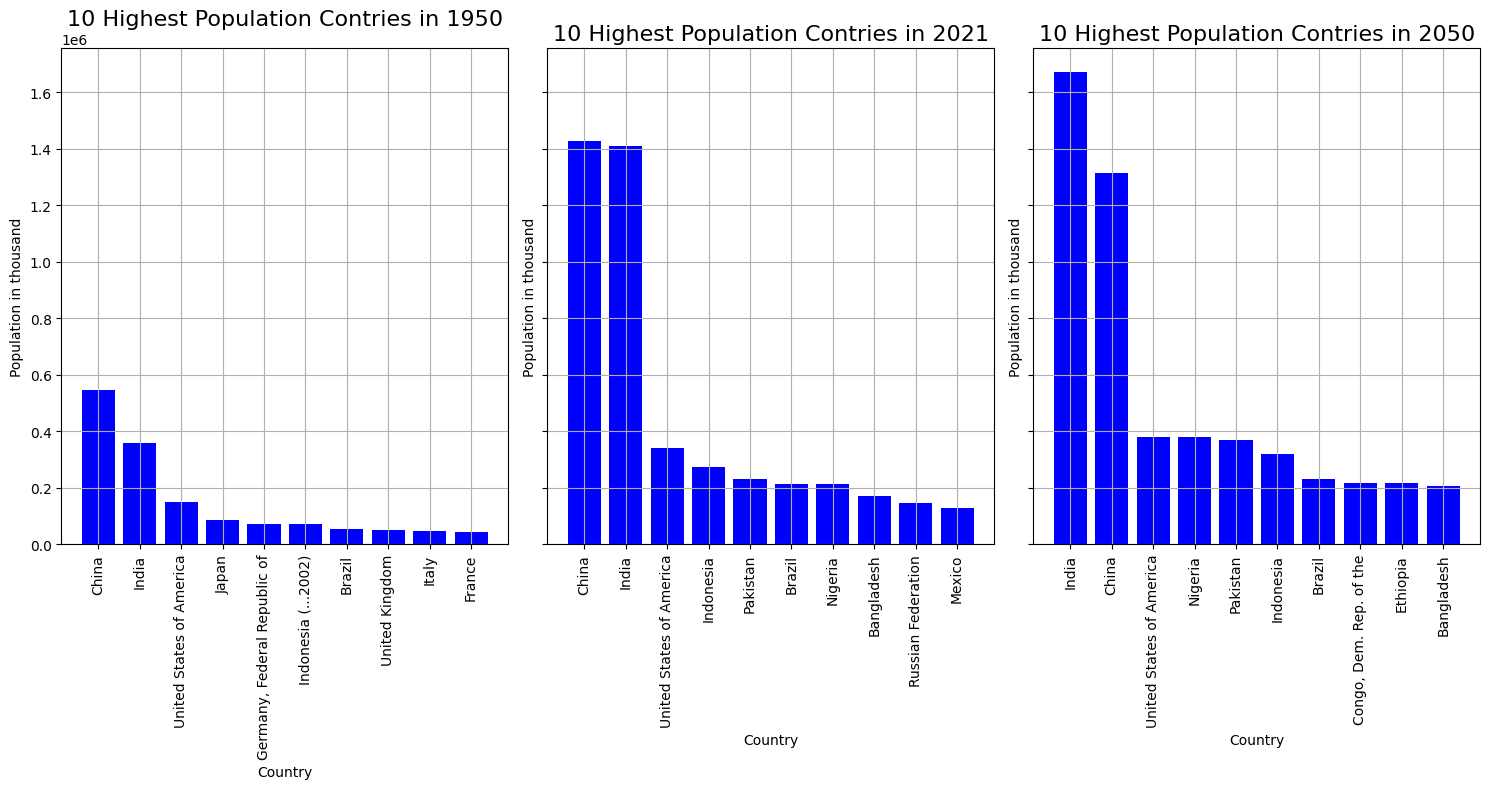

In [44]:
# Convert to Pandas DataFrame for visualization
total_population_by_country_1950_pd = total_population_by_country_1950_df.orderBy(col("Absolute value in thousands").desc()).limit(10).toPandas()
total_population_by_country_2021_pd = total_population_by_country_2021_df.orderBy(col("Absolute value in thousands").desc()).limit(10).toPandas()
total_population_by_country_2050_pd = total_population_by_country_2050_df.orderBy(col("Absolute value in thousands").desc()).limit(10).toPandas()
#total_population_by_country_1950_pd = total_population_by_country_1950_df.toPandas().sort_values(by="Absolute value in thousands", ascending=False).head(10)
#total_population_by_country_2021_pd = total_population_by_country_2021_df.toPandas().sort_values(by="Absolute value in thousands", ascending=False).head(10)
#total_population_by_country_2050_pd = total_population_by_country_2050_df.toPandas().sort_values(by="Absolute value in thousands", ascending=False).head(10)

# Plotting side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 8), sharey=True)

# Plot for 1950
axes[0].bar(total_population_by_country_1950_pd["Economy Label"], total_population_by_country_1950_pd["Absolute value in thousands"],  color='blue')
axes[0].set_xlabel("Country")
axes[0].set_ylabel("Population in thousand")
axes[0].set_title("10 Highest Population Contries in 1950", fontsize=16)
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=90)  # Rotate labels

# Plot for 2021
axes[1].bar(total_population_by_country_2021_pd["Economy Label"], total_population_by_country_2021_pd["Absolute value in thousands"],  color='blue')
axes[1].set_xlabel("Country")
axes[1].set_ylabel("Population in thousand")
axes[1].set_title("10 Highest Population Contries in 2021", fontsize=16)
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=90)  # Rotate labels

# Plot for 2050
axes[2].bar(total_population_by_country_2050_pd["Economy Label"], total_population_by_country_2050_pd["Absolute value in thousands"],  color='blue')
axes[2].set_xlabel("Country")
axes[2].set_ylabel("Population in thousand")
axes[2].set_title("10 Highest Population Contries in 2050", fontsize=16)
axes[2].grid(True)
axes[2].tick_params(axis='x', rotation=90)  # Rotate labels

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

## Plot 10 lowest total population by country in 1950/2021/2050

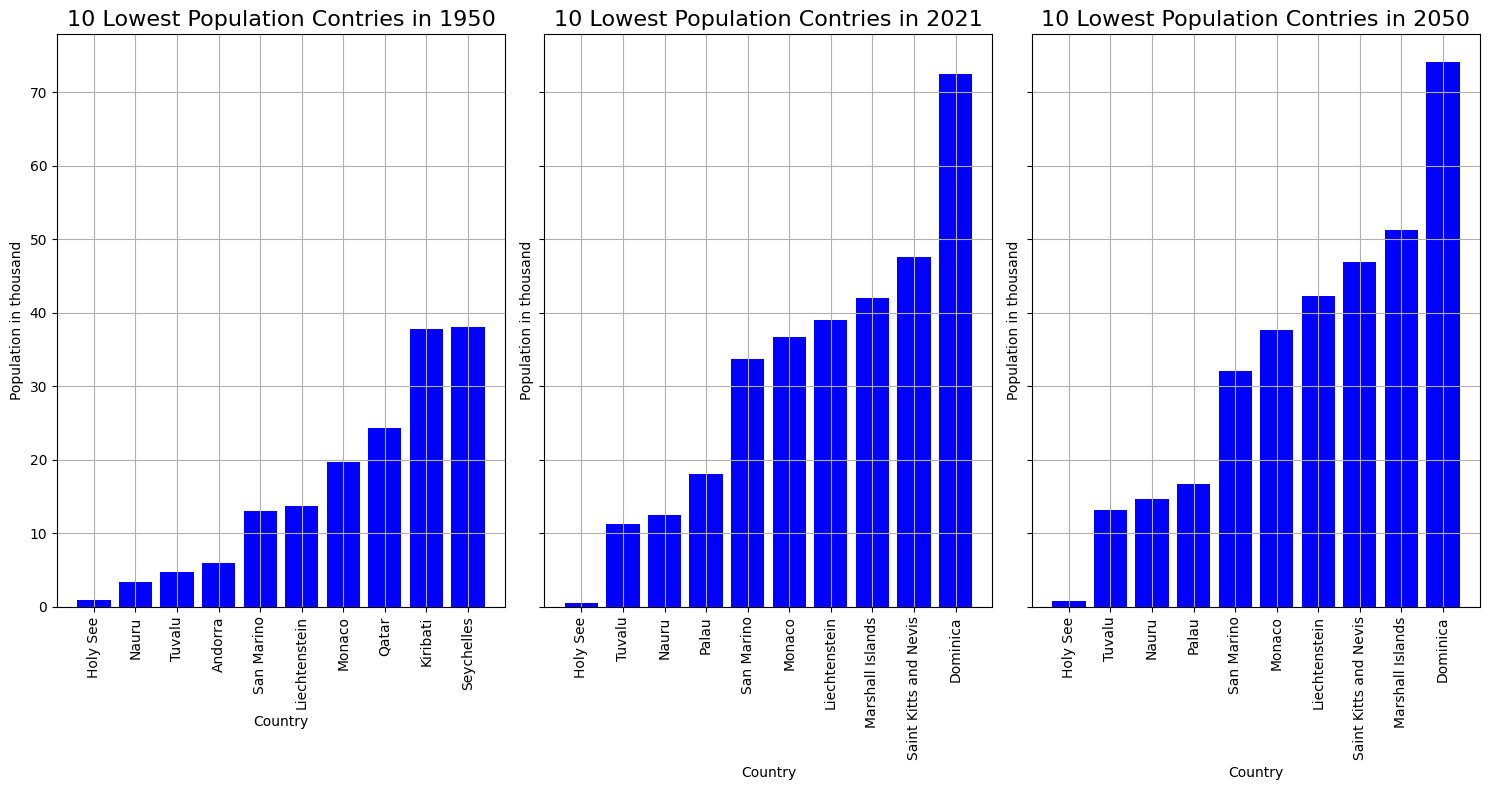

In [45]:
# Convert to Pandas DataFrame for visualization
total_population_by_country_1950_pd = total_population_by_country_1950_df.orderBy(col("Absolute value in thousands").asc()).limit(10).toPandas()
total_population_by_country_2021_pd = total_population_by_country_2021_df.orderBy(col("Absolute value in thousands").asc()).limit(10).toPandas()
total_population_by_country_2050_pd = total_population_by_country_2050_df.orderBy(col("Absolute value in thousands").asc()).limit(10).toPandas()

# Plotting side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 8), sharey=True)

# Plot for 1950
axes[0].bar(total_population_by_country_1950_pd["Economy Label"], total_population_by_country_1950_pd["Absolute value in thousands"],  color='blue')
axes[0].set_xlabel("Country")
axes[0].set_ylabel("Population in thousand")
axes[0].set_title("10 Lowest Population Contries in 1950", fontsize=16)
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=90)  # Rotate labels

# Plot for 2021
axes[1].bar(total_population_by_country_2021_pd["Economy Label"], total_population_by_country_2021_pd["Absolute value in thousands"],  color='blue')
axes[1].set_xlabel("Country")
axes[1].set_ylabel("Population in thousand")
axes[1].set_title("10 Lowest Population Contries in 2021", fontsize=16)
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=90)  # Rotate labels

# Plot for 2050
axes[2].bar(total_population_by_country_2050_pd["Economy Label"], total_population_by_country_2050_pd["Absolute value in thousands"],  color='blue')
axes[2].set_xlabel("Country")
axes[2].set_ylabel("Population in thousand")
axes[2].set_title("10 Lowest Population Contries in 2050", fontsize=16)
axes[2].grid(True)
axes[2].tick_params(axis='x', rotation=90)  # Rotate labels

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

## Population Growth Rates by Country

+----+-------+-------------+---+----------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|Year|Economy|Economy Label|Sex| Sex Label|AgeClass| AgeClass Label|Absolute value in thousands|Absolute value in thousands Footnote|Absolute value in thousands Missing value|
+----+-------+-------------+---+----------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|1950|      4|  Afghanistan|  0|Both sexes|       0|All age classes|                   7480.461|                                NULL|                                     NULL|
|1950|      8|      Albania|  0|Both sexes|       0|All age classes|                   1252.582|                                NULL|                                     NULL|
|1950|     12|      Algeria|  0|Both sexes|       0|All age classes|                   9019.866|                        

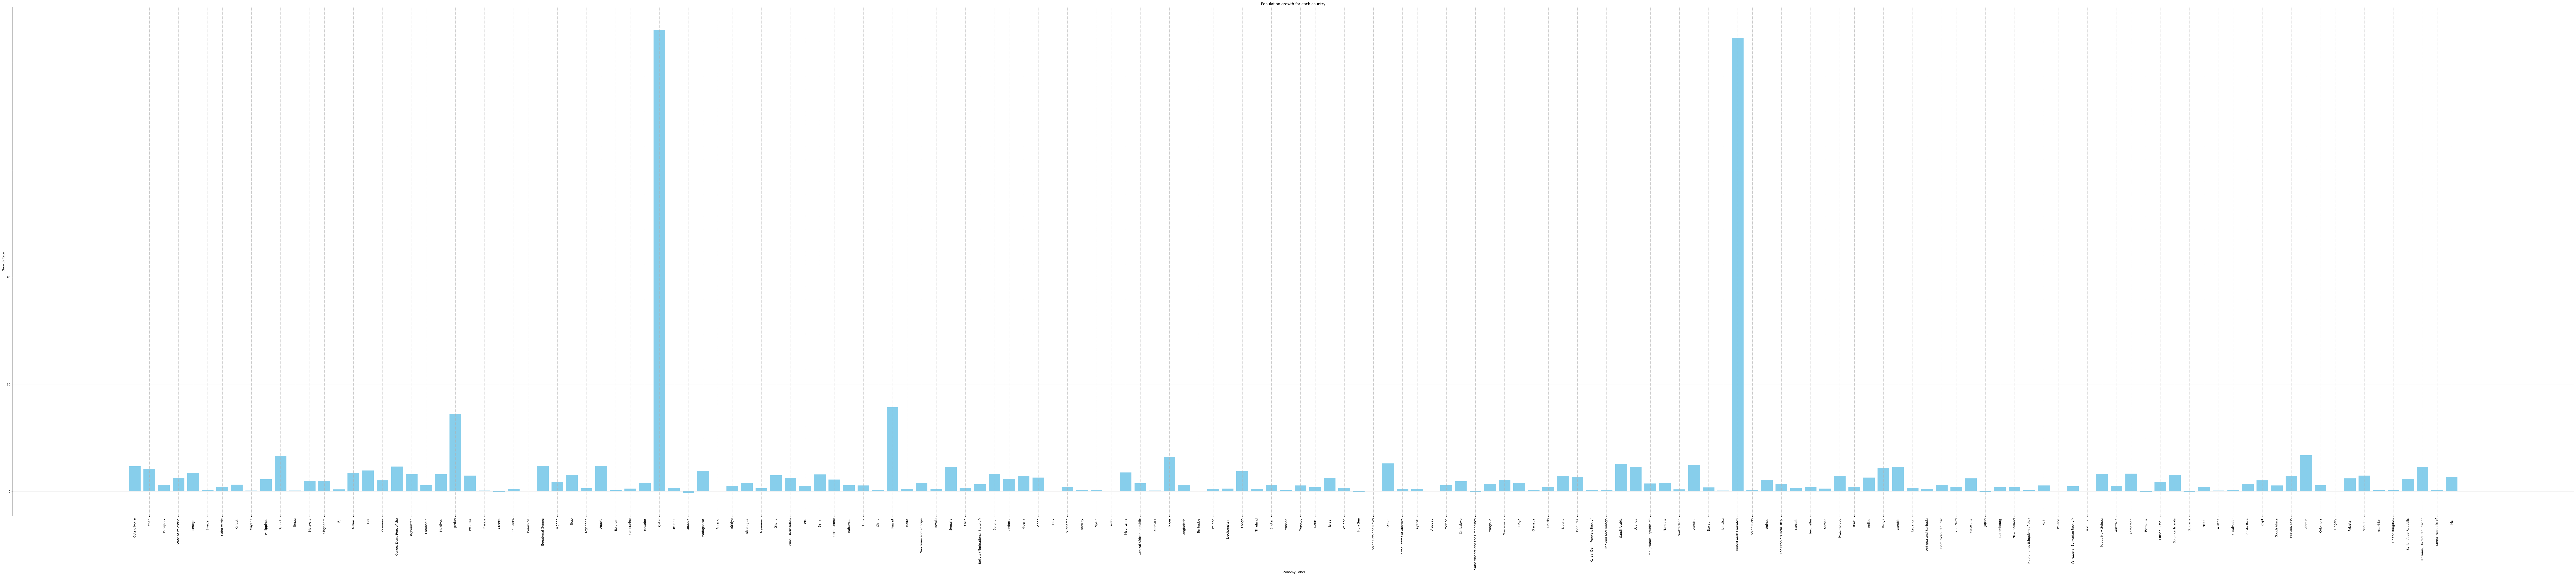

In [46]:
# Calculate growth for each country
total_population_df = country_df.filter((country_df['AgeClass Label'] == 'All age classes') & (country_df['Sex Label'] == 'Both sexes'))
total_population_df.show(5)

population_growth_pivot_df = total_population_df.groupBy("Economy Label").pivot("Year").sum("Absolute value in thousands").dropna()
print(f"Total count: {population_growth_pivot_df.count()}")
population_growth_pivot_df.show(5)

population_growth_rate_df = population_growth_pivot_df.withColumn("Growth Rate", ((population_growth_pivot_df['2024'] - population_growth_pivot_df['2000'])) / population_growth_pivot_df['1950'])
population_growth_rate_df.select('Economy Label','Growth Rate').show(5)

# Convert to Pandas for plotting
population_growth_rate_pd = population_growth_rate_df.toPandas()

# Plotting
plt.figure(figsize=(150, 30))
plt.bar(population_growth_rate_pd["Economy Label"],
        population_growth_rate_pd["Growth Rate"],
        color='skyblue')
plt.xlabel("Economy Label")
plt.ylabel("Growth Rate")
plt.title("Population growth for each country")
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Add vertical grid lines
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


In [47]:
population_growth_rate_df.orderBy("Growth Rate", ascending=True).select('Economy Label', 'Growth Rate').show(10)

+--------------------+--------------------+
|       Economy Label|         Growth Rate|
+--------------------+--------------------+
|             Albania| -0.2842137281231889|
|            Bulgaria|  -0.206643202668145|
|Saint Vincent and...|-0.16461373460300946|
|            Holy See|-0.14204545454545456|
|             Romania| -0.1403577179511878|
|              Greece|-0.09588988224040412|
|               Japan|-0.04946387889310325|
|             Hungary|-0.02217480638194...|
|            Portugal|-0.00918111449370...|
|                Cuba|0.011607916451888087|
+--------------------+--------------------+
only showing top 10 rows



## Plot 10 countries with highest and lowest growth rates

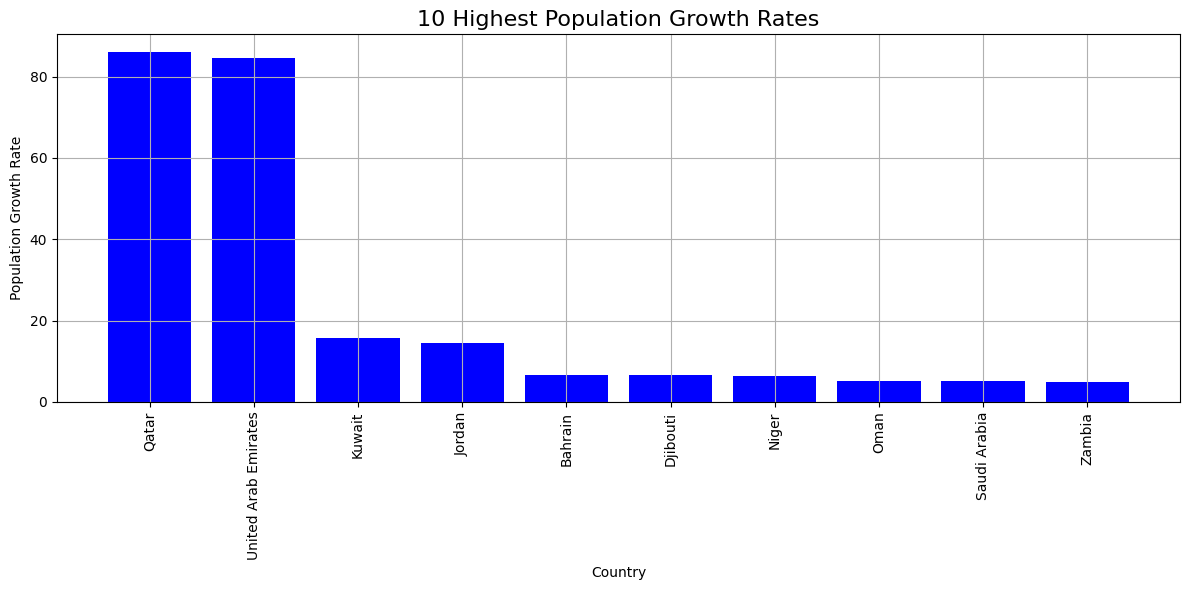

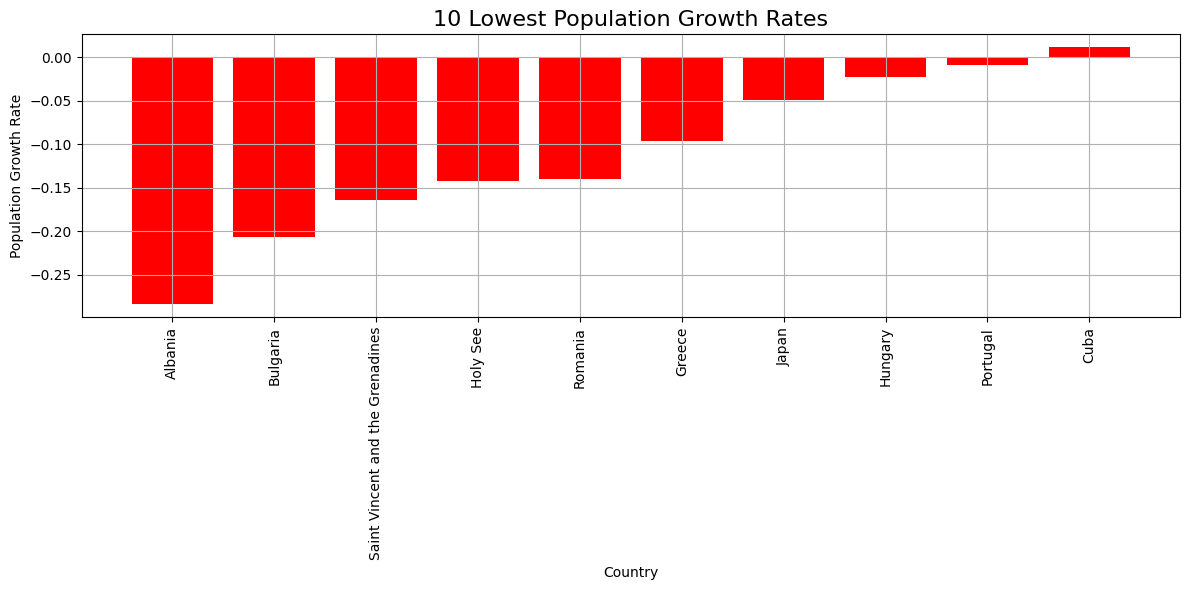

In [48]:
# Convert to pandas DataFrame and sort for highest and lowest growth rates
highest_population_growth_rate_pd = population_growth_rate_df.orderBy(col("Growth Rate").desc()).limit(10).toPandas()
lowest_population_growth_rate_pd = population_growth_rate_df.orderBy(col("Growth Rate").asc()).limit(10).toPandas()

# Plot highest growth rates
plt.figure(figsize=(12, 6))
plt.bar(highest_population_growth_rate_pd["Economy Label"], highest_population_growth_rate_pd["Growth Rate"], color='blue')
plt.xlabel("Country")
plt.ylabel("Population Growth Rate")
plt.title("10 Highest Population Growth Rates", fontsize=16)
plt.grid(True)
plt.xticks(rotation=90)  # Rotate labels
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Plot lowest growth rates
plt.figure(figsize=(12, 6))
plt.bar(lowest_population_growth_rate_pd["Economy Label"], lowest_population_growth_rate_pd["Growth Rate"], color='red')
plt.xlabel("Country")
plt.ylabel("Population Growth Rate")
plt.title("10 Lowest Population Growth Rates", fontsize=16)
plt.grid(True)
plt.xticks(rotation=90)  # Rotate labels
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

## Analysing Japan

### total population in the japan over the years

+----+-------+-------------+---+----------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|Year|Economy|Economy Label|Sex|Sex Label |AgeClass|AgeClass Label |Absolute value in thousands|Absolute value in thousands Footnote|Absolute value in thousands Missing value|
+----+-------+-------------+---+----------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|1950|392    |Japan        |0  |Both sexes|0       |All age classes|84353.049                  |NULL                                |NULL                                     |
|1951|392    |Japan        |0  |Both sexes|0       |All age classes|85683.474                  |NULL                                |NULL                                     |
|1952|392    |Japan        |0  |Both sexes|0       |All age classes|86921.764                  |NULL                    

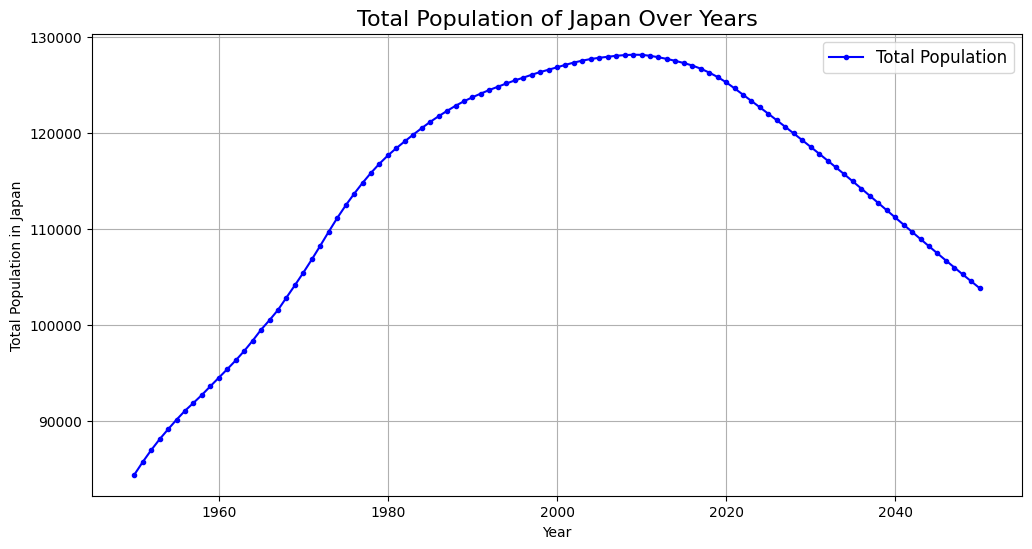

In [49]:
japan_df = df_cleaned.filter((df_cleaned["Economy Label"] == "Japan"))

japan_all_df = japan_df.filter((japan_df['AgeClass Label'] == 'All age classes') & (japan_df['Sex Label'] == 'Both sexes'))
japan_all_df.show(5,truncate=False)
japan_all_df.describe().show()

# Convert to Pandas DataFrame for visualization
japan_all_pd = japan_all_df.toPandas()

# Plot total population over years
plt.figure(figsize=(12, 6))
plt.plot(japan_all_pd["Year"], japan_all_pd["Absolute value in thousands"], marker='.', linestyle='-', color='blue', label='Total Population')
plt.xlabel("Year")
plt.ylabel("Total Population in Japan")
plt.title("Total Population of Japan Over Years", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

plt.show()

### total male and female population over the years


Male Population

+----+-------+-------------+---+---------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|Year|Economy|Economy Label|Sex|Sex Label|AgeClass|AgeClass Label |Absolute value in thousands|Absolute value in thousands Footnote|Absolute value in thousands Missing value|
+----+-------+-------------+---+---------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|1950|392    |Japan        |2  |Male     |0       |All age classes|41333.729                  |NULL                                |NULL                                     |
|1951|392    |Japan        |2  |Male     |0       |All age classes|42006.238                  |NULL                                |NULL                                     |
|1952|392    |Japan        |2  |Male     |0       |All age classes|42631.103                  |NULL        

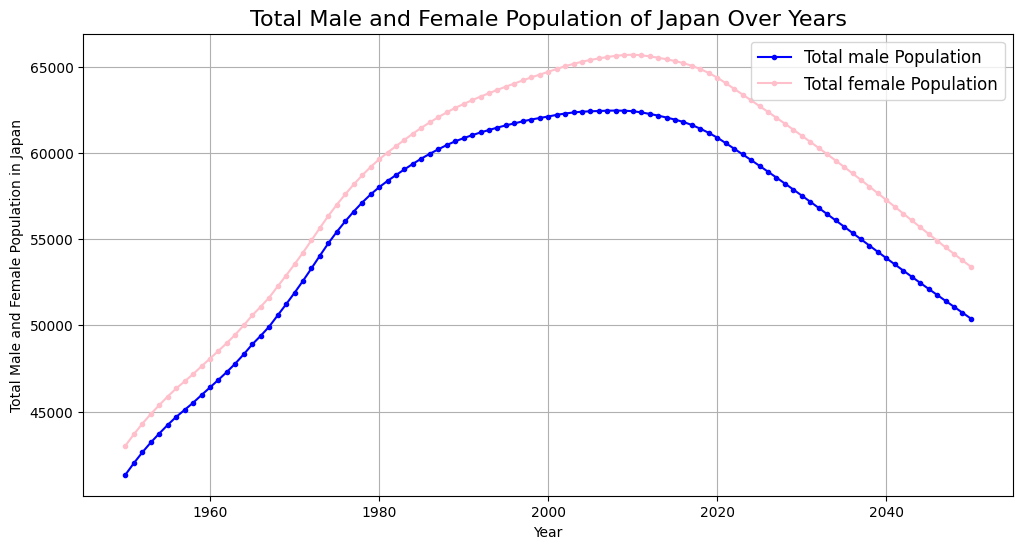

In [50]:
japan_male_df = japan_df[(japan_df['AgeClass Label'] == 'All age classes') & (japan_df['Sex Label'] == 'Male')]
print('\nMale Population\n')
japan_male_df.show(5,truncate=False)
japan_male_df.describe().show()

japan_female_df = japan_df[(japan_df['AgeClass Label'] == 'All age classes') & (japan_df['Sex Label'] == 'Female')]
print('\nFemale Population\n')
japan_female_df.show(5,truncate=False)
japan_female_df.describe().show()

# Convert to Pandas DataFrame for visualization
japan_male_pd = japan_male_df.toPandas()
japan_female_pd = japan_female_df.toPandas()

# Plot total population over years
plt.figure(figsize=(12, 6))
plt.plot(japan_male_pd["Year"], japan_male_pd["Absolute value in thousands"], marker='.', linestyle='-', color='blue', label='Total male Population')
plt.plot(japan_female_pd["Year"], japan_female_pd["Absolute value in thousands"], marker='.', linestyle='-', color='pink', label='Total female Population')
plt.xlabel("Year")
plt.ylabel("Total Male and Female Population in Japan")
plt.title("Total Male and Female Population of Japan Over Years", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

plt.show()

### population Pyramids

* total population by age in 1950/ 2021 / 2050
* population pyramids in 1950/ 2021 / 2050
* combined male and female population Pyramids in 1950/ 2021 / 2050

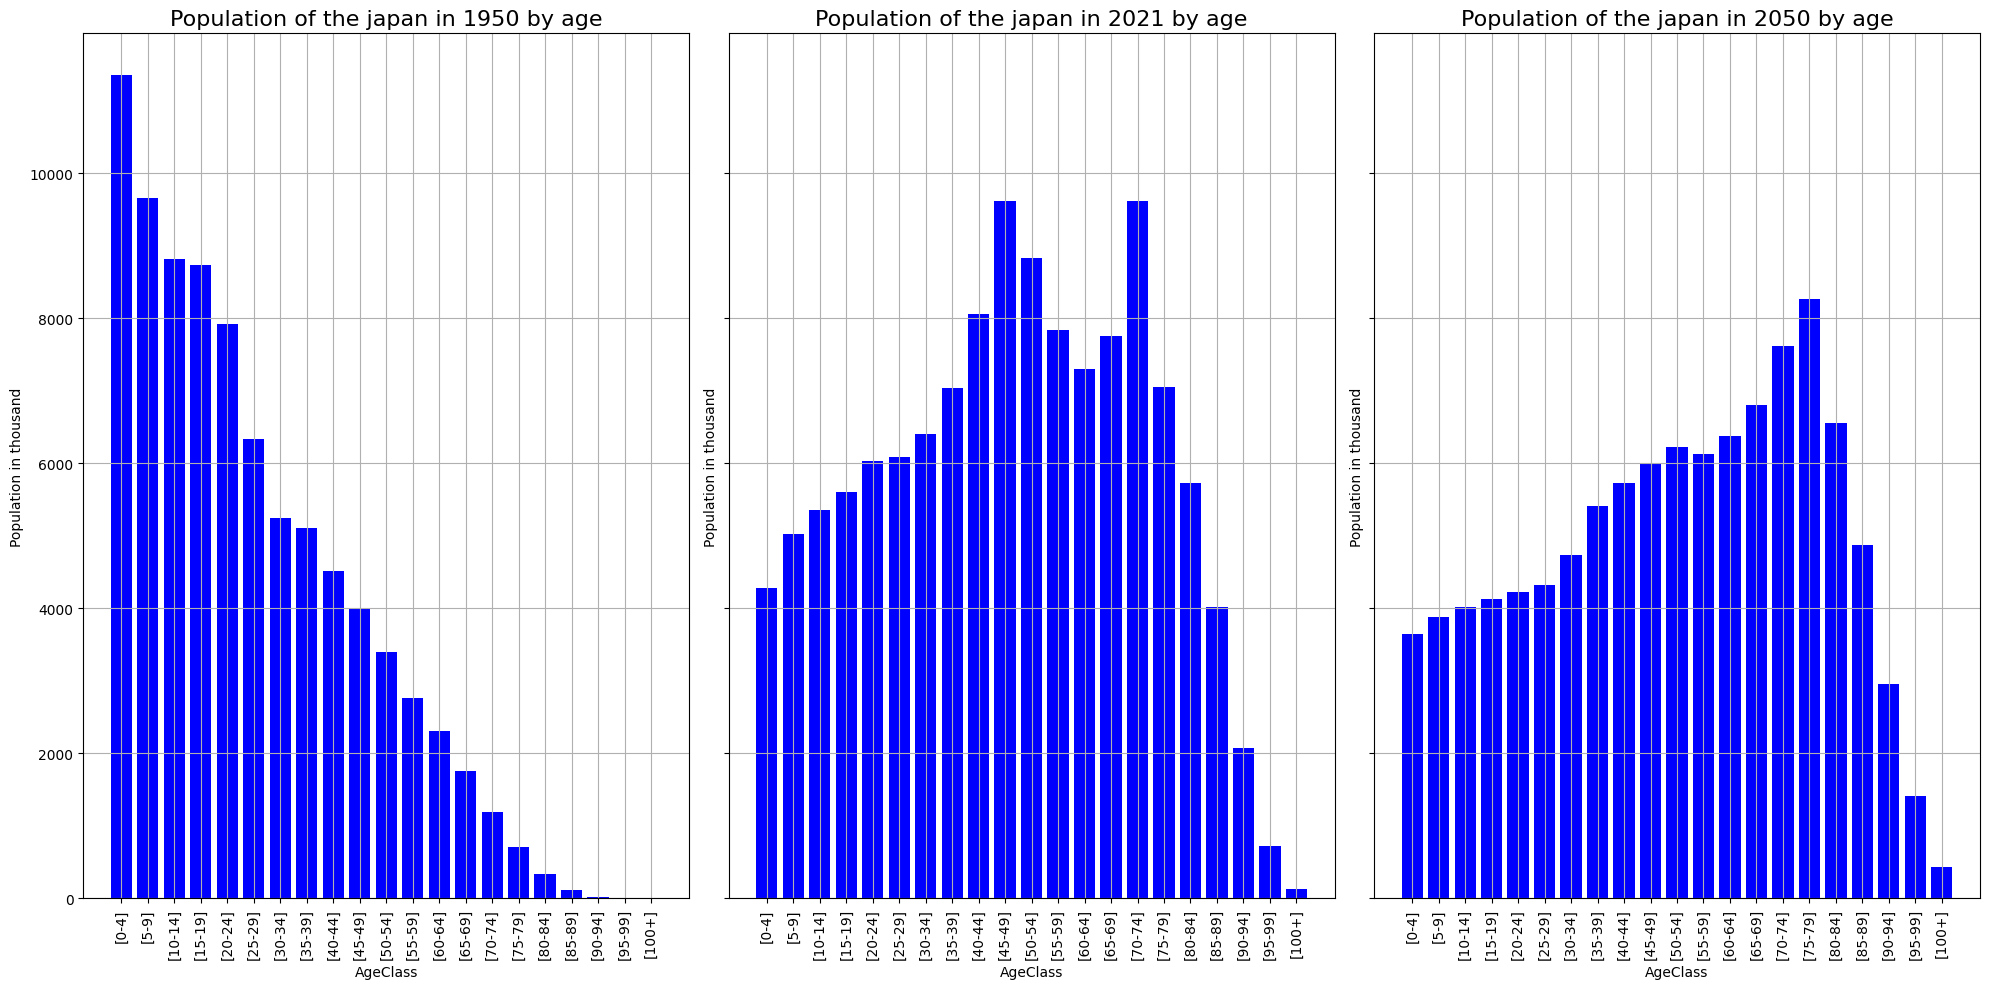

In [51]:
japan_all_agewise_1950_df = japan_df.filter((japan_df['Year'] == '1950') & (japan_df['Sex Label'] == 'Both sexes') & (japan_df['AgeClass'] != '0'))
japan_all_agewise_2021_df = japan_df.filter((japan_df['Year'] == '2021') & (japan_df['Sex Label'] == 'Both sexes') & (japan_df['AgeClass'] != '0'))
japan_all_agewise_2050_df = japan_df.filter((japan_df['Year'] == '2050') & (japan_df['Sex Label'] == 'Both sexes') & (japan_df['AgeClass'] != '0'))

# Convert to Pandas DataFrame for visualization
japan_all_agewise_1950_pd = japan_all_agewise_1950_df.toPandas()
japan_all_agewise_2021_pd = japan_all_agewise_2021_df.toPandas()
japan_all_agewise_2050_pd = japan_all_agewise_2050_df.toPandas()

# Plotting side by side
fig, axes = plt.subplots(1, 3, figsize=(20, 10), sharey=True)

# Plot total population over years
#plt.figure(figsize=(12, 6))

# Plot for 1950
axes[0].bar(japan_all_agewise_1950_pd["AgeClass Label"], japan_all_agewise_1950_pd["Absolute value in thousands"],  color='blue')
axes[0].set_xlabel("AgeClass")
axes[0].set_ylabel("Population in thousand")
axes[0].set_title("Population of the japan in 1950 by age", fontsize=16)
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=90)  # Rotate labels

# Plot for 2021
axes[1].bar(japan_all_agewise_2021_pd["AgeClass Label"], japan_all_agewise_2021_pd["Absolute value in thousands"],  color='blue')
axes[1].set_xlabel("AgeClass")
axes[1].set_ylabel("Population in thousand")
axes[1].set_title("Population of the japan in 2021 by age", fontsize=16)
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=90)  # Rotate labels

# Plot for 2050
axes[2].bar(japan_all_agewise_2050_pd["AgeClass Label"], japan_all_agewise_2050_pd["Absolute value in thousands"],  color='blue')
axes[2].set_xlabel("AgeClass")
axes[2].set_ylabel("Population in thousand")
axes[2].set_title("Population of the japan in 2050 by age", fontsize=16)
axes[2].grid(True)
axes[2].tick_params(axis='x', rotation=90)  # Rotate labels

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

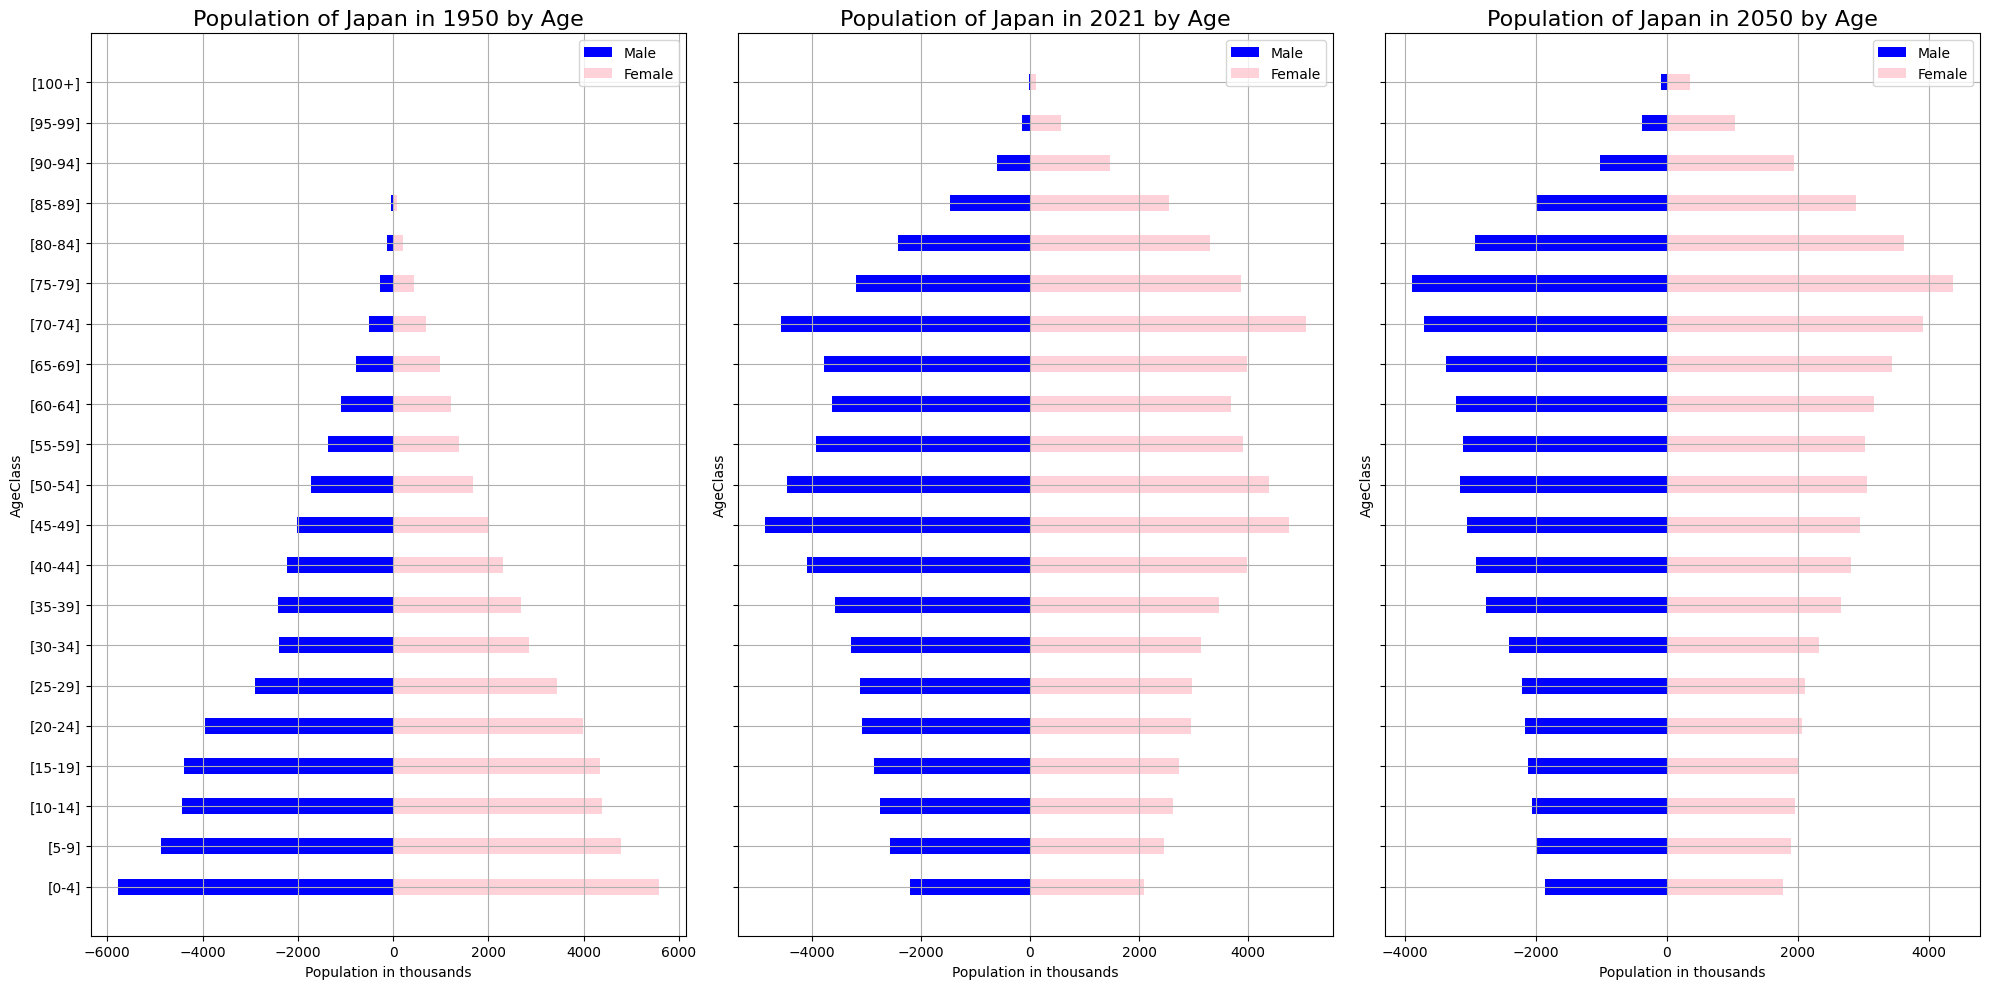

In [52]:


# Japan Male Population by Age
japan_male_agewise_1950_df = japan_df.filter((japan_df['Year'] == '1950') & (japan_df['Sex Label'] == 'Male') & (japan_df['AgeClass'] != '0'))
japan_male_agewise_2021_df = japan_df.filter((japan_df['Year'] == '2021') & (japan_df['Sex Label'] == 'Male') & (japan_df['AgeClass'] != '0'))
japan_male_agewise_2050_df = japan_df.filter((japan_df['Year'] == '2050') & (japan_df['Sex Label'] == 'Male') & (japan_df['AgeClass'] != '0'))

# Japan Female Population by Age
japan_female_agewise_1950_df = japan_df.filter((japan_df['Year'] == '1950') & (japan_df['Sex Label'] == 'Female') & (japan_df['AgeClass'] != '0'))
japan_female_agewise_2021_df = japan_df.filter((japan_df['Year'] == '2021') & (japan_df['Sex Label'] == 'Female') & (japan_df['AgeClass'] != '0'))
japan_female_agewise_2050_df = japan_df.filter((japan_df['Year'] == '2050') & (japan_df['Sex Label'] == 'Female') & (japan_df['AgeClass'] != '0'))

# Convert to Pandas DataFrame for visualization
japan_male_agewise_1950_pd = japan_male_agewise_1950_df.toPandas()
japan_male_agewise_2021_pd = japan_male_agewise_2021_df.toPandas()
japan_male_agewise_2050_pd = japan_male_agewise_2050_df.toPandas()

japan_female_agewise_1950_pd = japan_female_agewise_1950_df.toPandas()
japan_female_agewise_2021_pd = japan_female_agewise_2021_df.toPandas()
japan_female_agewise_2050_pd = japan_female_agewise_2050_df.toPandas()

# Plotting side by side
fig, axes = plt.subplots(1, 3, figsize=(20, 10), sharey=True)

# Function to plot population pyramid for a given year
def plot_population_pyramid(ax, male_pd, female_pd, year):
    bar_width = 0.4
    age_classes = male_pd["AgeClass Label"]
    male_population = -male_pd["Absolute value in thousands"]  # Negative for left side
    female_population = female_pd["Absolute value in thousands"]

    ax.barh(age_classes, male_population, bar_width, label='Male', color='blue')
    ax.barh(age_classes, female_population, bar_width, label='Female', color='pink', alpha=0.7)

    ax.set_xlabel("Population in thousands")
    ax.set_ylabel("AgeClass")
    ax.set_title(f"Population of Japan in {year} by Age", fontsize=16)
    ax.grid(True)
    ax.legend()

# Plot for 1950
plot_population_pyramid(axes[0], japan_male_agewise_1950_pd, japan_female_agewise_1950_pd, 1950)
# Plot for 2021
plot_population_pyramid(axes[1], japan_male_agewise_2021_pd, japan_female_agewise_2021_pd, 2021)
# Plot for 2050
plot_population_pyramid(axes[2], japan_male_agewise_2050_pd, japan_female_agewise_2050_pd, 2050)

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


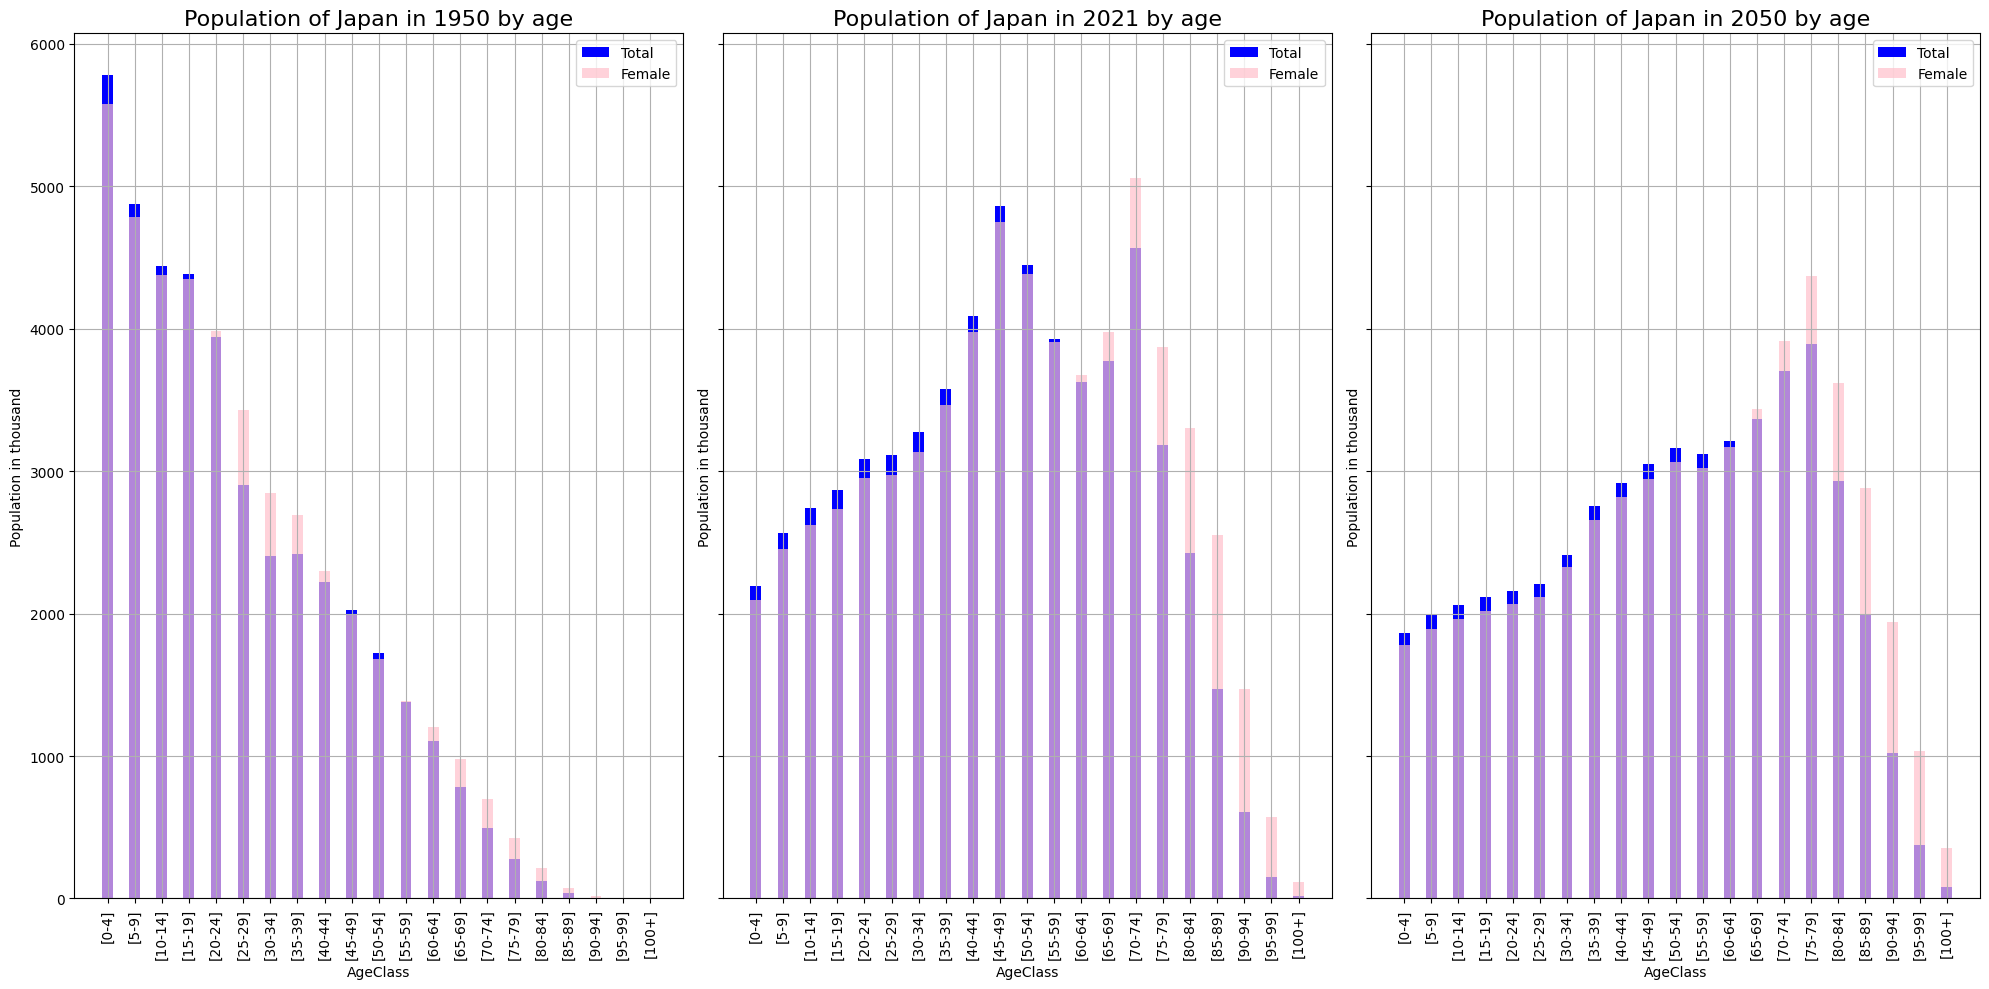

In [53]:


# Japan Male Population by Age
japan_male_agewise_1950_df = japan_df.filter((japan_df['Year'] == '1950') & (japan_df['Sex Label'] == 'Male') & (japan_df['AgeClass'] != '0'))
japan_male_agewise_2021_df = japan_df.filter((japan_df['Year'] == '2021') & (japan_df['Sex Label'] == 'Male') & (japan_df['AgeClass'] != '0'))
japan_male_agewise_2050_df = japan_df.filter((japan_df['Year'] == '2050') & (japan_df['Sex Label'] == 'Male') & (japan_df['AgeClass'] != '0'))

# Convert to Pandas DataFrame for visualization
japan_male_agewise_1950_pd = japan_male_agewise_1950_df.toPandas()
japan_male_agewise_2021_pd = japan_male_agewise_2021_df.toPandas()
japan_male_agewise_2050_pd = japan_male_agewise_2050_df.toPandas()

# Japan Female Population by Age
japan_female_agewise_1950_df = japan_df.filter((japan_df['Year'] == '1950') & (japan_df['Sex Label'] == 'Female') & (japan_df['AgeClass'] != '0'))
japan_female_agewise_2021_df = japan_df.filter((japan_df['Year'] == '2021') & (japan_df['Sex Label'] == 'Female') & (japan_df['AgeClass'] != '0'))
japan_female_agewise_2050_df = japan_df.filter((japan_df['Year'] == '2050') & (japan_df['Sex Label'] == 'Female') & (japan_df['AgeClass'] != '0'))

# Convert to Pandas DataFrame for visualization
japan_female_agewise_1950_pd = japan_female_agewise_1950_df.toPandas()
japan_female_agewise_2021_pd = japan_female_agewise_2021_df.toPandas()
japan_female_agewise_2050_pd = japan_female_agewise_2050_df.toPandas()


# Plotting side by side
fig, axes = plt.subplots(1, 3, figsize=(20, 10), sharey=True)

# Function to plot population pyramid for a given year
def plot_population_pyramid(ax, male_pd, female_pd, year):
    bar_width = 0.4
    age_classes = male_pd["AgeClass Label"]
    total_population = male_pd["Absolute value in thousands"]
    female_population = female_pd["Absolute value in thousands"]

    ax.bar(age_classes, total_population, bar_width, label='Total', color='blue')
    ax.bar(age_classes, female_population, bar_width, label='Female', color='pink', alpha=0.7)

    ax.set_xlabel("AgeClass")
    ax.set_ylabel("Population in thousand")
    ax.set_title(f"Population of Japan in {year} by age", fontsize=16)
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)  # Rotate labels
    ax.legend()

# Plot for 1950
plot_population_pyramid(axes[0], japan_male_agewise_1950_pd, japan_female_agewise_1950_pd, 1950)

# Plot for 2021
plot_population_pyramid(axes[1], japan_male_agewise_2021_pd, japan_female_agewise_2021_pd, 2021)

# Plot for 2050
plot_population_pyramid(axes[2], japan_male_agewise_2050_pd, japan_female_agewise_2050_pd, 2050)

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

### variation of total population by age group over the year

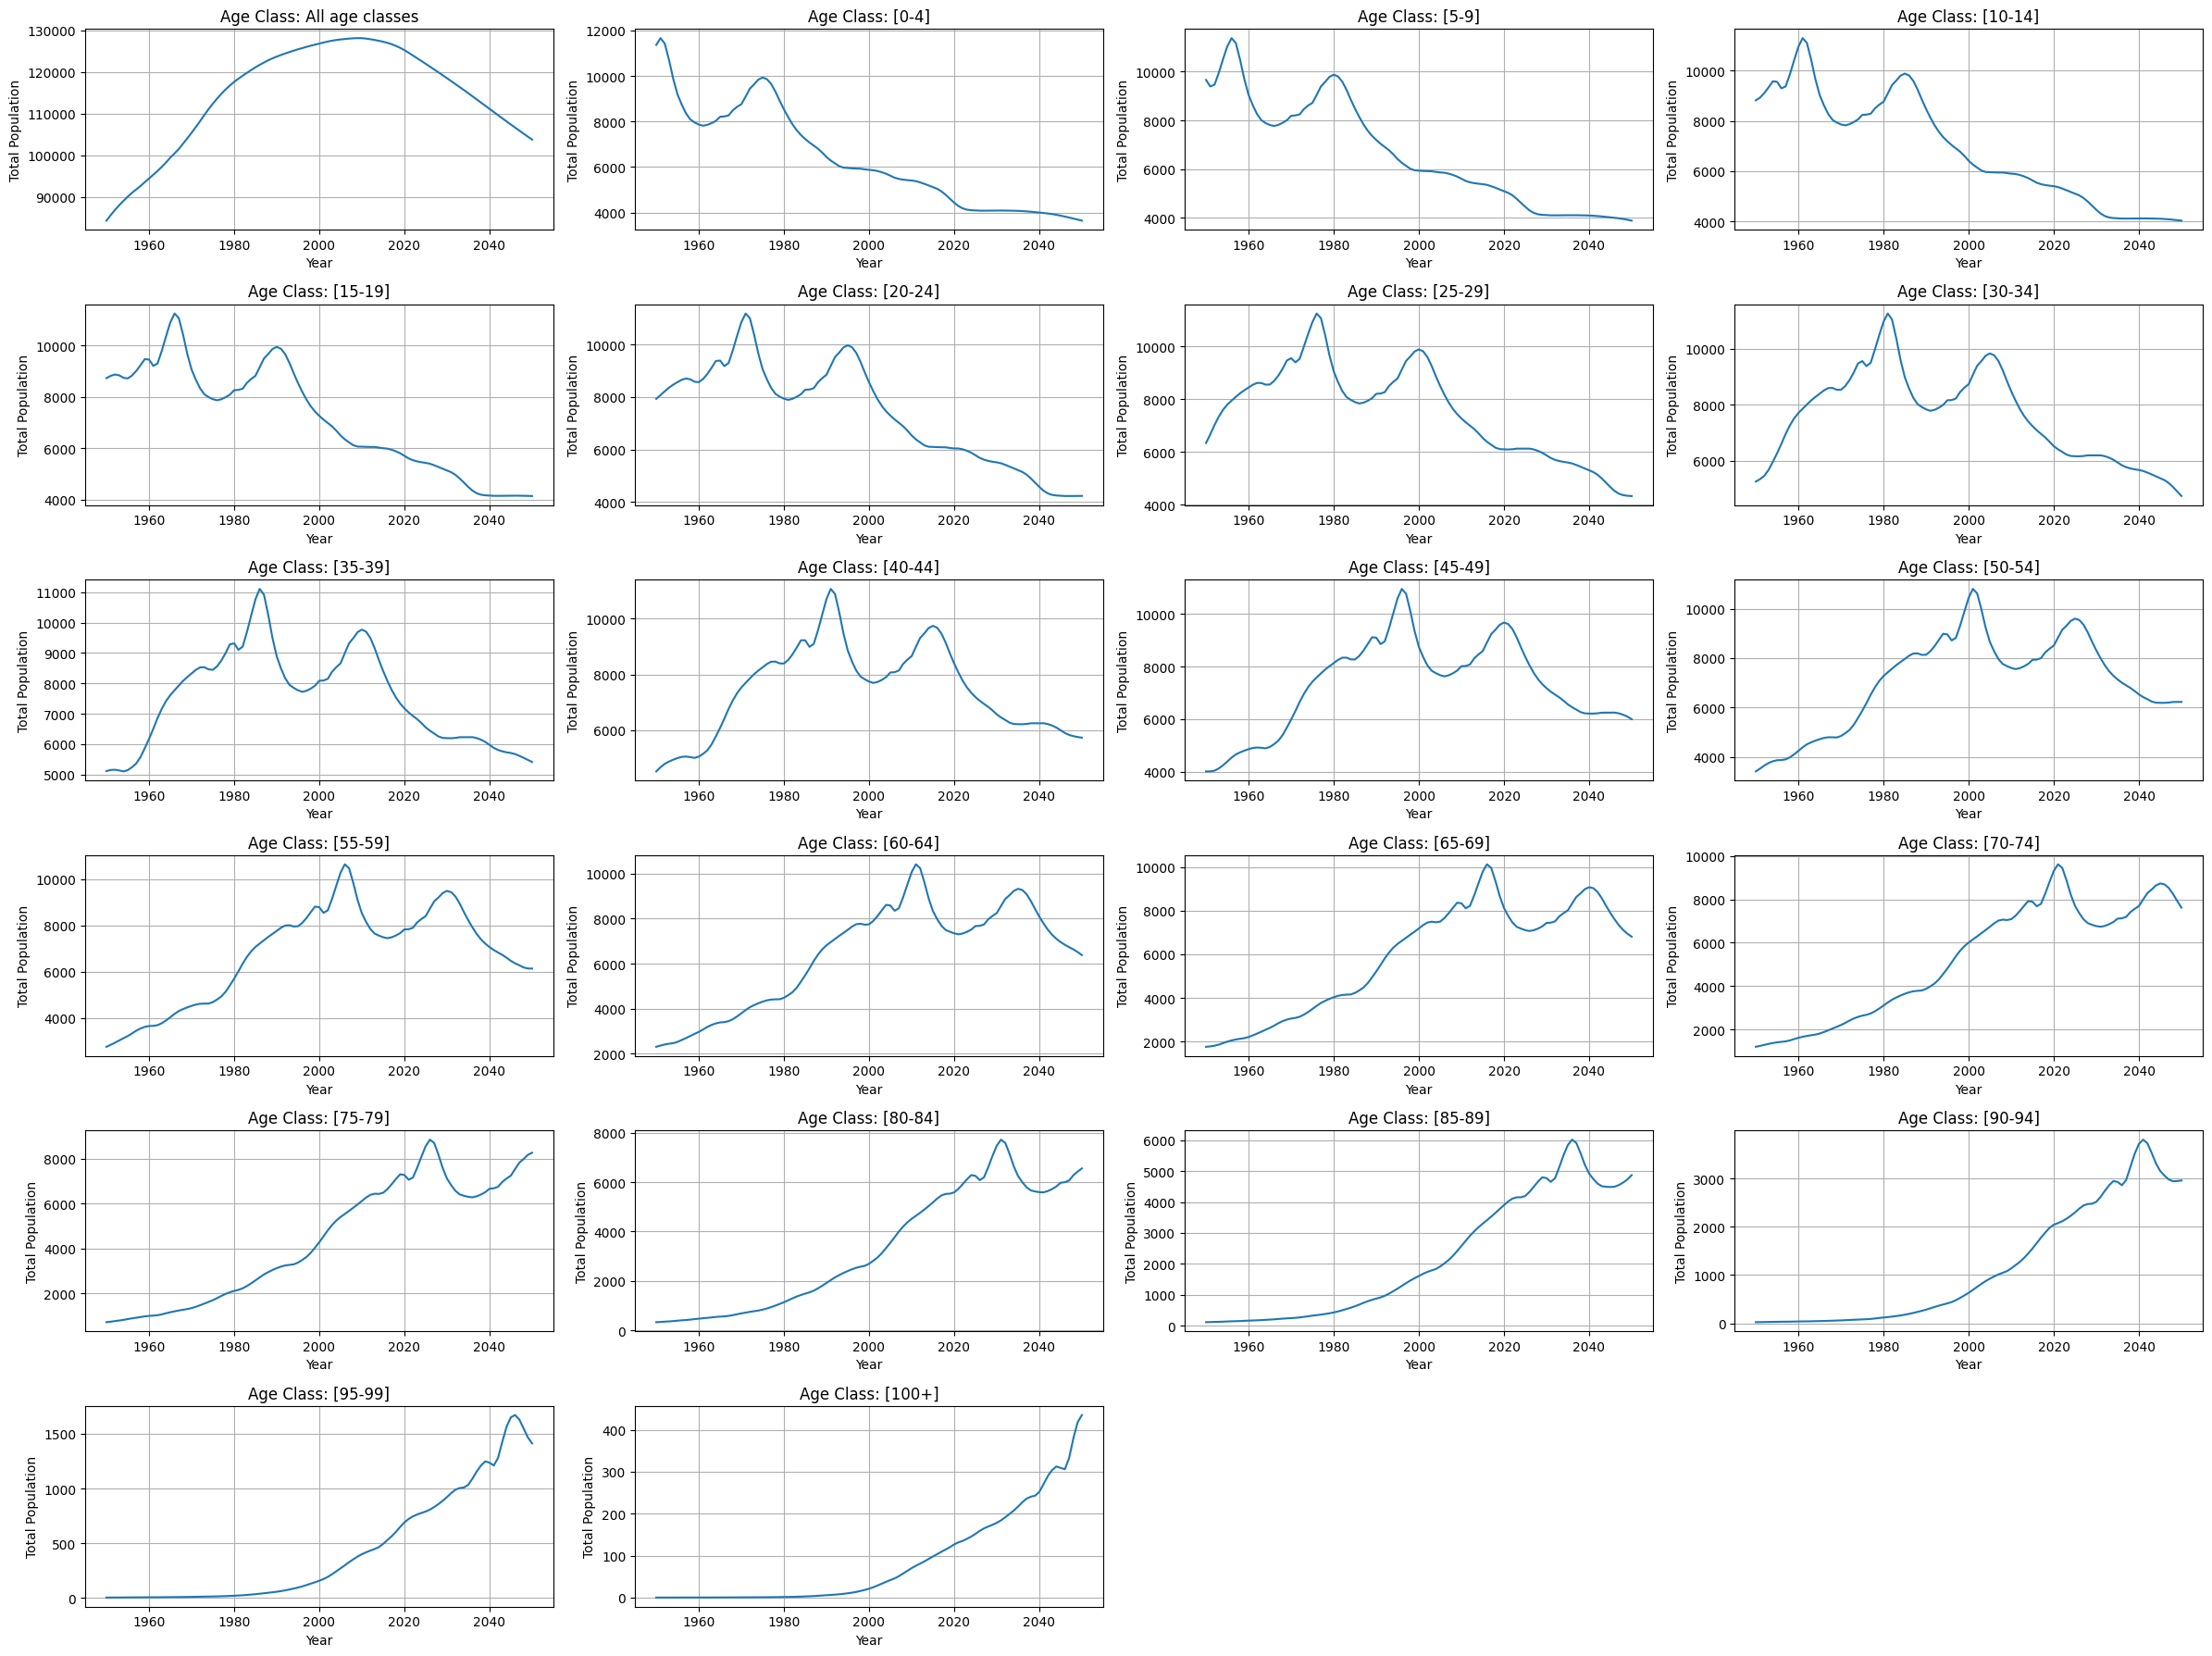

In [54]:
ageClass_labels = ['All age classes',	'[0-4]', '[5-9]', '[10-14]', '[15-19]', '[20-24]' , 	'[25-29]' , 	'[30-34]' , 	'[35-39]' , 	'[40-44]' , 	'[45-49]' , 	'[50-54]' , 	'[55-59]' , 	'[60-64]' , 	'[65-69]' , 	'[70-74]' , 	'[75-79]' , 	'[80-84]' , 	'[85-89]' , 	'[90-94]' , 	'[95-99]' , 	'[100+]']
ageClass_codes = sorted(japan_df.select("AgeClass").distinct().rdd.flatMap(lambda x: x).collect())
age_class_mapping = dict(zip(ageClass_codes, ageClass_labels))

fig, axs = plt.subplots(6, 4, figsize=(24, 18))
axs = axs.flatten()  # Flatten the array for easier indexing

for i, code in enumerate(ageClass_codes):
    ageClass_df = japan_df.filter((japan_df['AgeClass'] == code) & (japan_df['Sex Label'] == 'Both sexes'))
    ageClass_pd = ageClass_df.toPandas()


    if ageClass_pd.empty:
        continue

    age_class = age_class_mapping.get(code, "Label not found")

    axs[i].plot(ageClass_pd['Year'], ageClass_pd['Absolute value in thousands'])
    axs[i].set_xlabel("Year")
    axs[i].set_ylabel("Total Population")
    axs[i].set_title(f"Age Class: {age_class}")
    axs[i].grid(True)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

### variation of male and female total population by age group over the year

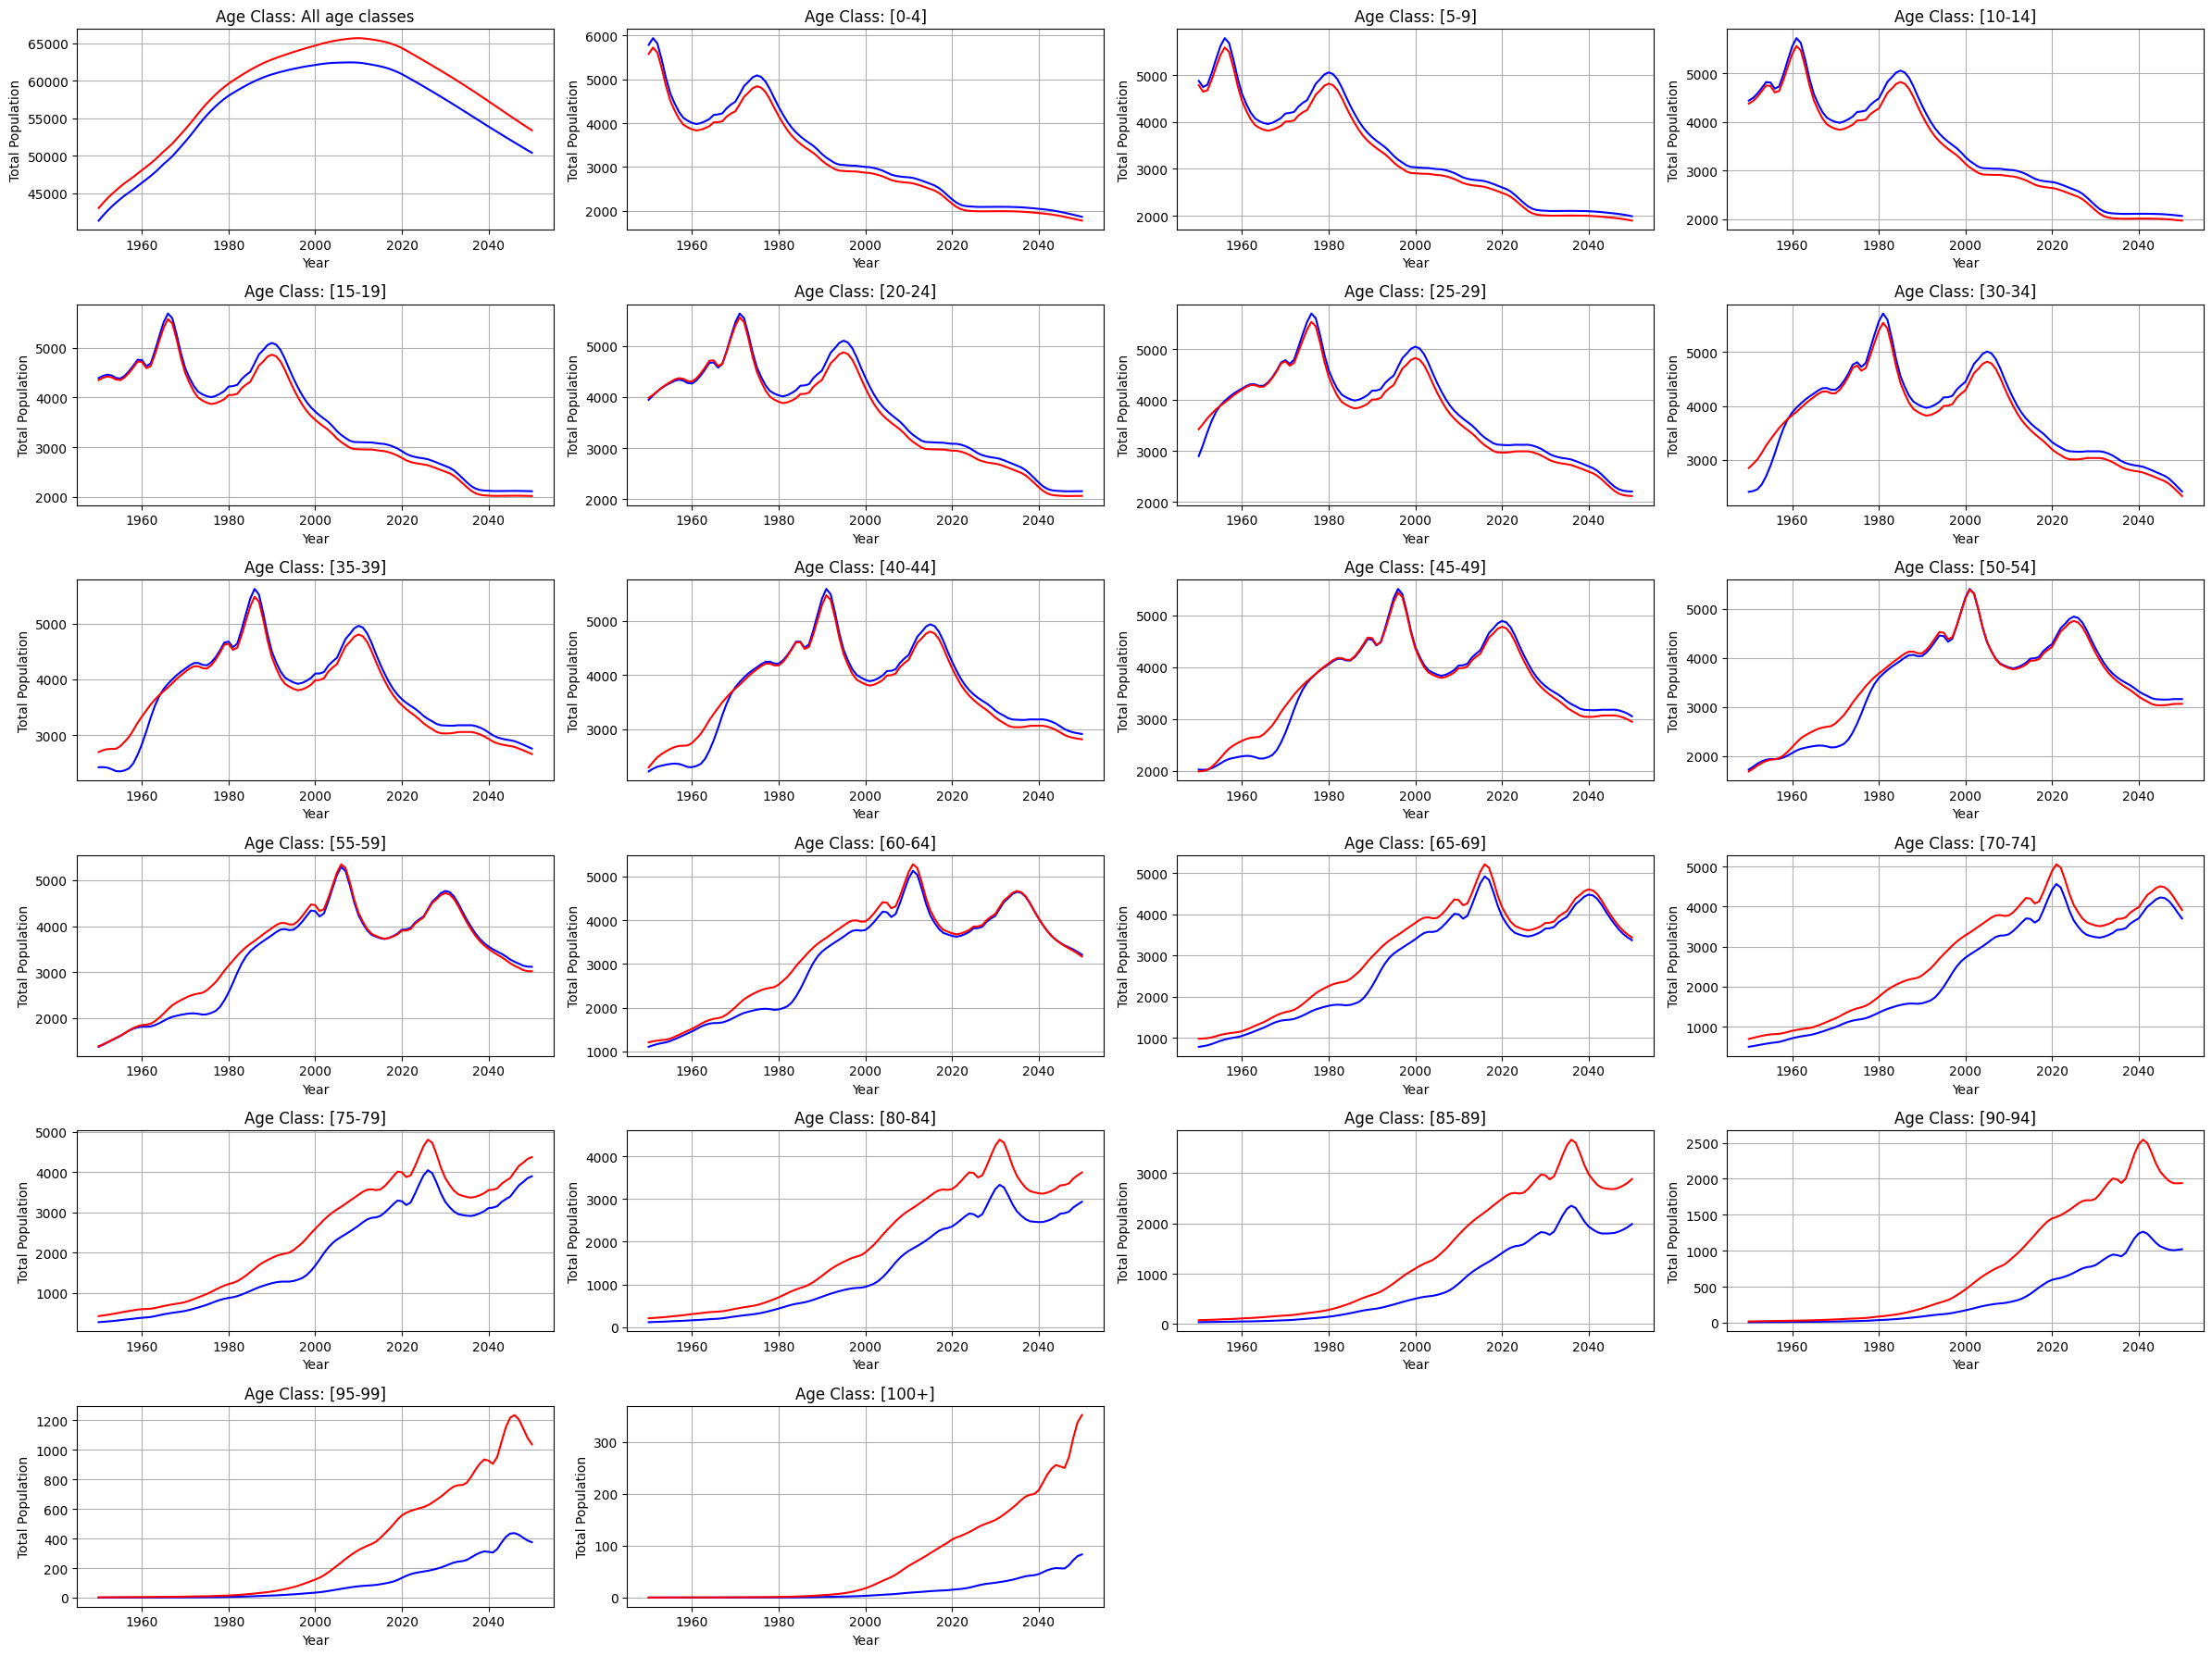

In [55]:
ageClass_labels = ['All age classes',	'[0-4]', '[5-9]', '[10-14]', '[15-19]', '[20-24]' , 	'[25-29]' , 	'[30-34]' , 	'[35-39]' , 	'[40-44]' , 	'[45-49]' , 	'[50-54]' , 	'[55-59]' , 	'[60-64]' , 	'[65-69]' , 	'[70-74]' , 	'[75-79]' , 	'[80-84]' , 	'[85-89]' , 	'[90-94]' , 	'[95-99]' , 	'[100+]']
ageClass_codes = sorted(japan_df.select("AgeClass").distinct().rdd.flatMap(lambda x: x).collect())
age_class_mapping = dict(zip(ageClass_codes, ageClass_labels))

fig, axs = plt.subplots(6, 4, figsize=(24, 18))
axs = axs.flatten()  # Flatten the array for easier indexing

for i, code in enumerate(ageClass_codes):
    ageClass_male_df = japan_df.filter((japan_df['AgeClass'] == code) & (japan_df['Sex Label'] == 'Male'))
    ageClass_female_df = japan_df.filter((japan_df['AgeClass'] == code) & (japan_df['Sex Label'] == 'Female'))
    male_pd = ageClass_male_df.toPandas()
    female_pd = ageClass_female_df.toPandas()


    if ageClass_pd.empty:
        continue

    age_class = age_class_mapping.get(code, "Label not found")

    axs[i].plot(male_pd['Year'], male_pd['Absolute value in thousands'], color = 'blue', label = 'male')
    axs[i].plot(female_pd['Year'], female_pd['Absolute value in thousands'], color = 'red', label = 'female')
    axs[i].set_xlabel("Year")
    axs[i].set_ylabel("Total Population")
    axs[i].set_title(f"Age Class: {age_class}")
    axs[i].grid(True)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

### Percentage of Population Above Sixty Over the Years in the japan

+----+---------------+---------------------------+
|Year|AgeClass Label |Absolute value in thousands|
+----+---------------+---------------------------+
|1950|All age classes|84353.049                  |
|1950|[0-4]          |11364.999                  |
|1950|[5-9]          |9661.579                   |
|1950|[10-14]        |8819.623                   |
|1950|[15-19]        |8735.657                   |
+----+---------------+---------------------------+
only showing top 5 rows

+----+---------------+---------------------------+
|Year|AgeClass Label |Absolute value in thousands|
+----+---------------+---------------------------+
|1950|Above Sixty    |6437.554000000001          |
|1950|All age classes|84353.049                  |
|1950|[0-4]          |11364.999                  |
|1950|[5-9]          |9661.579                   |
|1950|[10-14]        |8819.623                   |
+----+---------------+---------------------------+
only showing top 5 rows

+----+---------------+----------

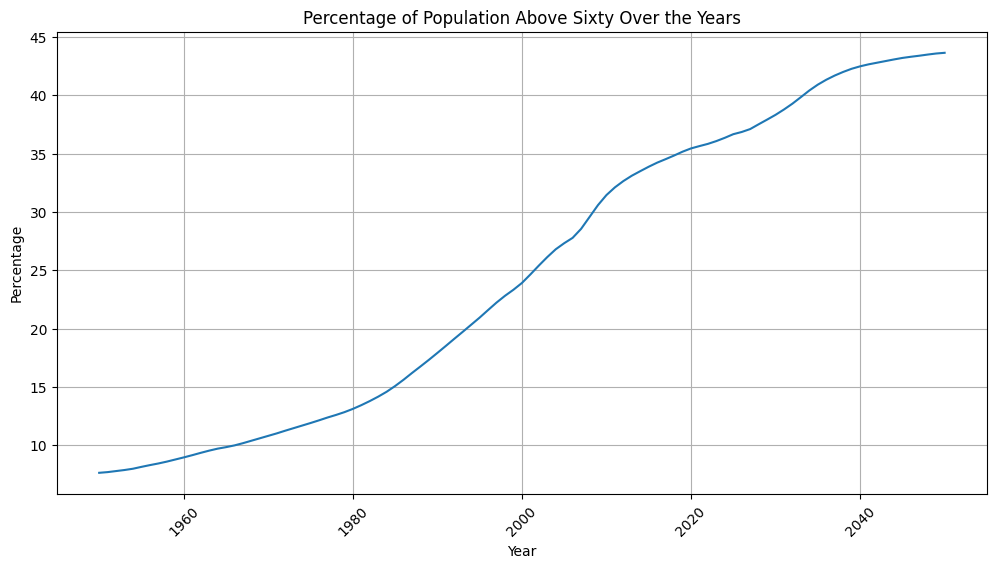

In [56]:
japan_df = df_cleaned[(df_cleaned['Economy Label'] == 'Japan') & (df_cleaned['Sex Label'] == 'Both sexes')]
japan_df = japan_df[['Year', 'AgeClass Label', 'Absolute value in thousands']]
japan_df.show(5,truncate=False)

# Filter for AgeClass_Label above 60 and group by year to sum the Absolute value
temp_df = japan_df.filter(japan_df["AgeClass Label"].isin(['[60-64]', '[65-69]' ,	'[70-74]' ,	'[75-79]' ,	'[80-84]' ,	'[85-89]' ,	'[90-94]', '[95-99]',	'[100+]'])).groupBy("Year").agg(
    spark_sum("Absolute value in thousands").alias("Value")
)

# Add the new AgeClass_Label
temp_df = temp_df.withColumn("AgeClass Label", lit("Above Sixty"))

# Select columns in the correct order
temp_df = temp_df.select("Year", "AgeClass Label", "Value")

# Combine the original DataFrame with the new rows
japan_sixty_df = japan_df.union(temp_df)

# Show the result
japan_sixty_df.orderBy("Year").show(5,truncate=False)


# Filter to include only rows with AgeClass_Label All age classes and Above Sixty
japan_filtered_df = japan_sixty_df.filter(japan_sixty_df["AgeClass Label"].isin('All age classes', 'Above Sixty'))
japan_filtered_df.orderBy("Year").show(5)

# Order by year and AgeClass_Label
japan_filtered_df = japan_filtered_df.orderBy("Year", "AgeClass Label")

tt_df = japan_filtered_df.groupBy("Year").pivot("AgeClass Label").sum("Absolute value in thousands")
tt_df.orderBy("Year").show(5)

percentage_df = tt_df.withColumn("Percentage", round((tt_df['Above Sixty'] * 100)/ tt_df['All age classes'], 2))
percentage_df.select("Year","Percentage").orderBy("Year").show(5)
percentage_df.describe().show()


# Convert Spark DataFrame to Pandas DataFrame
percentage_pd_df = percentage_df.toPandas()

# Sort the Pandas DataFrame by 'Year'
percentage_pd_df = percentage_pd_df.sort_values(by='Year')

# Plot the percentage over the years
plt.figure(figsize=(12, 6))
plt.plot(percentage_pd_df['Year'], percentage_pd_df['Percentage'])
plt.title('Percentage of Population Above Sixty Over the Years')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


### Percentage of Workforce Over the Years in the japan

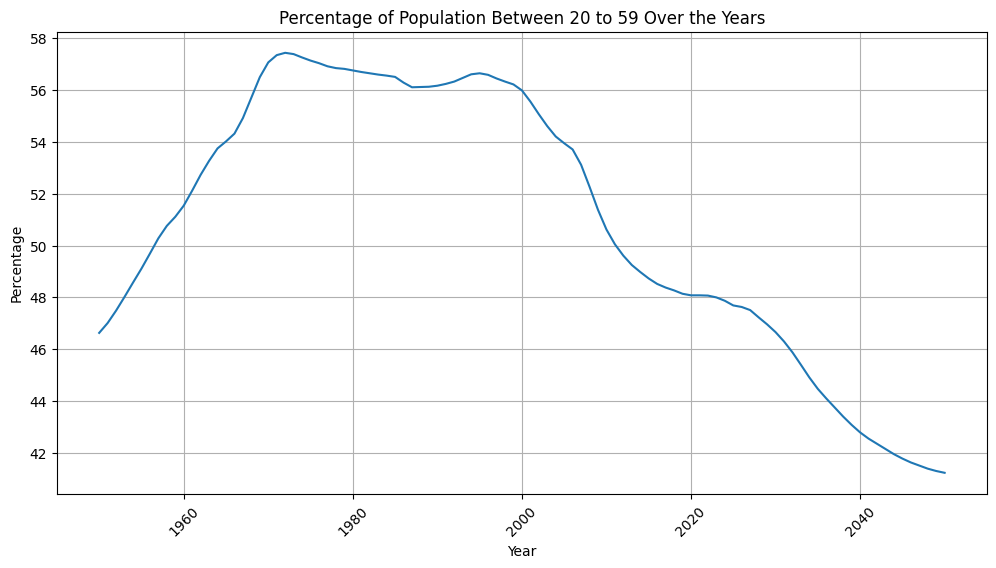

In [57]:
# Filter for AgeClass_Label above 60 and group by year to sum the Absolute value
temp_df = japan_df.filter(japan_df["AgeClass Label"].isin(['[20-24]' , 	'[25-29]' , 	'[30-34]' , 	'[35-39]' , 	'[40-44]' , 	'[45-49]' , 	'[50-54]' , 	'[55-59]'])).groupBy("Year").agg(
    spark_sum("Absolute value in thousands").alias("Value")
)

# Add the new AgeClass_Label
temp_df = temp_df.withColumn("AgeClass Label", lit("Above Sixty"))

# Select columns in the correct order
temp_df = temp_df.select("Year", "AgeClass Label", "Value")

# Combine the original DataFrame with the new rows
japan_sixty_df = japan_df.union(temp_df)

# Filter to include only rows with AgeClass_Label All age classes and Above Sixty
japan_filtered_df = japan_sixty_df.filter(japan_sixty_df["AgeClass Label"].isin('All age classes', 'Above Sixty'))

# Order by year and AgeClass_Label
japan_filtered_df = japan_filtered_df.orderBy("Year", "AgeClass Label")

tt_df = japan_filtered_df.groupBy("Year").pivot("AgeClass Label").sum("Absolute value in thousands")

percentage_df = tt_df.withColumn("Percentage", round((tt_df['Above Sixty'] * 100)/ tt_df['All age classes'], 2))

# Convert Spark DataFrame to Pandas DataFrame
percentage_pd_df = percentage_df.toPandas()

# Sort the Pandas DataFrame by 'Year'
percentage_pd_df = percentage_pd_df.sort_values(by='Year')

# Plot the percentage over the years
plt.figure(figsize=(12, 6))
plt.plot(percentage_pd_df['Year'], percentage_pd_df['Percentage'])
plt.title('Percentage of Population Between 20 to 59 Over the Years')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### Percentage of Children Over the Years in the japan

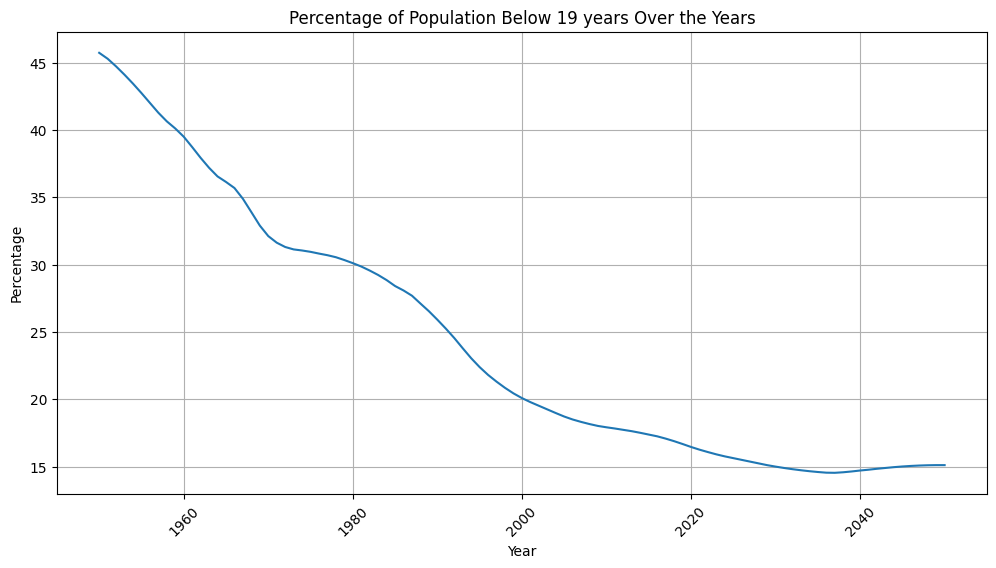

In [58]:
# Filter for AgeClass_Label above 60 and group by year to sum the Absolute value
temp_df = japan_df.filter(japan_df["AgeClass Label"].isin(['[0-4]', '[5-9]', '[10-14]', '[15-19]'])).groupBy("Year").agg(
    spark_sum("Absolute value in thousands").alias("Value")
)

# Add the new AgeClass_Label
temp_df = temp_df.withColumn("AgeClass Label", lit("Above Sixty"))

# Select columns in the correct order
temp_df = temp_df.select("Year", "AgeClass Label", "Value")

# Combine the original DataFrame with the new rows
japan_sixty_df = japan_df.union(temp_df)

# Filter to include only rows with AgeClass_Label All age classes and Above Sixty
japan_filtered_df = japan_sixty_df.filter(japan_sixty_df["AgeClass Label"].isin('All age classes', 'Above Sixty'))

# Order by year and AgeClass_Label
japan_filtered_df = japan_filtered_df.orderBy("Year", "AgeClass Label")

tt_df = japan_filtered_df.groupBy("Year").pivot("AgeClass Label").sum("Absolute value in thousands")

percentage_df = tt_df.withColumn("Percentage", round((tt_df['Above Sixty'] * 100)/ tt_df['All age classes'], 2))

# Convert Spark DataFrame to Pandas DataFrame
percentage_pd_df = percentage_df.toPandas()

# Sort the Pandas DataFrame by 'Year'
percentage_pd_df = percentage_pd_df.sort_values(by='Year')

# Plot the percentage over the years
plt.figure(figsize=(12, 6))
plt.plot(percentage_pd_df['Year'], percentage_pd_df['Percentage'])
plt.title('Percentage of Population Below 19 years Over the Years')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

## Analysing Qatar

### total population in the Qatar over the years

+----+-------+-------------+---+----------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|Year|Economy|Economy Label|Sex|Sex Label |AgeClass|AgeClass Label |Absolute value in thousands|Absolute value in thousands Footnote|Absolute value in thousands Missing value|
+----+-------+-------------+---+----------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|1950|634    |Qatar        |0  |Both sexes|0       |All age classes|24.288                     |NULL                                |NULL                                     |
|1951|634    |Qatar        |0  |Both sexes|0       |All age classes|25.093                     |NULL                                |NULL                                     |
|1952|634    |Qatar        |0  |Both sexes|0       |All age classes|25.934                     |NULL                    

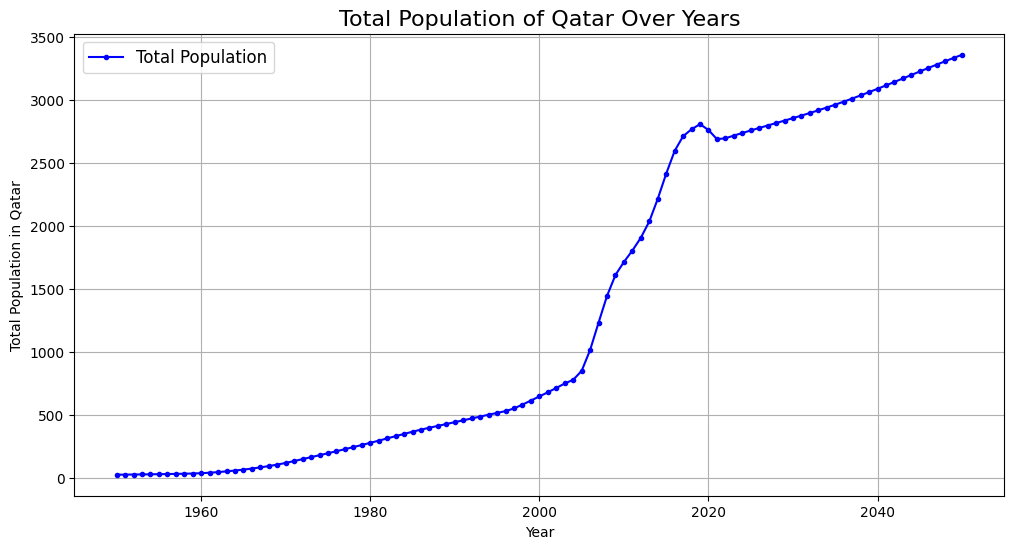

In [59]:
Qatar_df = df_cleaned.filter((df_cleaned["Economy Label"] == "Qatar"))

Qatar_all_df = Qatar_df.filter((Qatar_df['AgeClass Label'] == 'All age classes') & (Qatar_df['Sex Label'] == 'Both sexes'))
Qatar_all_df.show(5,truncate=False)
Qatar_all_df.describe().show()

# Convert to Pandas DataFrame for visualization
Qatar_all_pd = Qatar_all_df.toPandas()

# Plot total population over years
plt.figure(figsize=(12, 6))
plt.plot(Qatar_all_pd["Year"], Qatar_all_pd["Absolute value in thousands"], marker='.', linestyle='-', color='blue', label='Total Population')
plt.xlabel("Year")
plt.ylabel("Total Population in Qatar")
plt.title("Total Population of Qatar Over Years", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

plt.show()

### total male and female population over the years


Male Population

+----+-------+-------------+---+---------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|Year|Economy|Economy Label|Sex|Sex Label|AgeClass|AgeClass Label |Absolute value in thousands|Absolute value in thousands Footnote|Absolute value in thousands Missing value|
+----+-------+-------------+---+---------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|1950|634    |Qatar        |2  |Male     |0       |All age classes|12.127                     |NULL                                |NULL                                     |
|1951|634    |Qatar        |2  |Male     |0       |All age classes|12.523                     |NULL                                |NULL                                     |
|1952|634    |Qatar        |2  |Male     |0       |All age classes|12.94                      |NULL        

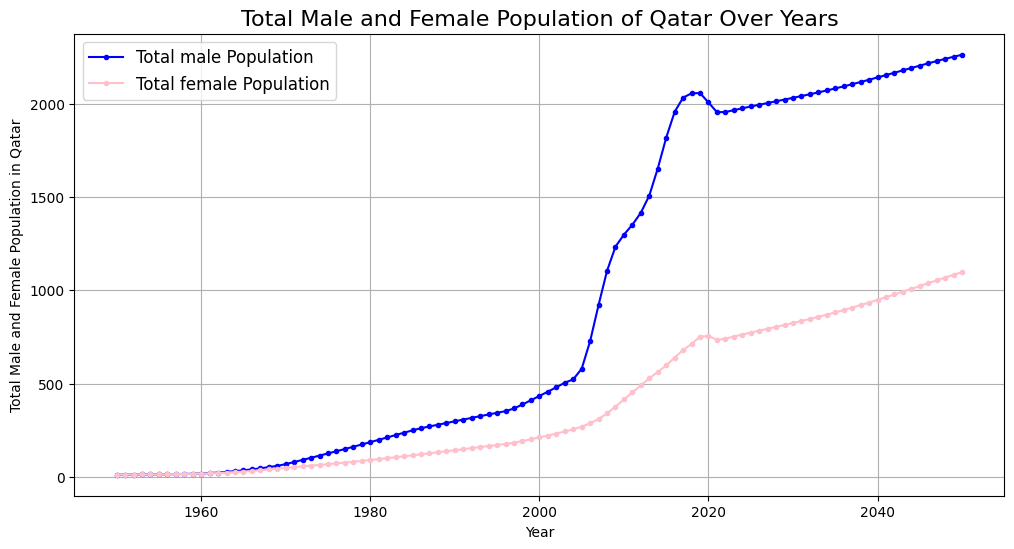

In [60]:
Qatar_male_df = Qatar_df[(Qatar_df['AgeClass Label'] == 'All age classes') & (Qatar_df['Sex Label'] == 'Male')]
print('\nMale Population\n')
Qatar_male_df.show(5,truncate=False)
Qatar_male_df.describe().show()

Qatar_female_df = Qatar_df[(Qatar_df['AgeClass Label'] == 'All age classes') & (Qatar_df['Sex Label'] == 'Female')]
print('\nFemale Population\n')
Qatar_female_df.show(5,truncate=False)
Qatar_female_df.describe().show()

# Convert to Pandas DataFrame for visualization
Qatar_male_pd = Qatar_male_df.toPandas()
Qatar_female_pd = Qatar_female_df.toPandas()

# Plot total population over years
plt.figure(figsize=(12, 6))
plt.plot(Qatar_male_pd["Year"], Qatar_male_pd["Absolute value in thousands"], marker='.', linestyle='-', color='blue', label='Total male Population')
plt.plot(Qatar_female_pd["Year"], Qatar_female_pd["Absolute value in thousands"], marker='.', linestyle='-', color='pink', label='Total female Population')
plt.xlabel("Year")
plt.ylabel("Total Male and Female Population in Qatar")
plt.title("Total Male and Female Population of Qatar Over Years", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

plt.show()

### population Pyramids

* total population by age in 1950/ 2021 / 2050
* population pyramids in 1950/ 2021 / 2050
* combined male and female population Pyramids in 1950/ 2021 / 2050

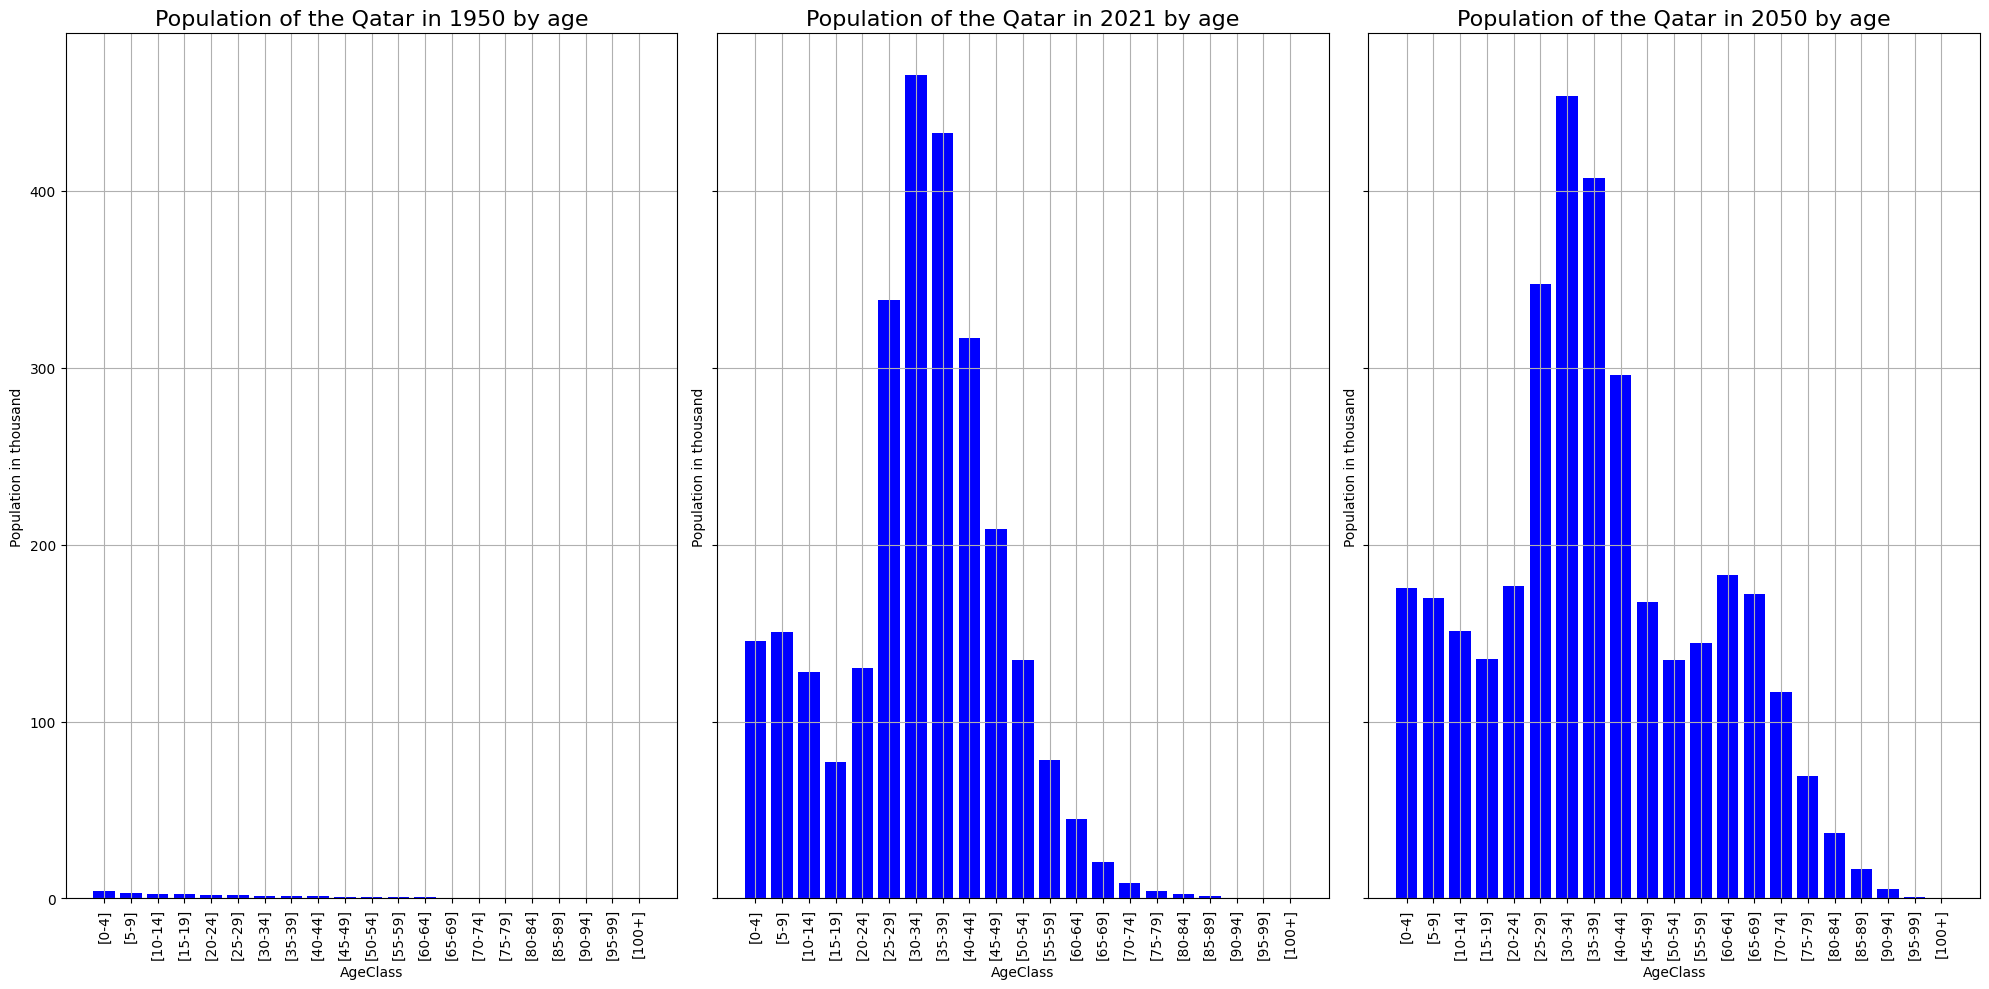

In [61]:
Qatar_all_agewise_1950_df = Qatar_df.filter((Qatar_df['Year'] == '1950') & (Qatar_df['Sex Label'] == 'Both sexes') & (Qatar_df['AgeClass'] != '0'))
Qatar_all_agewise_2021_df = Qatar_df.filter((Qatar_df['Year'] == '2021') & (Qatar_df['Sex Label'] == 'Both sexes') & (Qatar_df['AgeClass'] != '0'))
Qatar_all_agewise_2050_df = Qatar_df.filter((Qatar_df['Year'] == '2050') & (Qatar_df['Sex Label'] == 'Both sexes') & (Qatar_df['AgeClass'] != '0'))

# Convert to Pandas DataFrame for visualization
Qatar_all_agewise_1950_pd = Qatar_all_agewise_1950_df.toPandas()
Qatar_all_agewise_2021_pd = Qatar_all_agewise_2021_df.toPandas()
Qatar_all_agewise_2050_pd = Qatar_all_agewise_2050_df.toPandas()

# Plotting side by side
fig, axes = plt.subplots(1, 3, figsize=(20, 10), sharey=True)

# Plot total population over years
#plt.figure(figsize=(12, 6))

# Plot for 1950
axes[0].bar(Qatar_all_agewise_1950_pd["AgeClass Label"], Qatar_all_agewise_1950_pd["Absolute value in thousands"],  color='blue')
axes[0].set_xlabel("AgeClass")
axes[0].set_ylabel("Population in thousand")
axes[0].set_title("Population of the Qatar in 1950 by age", fontsize=16)
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=90)  # Rotate labels

# Plot for 2021
axes[1].bar(Qatar_all_agewise_2021_pd["AgeClass Label"], Qatar_all_agewise_2021_pd["Absolute value in thousands"],  color='blue')
axes[1].set_xlabel("AgeClass")
axes[1].set_ylabel("Population in thousand")
axes[1].set_title("Population of the Qatar in 2021 by age", fontsize=16)
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=90)  # Rotate labels

# Plot for 2050
axes[2].bar(Qatar_all_agewise_2050_pd["AgeClass Label"], Qatar_all_agewise_2050_pd["Absolute value in thousands"],  color='blue')
axes[2].set_xlabel("AgeClass")
axes[2].set_ylabel("Population in thousand")
axes[2].set_title("Population of the Qatar in 2050 by age", fontsize=16)
axes[2].grid(True)
axes[2].tick_params(axis='x', rotation=90)  # Rotate labels

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

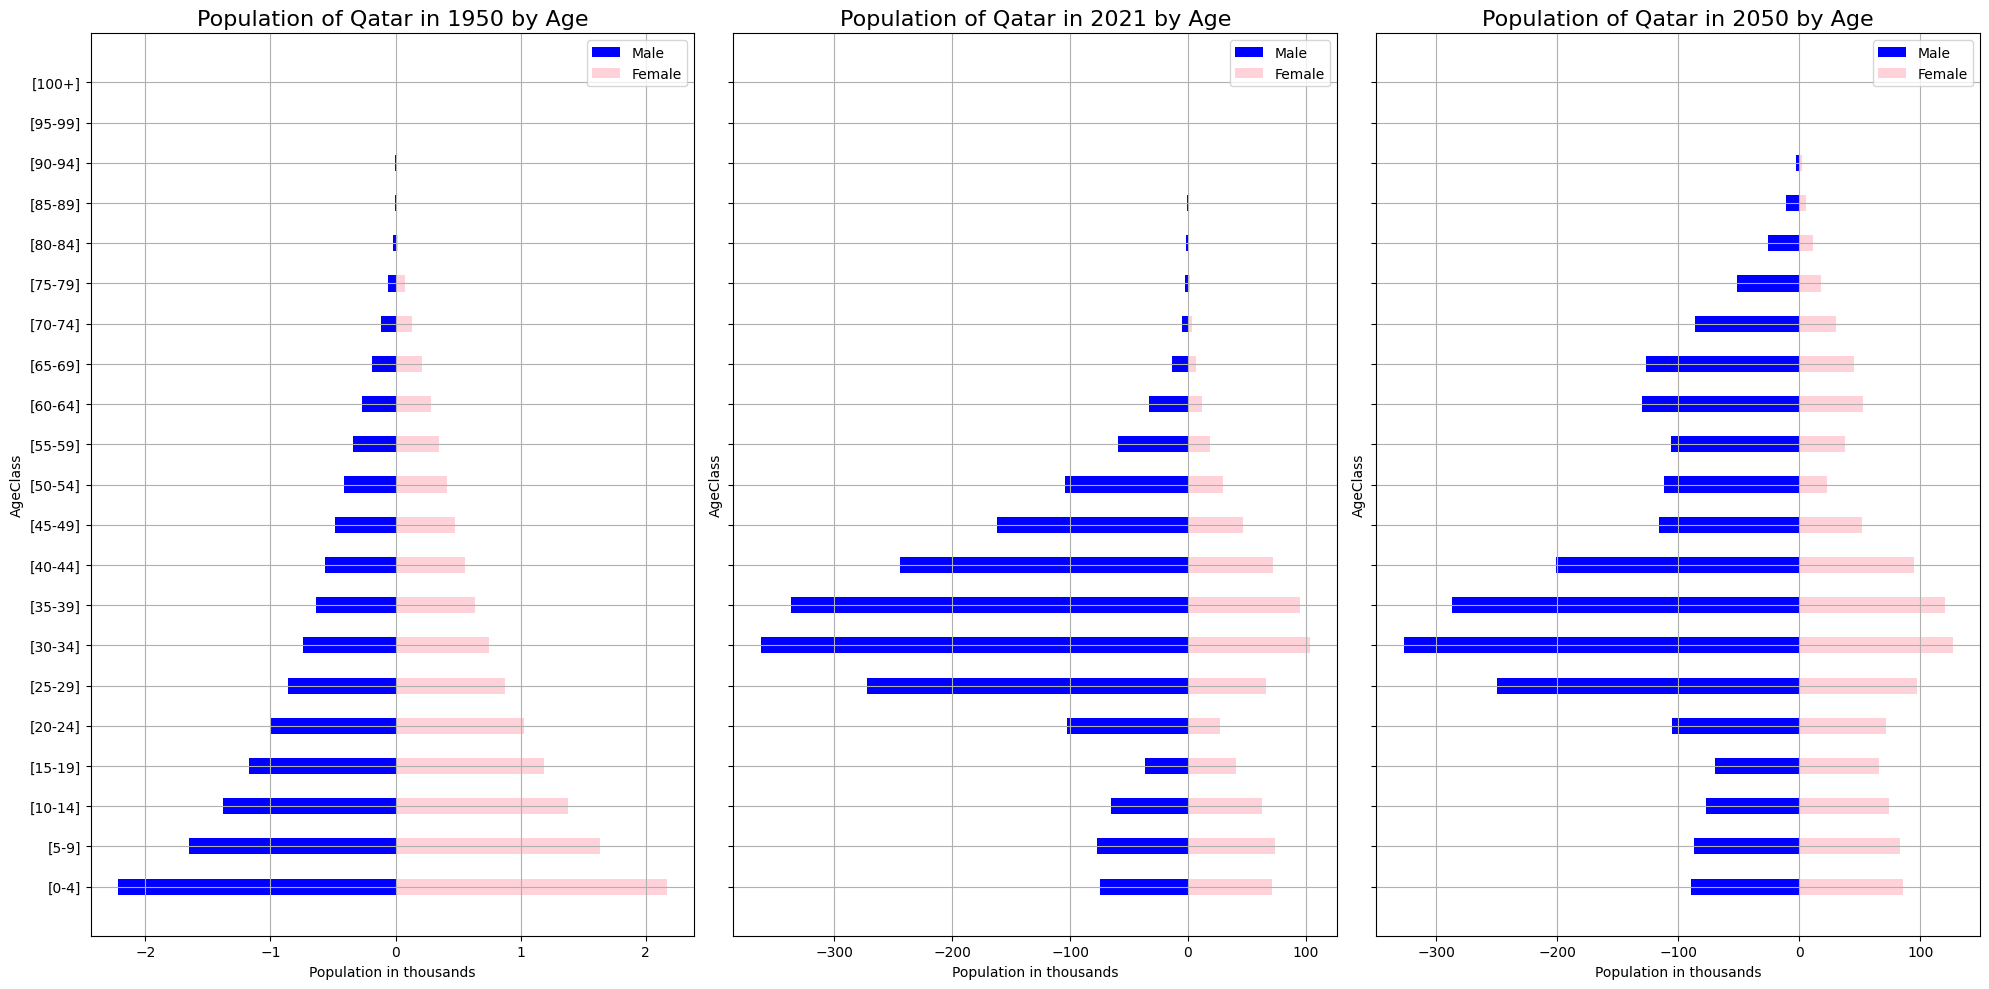

In [62]:
# Qatar Male Population by Age
Qatar_male_agewise_1950_df = Qatar_df.filter((Qatar_df['Year'] == '1950') & (Qatar_df['Sex Label'] == 'Male') & (Qatar_df['AgeClass'] != '0'))
Qatar_male_agewise_2021_df = Qatar_df.filter((Qatar_df['Year'] == '2021') & (Qatar_df['Sex Label'] == 'Male') & (Qatar_df['AgeClass'] != '0'))
Qatar_male_agewise_2050_df = Qatar_df.filter((Qatar_df['Year'] == '2050') & (Qatar_df['Sex Label'] == 'Male') & (Qatar_df['AgeClass'] != '0'))

# Qatar Female Population by Age
Qatar_female_agewise_1950_df = Qatar_df.filter((Qatar_df['Year'] == '1950') & (Qatar_df['Sex Label'] == 'Female') & (Qatar_df['AgeClass'] != '0'))
Qatar_female_agewise_2021_df = Qatar_df.filter((Qatar_df['Year'] == '2021') & (Qatar_df['Sex Label'] == 'Female') & (Qatar_df['AgeClass'] != '0'))
Qatar_female_agewise_2050_df = Qatar_df.filter((Qatar_df['Year'] == '2050') & (Qatar_df['Sex Label'] == 'Female') & (Qatar_df['AgeClass'] != '0'))

# Convert to Pandas DataFrame for visualization
Qatar_male_agewise_1950_pd = Qatar_male_agewise_1950_df.toPandas()
Qatar_male_agewise_2021_pd = Qatar_male_agewise_2021_df.toPandas()
Qatar_male_agewise_2050_pd = Qatar_male_agewise_2050_df.toPandas()

Qatar_female_agewise_1950_pd = Qatar_female_agewise_1950_df.toPandas()
Qatar_female_agewise_2021_pd = Qatar_female_agewise_2021_df.toPandas()
Qatar_female_agewise_2050_pd = Qatar_female_agewise_2050_df.toPandas()

# Plotting side by side
fig, axes = plt.subplots(1, 3, figsize=(20, 10), sharey=True)

# Function to plot population pyramid for a given year
def plot_population_pyramid(ax, male_pd, female_pd, year):
    bar_width = 0.4
    age_classes = male_pd["AgeClass Label"]
    male_population = -male_pd["Absolute value in thousands"]  # Negative for left side
    female_population = female_pd["Absolute value in thousands"]

    ax.barh(age_classes, male_population, bar_width, label='Male', color='blue')
    ax.barh(age_classes, female_population, bar_width, label='Female', color='pink', alpha=0.7)

    ax.set_xlabel("Population in thousands")
    ax.set_ylabel("AgeClass")
    ax.set_title(f"Population of Qatar in {year} by Age", fontsize=16)
    ax.grid(True)
    ax.legend()

# Plot for 1950
plot_population_pyramid(axes[0], Qatar_male_agewise_1950_pd, Qatar_female_agewise_1950_pd, 1950)
# Plot for 2021
plot_population_pyramid(axes[1], Qatar_male_agewise_2021_pd, Qatar_female_agewise_2021_pd, 2021)
# Plot for 2050
plot_population_pyramid(axes[2], Qatar_male_agewise_2050_pd, Qatar_female_agewise_2050_pd, 2050)

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

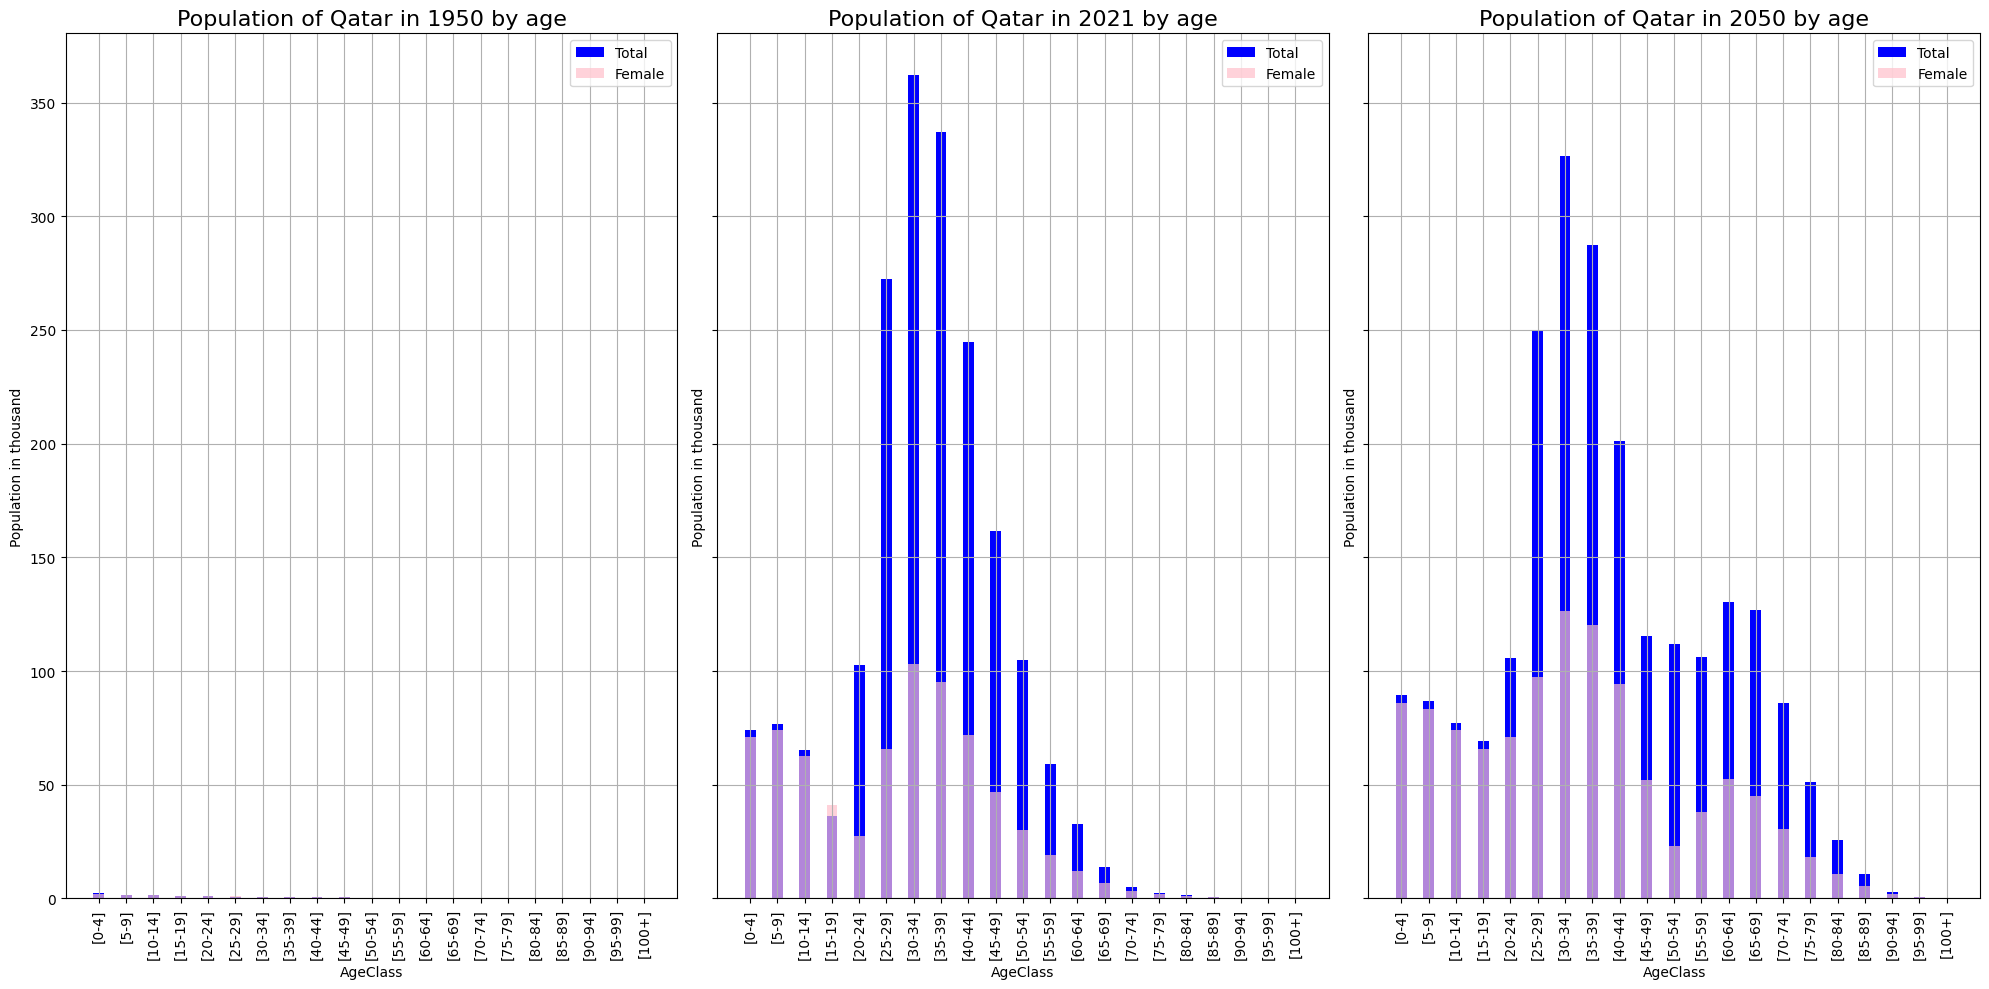

In [63]:
# Qatar Male Population by Age
Qatar_male_agewise_1950_df = Qatar_df.filter((Qatar_df['Year'] == '1950') & (Qatar_df['Sex Label'] == 'Male') & (Qatar_df['AgeClass'] != '0'))
Qatar_male_agewise_2021_df = Qatar_df.filter((Qatar_df['Year'] == '2021') & (Qatar_df['Sex Label'] == 'Male') & (Qatar_df['AgeClass'] != '0'))
Qatar_male_agewise_2050_df = Qatar_df.filter((Qatar_df['Year'] == '2050') & (Qatar_df['Sex Label'] == 'Male') & (Qatar_df['AgeClass'] != '0'))

# Convert to Pandas DataFrame for visualization
Qatar_male_agewise_1950_pd = Qatar_male_agewise_1950_df.toPandas()
Qatar_male_agewise_2021_pd = Qatar_male_agewise_2021_df.toPandas()
Qatar_male_agewise_2050_pd = Qatar_male_agewise_2050_df.toPandas()

# Qatar Female Population by Age
Qatar_female_agewise_1950_df = Qatar_df.filter((Qatar_df['Year'] == '1950') & (Qatar_df['Sex Label'] == 'Female') & (Qatar_df['AgeClass'] != '0'))
Qatar_female_agewise_2021_df = Qatar_df.filter((Qatar_df['Year'] == '2021') & (Qatar_df['Sex Label'] == 'Female') & (Qatar_df['AgeClass'] != '0'))
Qatar_female_agewise_2050_df = Qatar_df.filter((Qatar_df['Year'] == '2050') & (Qatar_df['Sex Label'] == 'Female') & (Qatar_df['AgeClass'] != '0'))

# Convert to Pandas DataFrame for visualization
Qatar_female_agewise_1950_pd = Qatar_female_agewise_1950_df.toPandas()
Qatar_female_agewise_2021_pd = Qatar_female_agewise_2021_df.toPandas()
Qatar_female_agewise_2050_pd = Qatar_female_agewise_2050_df.toPandas()


# Plotting side by side
fig, axes = plt.subplots(1, 3, figsize=(20, 10), sharey=True)

# Function to plot population pyramid for a given year
def plot_population_pyramid(ax, male_pd, female_pd, year):
    bar_width = 0.4
    age_classes = male_pd["AgeClass Label"]
    total_population = male_pd["Absolute value in thousands"]
    female_population = female_pd["Absolute value in thousands"]

    ax.bar(age_classes, total_population, bar_width, label='Total', color='blue')
    ax.bar(age_classes, female_population, bar_width, label='Female', color='pink', alpha=0.7)

    ax.set_xlabel("AgeClass")
    ax.set_ylabel("Population in thousand")
    ax.set_title(f"Population of Qatar in {year} by age", fontsize=16)
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)  # Rotate labels
    ax.legend()

# Plot for 1950
plot_population_pyramid(axes[0], Qatar_male_agewise_1950_pd, Qatar_female_agewise_1950_pd, 1950)

# Plot for 2021
plot_population_pyramid(axes[1], Qatar_male_agewise_2021_pd, Qatar_female_agewise_2021_pd, 2021)

# Plot for 2050
plot_population_pyramid(axes[2], Qatar_male_agewise_2050_pd, Qatar_female_agewise_2050_pd, 2050)

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


### variation of total population by age group over the year

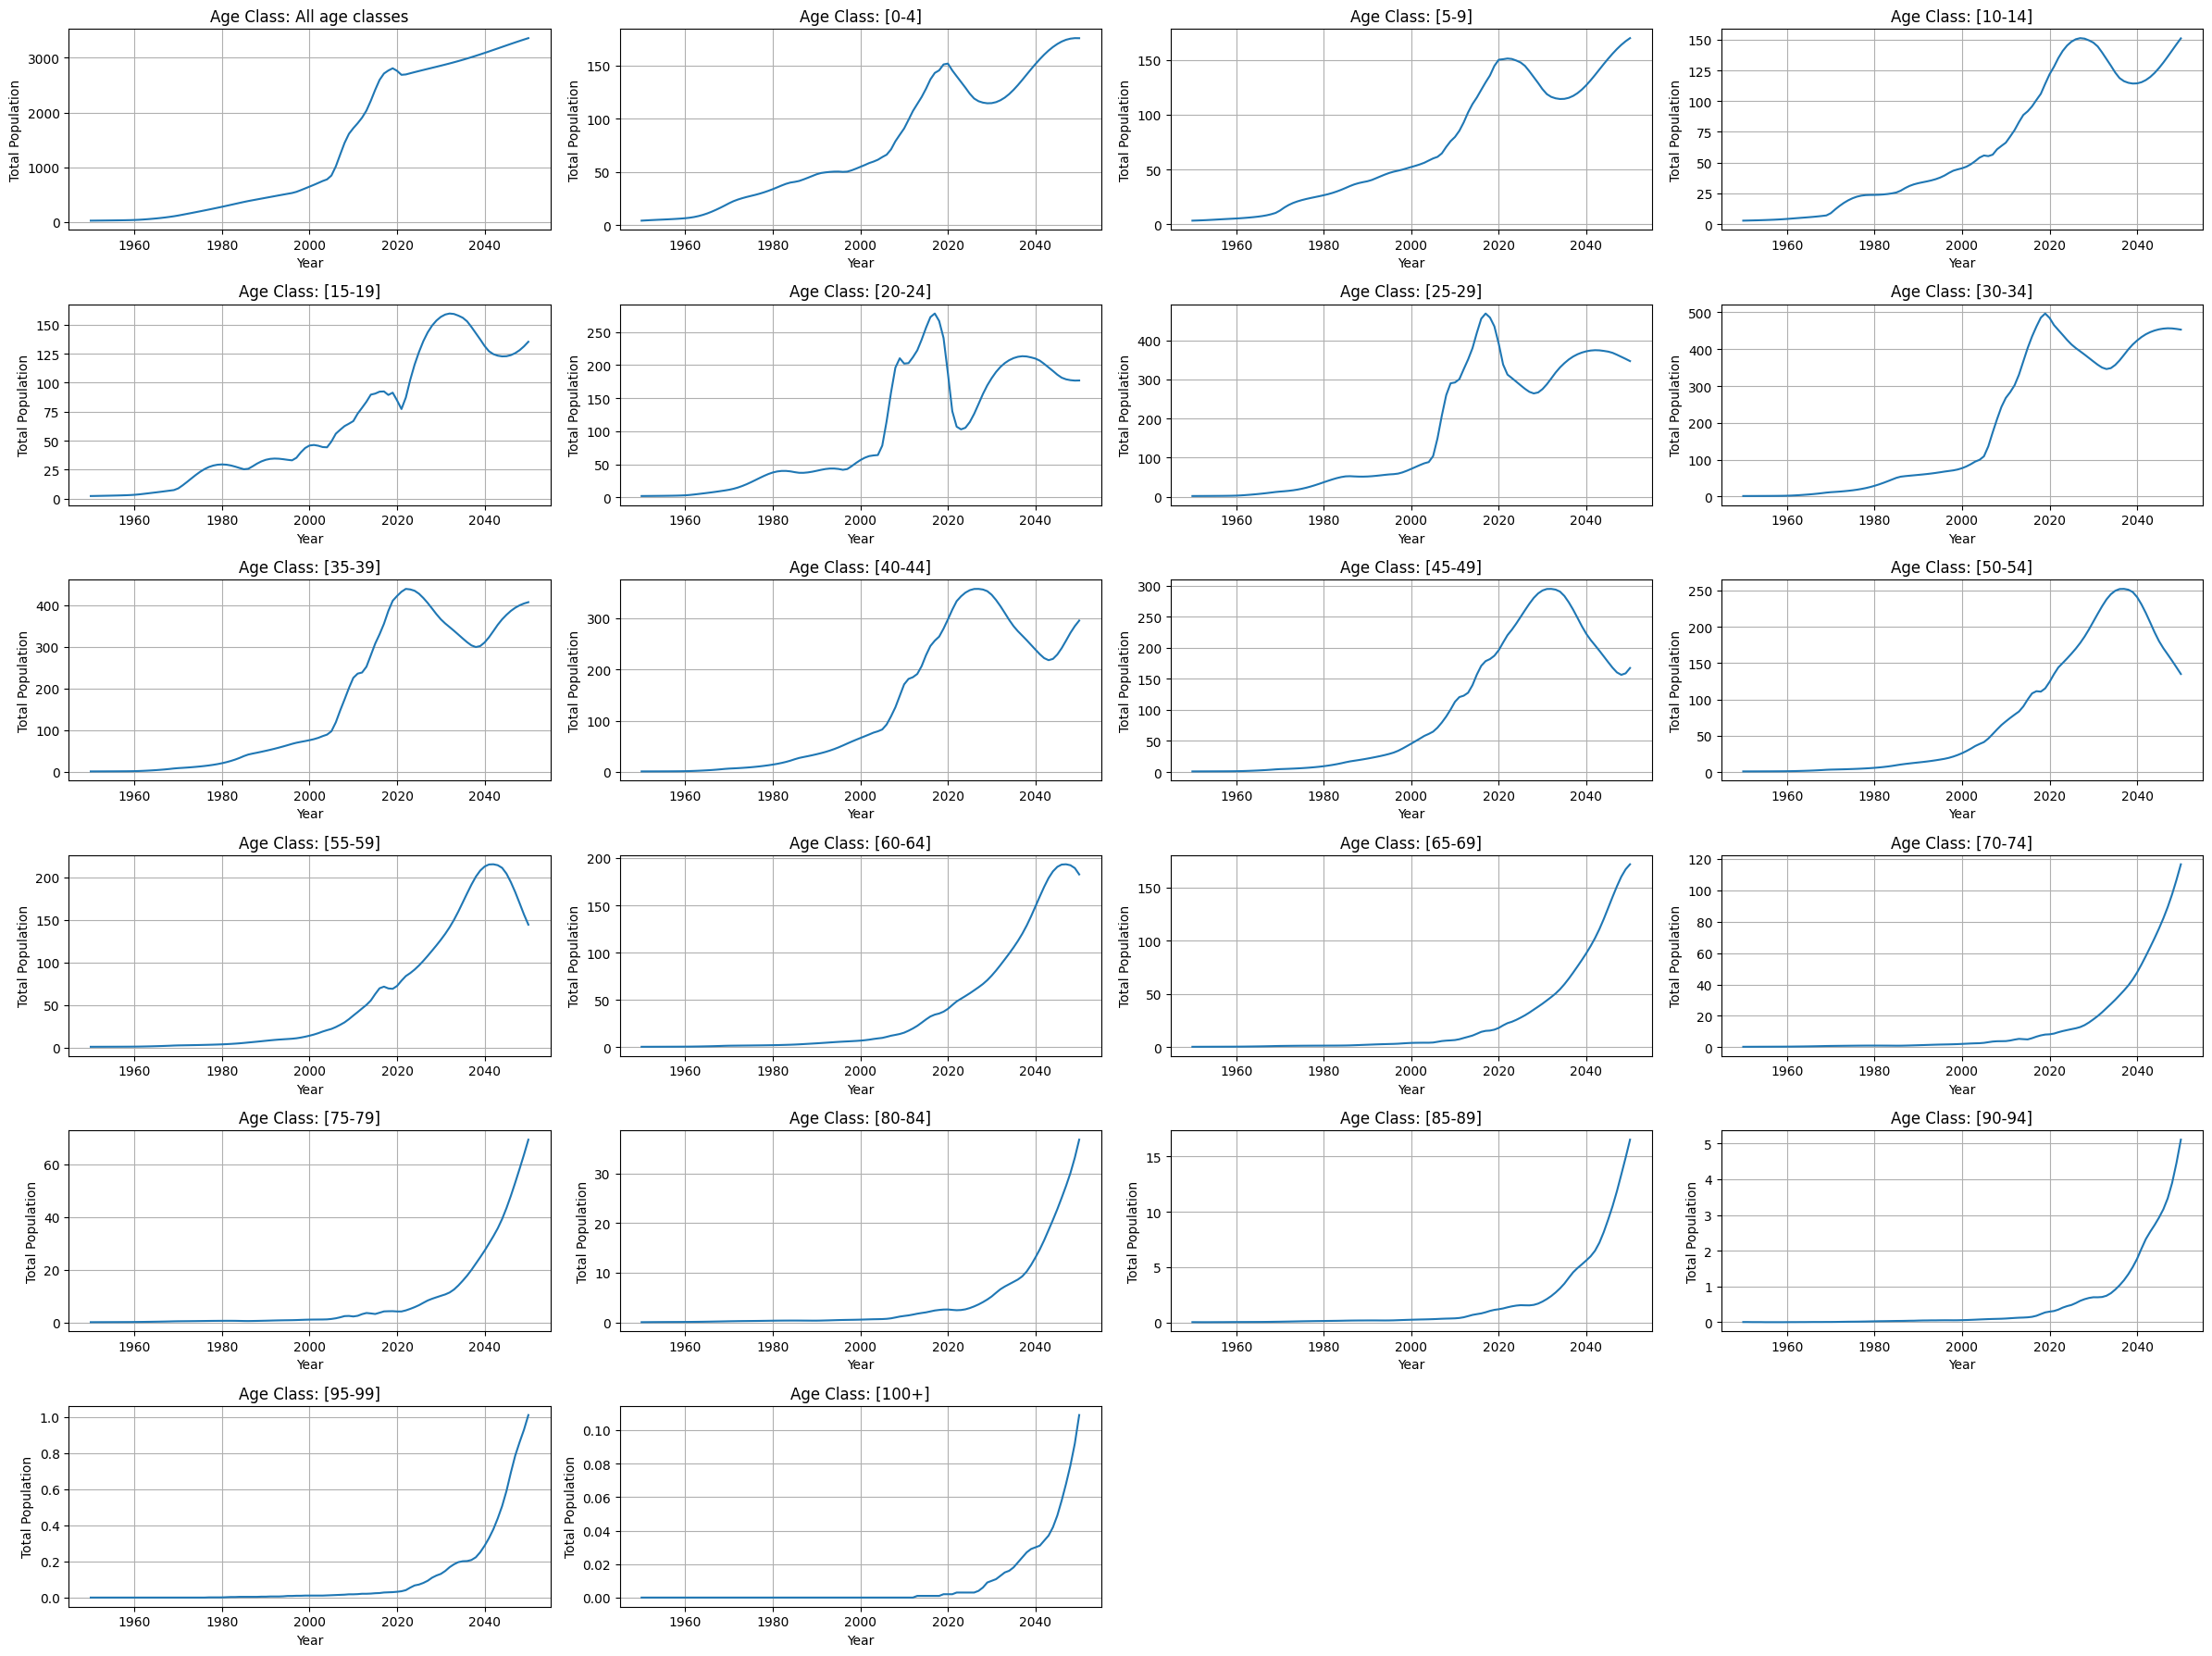

In [64]:
ageClass_labels = ['All age classes',	'[0-4]', '[5-9]', '[10-14]', '[15-19]', '[20-24]' , 	'[25-29]' , 	'[30-34]' , 	'[35-39]' , 	'[40-44]' , 	'[45-49]' , 	'[50-54]' , 	'[55-59]' , 	'[60-64]' , 	'[65-69]' , 	'[70-74]' , 	'[75-79]' , 	'[80-84]' , 	'[85-89]' , 	'[90-94]' , 	'[95-99]' , 	'[100+]']
ageClass_codes = sorted(Qatar_df.select("AgeClass").distinct().rdd.flatMap(lambda x: x).collect())
age_class_mapping = dict(zip(ageClass_codes, ageClass_labels))

fig, axs = plt.subplots(6, 4, figsize=(24, 18))
axs = axs.flatten()  # Flatten the array for easier indexing

for i, code in enumerate(ageClass_codes):
    ageClass_df = Qatar_df.filter((Qatar_df['AgeClass'] == code) & (Qatar_df['Sex Label'] == 'Both sexes'))
    ageClass_pd = ageClass_df.toPandas()


    if ageClass_pd.empty:
        continue

    age_class = age_class_mapping.get(code, "Label not found")

    axs[i].plot(ageClass_pd['Year'], ageClass_pd['Absolute value in thousands'])
    axs[i].set_xlabel("Year")
    axs[i].set_ylabel("Total Population")
    axs[i].set_title(f"Age Class: {age_class}")
    axs[i].grid(True)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

### variation of male and female total population by age group over the year

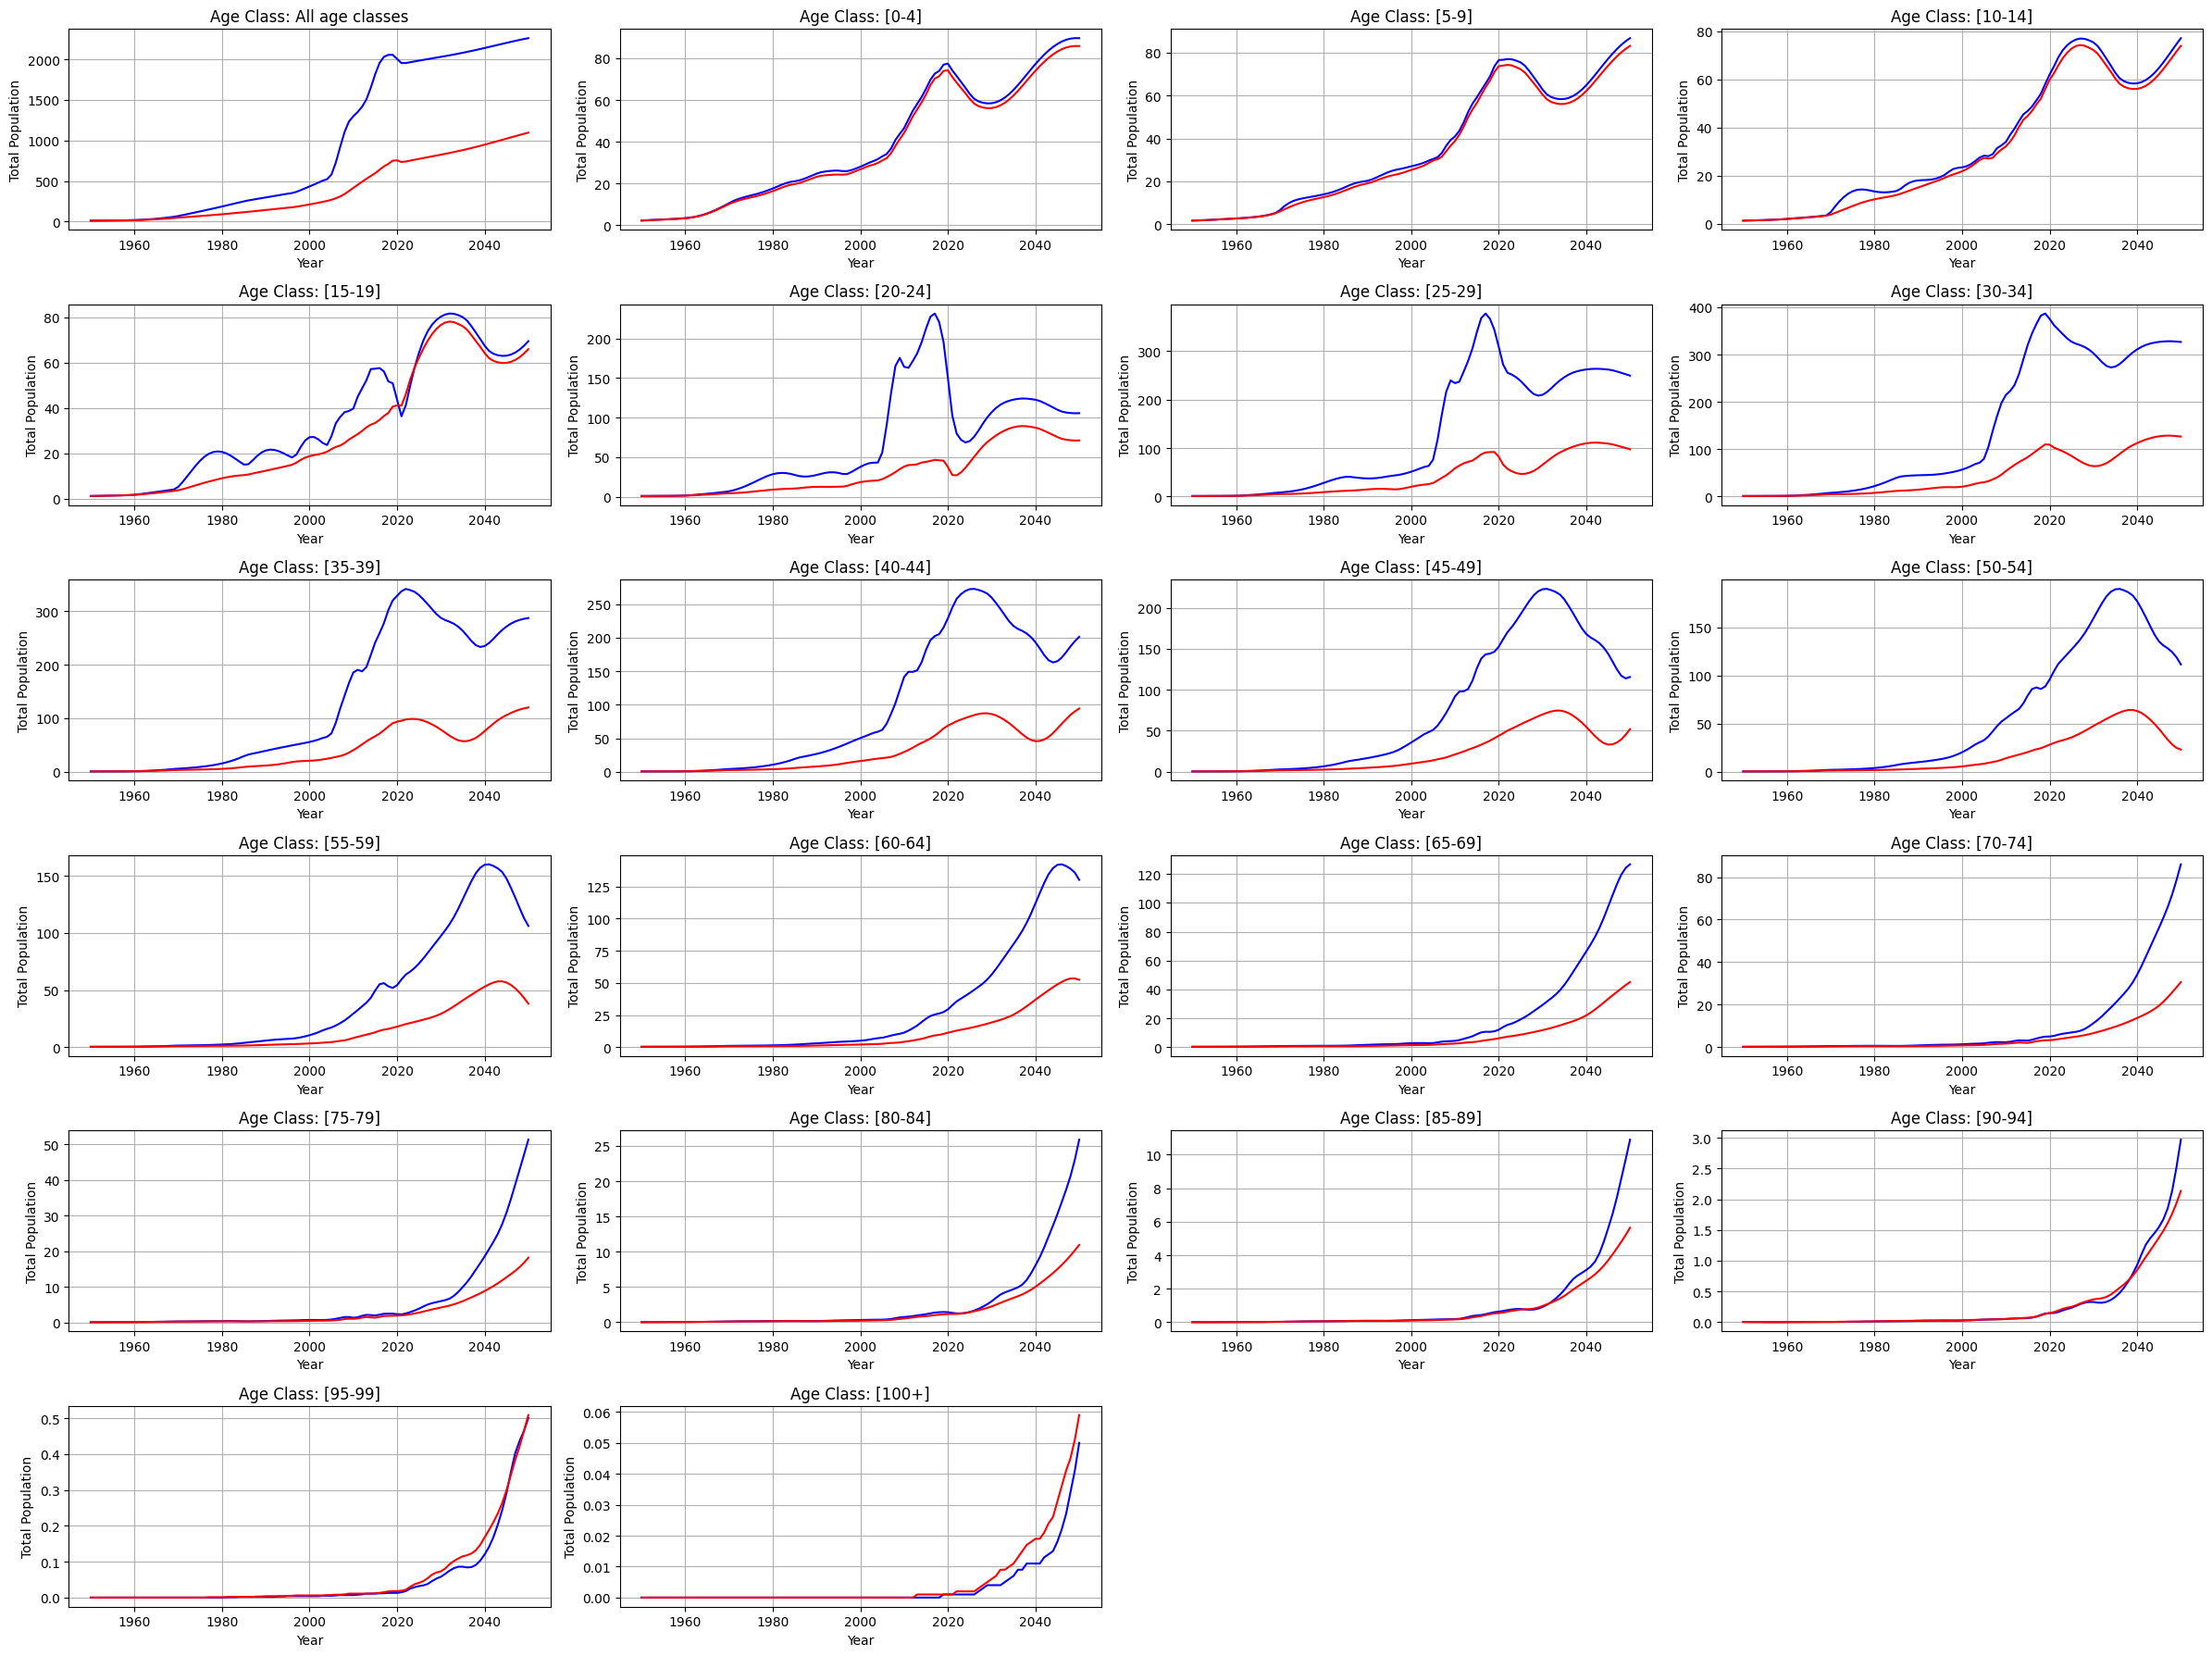

In [65]:
ageClass_labels = ['All age classes',	'[0-4]', '[5-9]', '[10-14]', '[15-19]', '[20-24]' , 	'[25-29]' , 	'[30-34]' , 	'[35-39]' , 	'[40-44]' , 	'[45-49]' , 	'[50-54]' , 	'[55-59]' , 	'[60-64]' , 	'[65-69]' , 	'[70-74]' , 	'[75-79]' , 	'[80-84]' , 	'[85-89]' , 	'[90-94]' , 	'[95-99]' , 	'[100+]']
ageClass_codes = sorted(Qatar_df.select("AgeClass").distinct().rdd.flatMap(lambda x: x).collect())
age_class_mapping = dict(zip(ageClass_codes, ageClass_labels))

fig, axs = plt.subplots(6, 4, figsize=(24, 18))
axs = axs.flatten()  # Flatten the array for easier indexing

for i, code in enumerate(ageClass_codes):
    ageClass_male_df = Qatar_df.filter((Qatar_df['AgeClass'] == code) & (Qatar_df['Sex Label'] == 'Male'))
    ageClass_female_df = Qatar_df.filter((Qatar_df['AgeClass'] == code) & (Qatar_df['Sex Label'] == 'Female'))
    male_pd = ageClass_male_df.toPandas()
    female_pd = ageClass_female_df.toPandas()


    if ageClass_pd.empty:
        continue

    age_class = age_class_mapping.get(code, "Label not found")

    axs[i].plot(male_pd['Year'], male_pd['Absolute value in thousands'], color = 'blue', label = 'male')
    axs[i].plot(female_pd['Year'], female_pd['Absolute value in thousands'], color = 'red', label = 'female')
    axs[i].set_xlabel("Year")
    axs[i].set_ylabel("Total Population")
    axs[i].set_title(f"Age Class: {age_class}")
    axs[i].grid(True)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

### Percentage of Population Above Sixty Over the Years in the Qatar

In [66]:
Qatar_df = df_cleaned[(df_cleaned['Economy Label'] == 'Qatar') & (df_cleaned['Sex Label'] == 'Both sexes')]
Qatar_df = Qatar_df[['Year', 'AgeClass Label', 'Absolute value in thousands']]
Qatar_df.show(5,truncate=False)

+----+---------------+---------------------------+
|Year|AgeClass Label |Absolute value in thousands|
+----+---------------+---------------------------+
|1950|All age classes|24.288                     |
|1950|[0-4]          |4.384                      |
|1950|[5-9]          |3.284                      |
|1950|[10-14]        |2.758                      |
|1950|[15-19]        |2.36                       |
+----+---------------+---------------------------+
only showing top 5 rows



In [67]:
# Filter for AgeClass_Label above 60 and group by year to sum the Absolute value
temp_df = Qatar_df.filter(Qatar_df["AgeClass Label"].isin(['[60-64]', '[65-69]' ,	'[70-74]' ,	'[75-79]' ,	'[80-84]' ,	'[85-89]' ,	'[90-94]', '[95-99]',	'[100+]'])).groupBy("Year").agg(
    spark_sum("Absolute value in thousands").alias("Value")
)

# Add the new AgeClass_Label
temp_df = temp_df.withColumn("AgeClass Label", lit("Above Sixty"))

# Select columns in the correct order
temp_df = temp_df.select("Year", "AgeClass Label", "Value")

# Combine the original DataFrame with the new rows
Qatar_sixty_df = Qatar_df.union(temp_df)

# Show the result
Qatar_sixty_df.orderBy("Year").show(5,truncate=False)

+----+---------------+---------------------------+
|Year|AgeClass Label |Absolute value in thousands|
+----+---------------+---------------------------+
|1950|Above Sixty    |1.3969999999999998         |
|1950|All age classes|24.288                     |
|1950|[0-4]          |4.384                      |
|1950|[5-9]          |3.284                      |
|1950|[10-14]        |2.758                      |
+----+---------------+---------------------------+
only showing top 5 rows



In [68]:

# Filter to include only rows with AgeClass_Label All age classes and Above Sixty
Qatar_filtered_df = Qatar_sixty_df.filter(Qatar_sixty_df["AgeClass Label"].isin('All age classes', 'Above Sixty'))
Qatar_filtered_df.orderBy("Year").show(5)

# Order by year and AgeClass_Label
Qatar_filtered_df = Qatar_filtered_df.orderBy("Year", "AgeClass Label")

tt_df = Qatar_filtered_df.groupBy("Year").pivot("AgeClass Label").sum("Absolute value in thousands")
tt_df.orderBy("Year").show(5)

percentage_df = tt_df.withColumn("Percentage", round((tt_df['Above Sixty'] * 100)/ tt_df['All age classes'], 2))
percentage_df.select("Year","Percentage").orderBy("Year").show(5)
percentage_df.describe().show()


+----+---------------+---------------------------+
|Year| AgeClass Label|Absolute value in thousands|
+----+---------------+---------------------------+
|1950|    Above Sixty|         1.3969999999999998|
|1950|All age classes|                     24.288|
|1951|    Above Sixty|         1.4459999999999997|
|1951|All age classes|                     25.093|
|1952|    Above Sixty|         1.4969999999999999|
+----+---------------+---------------------------+
only showing top 5 rows

+----+------------------+---------------+
|Year|       Above Sixty|All age classes|
+----+------------------+---------------+
|1950|1.3969999999999998|         24.288|
|1951|1.4459999999999997|         25.093|
|1952|1.4969999999999999|         25.934|
|1953|             1.549|         26.798|
|1954|               1.6|         27.705|
+----+------------------+---------------+
only showing top 5 rows

+----+----------+
|Year|Percentage|
+----+----------+
|1950|      5.75|
|1951|      5.76|
|1952|      5.77|
|1953

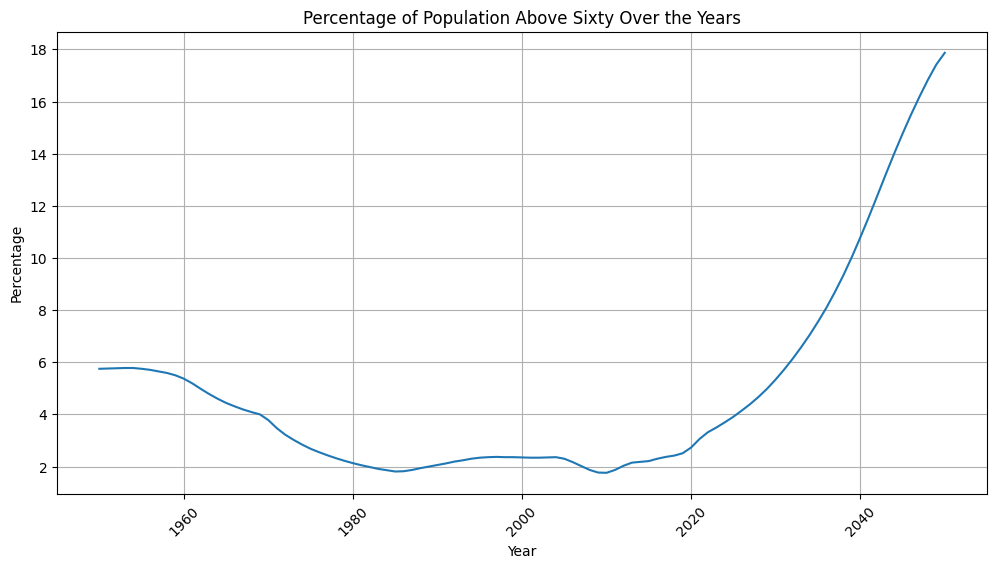

In [69]:
# Convert Spark DataFrame to Pandas DataFrame
percentage_pd_df = percentage_df.toPandas()

# Sort the Pandas DataFrame by 'Year'
percentage_pd_df = percentage_pd_df.sort_values(by='Year')

# Plot the percentage over the years
plt.figure(figsize=(12, 6))
plt.plot(percentage_pd_df['Year'], percentage_pd_df['Percentage'])
plt.title('Percentage of Population Above Sixty Over the Years')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### Percentage of Workforce Over the Years in the Qatar

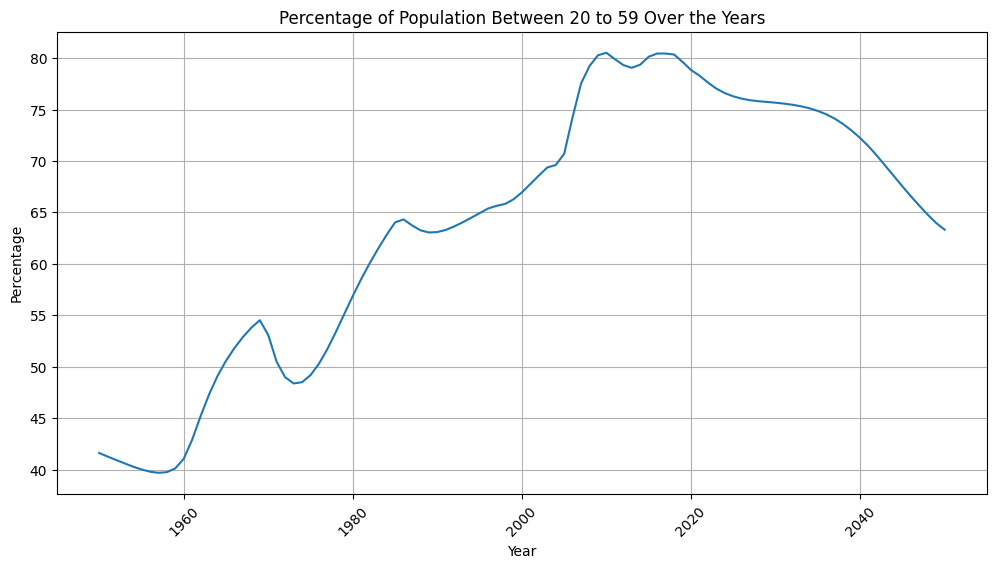

In [70]:
# Filter for AgeClass_Label above 60 and group by year to sum the Absolute value
temp_df = Qatar_df.filter(Qatar_df["AgeClass Label"].isin(['[20-24]' , 	'[25-29]' , 	'[30-34]' , 	'[35-39]' , 	'[40-44]' , 	'[45-49]' , 	'[50-54]' , 	'[55-59]'])).groupBy("Year").agg(
    spark_sum("Absolute value in thousands").alias("Value")
)

# Add the new AgeClass_Label
temp_df = temp_df.withColumn("AgeClass Label", lit("Above Sixty"))

# Select columns in the correct order
temp_df = temp_df.select("Year", "AgeClass Label", "Value")

# Combine the original DataFrame with the new rows
Qatar_sixty_df = Qatar_df.union(temp_df)

# Filter to include only rows with AgeClass_Label All age classes and Above Sixty
Qatar_filtered_df = Qatar_sixty_df.filter(Qatar_sixty_df["AgeClass Label"].isin('All age classes', 'Above Sixty'))

# Order by year and AgeClass_Label
Qatar_filtered_df = Qatar_filtered_df.orderBy("Year", "AgeClass Label")

tt_df = Qatar_filtered_df.groupBy("Year").pivot("AgeClass Label").sum("Absolute value in thousands")

percentage_df = tt_df.withColumn("Percentage", round((tt_df['Above Sixty'] * 100)/ tt_df['All age classes'], 2))

# Convert Spark DataFrame to Pandas DataFrame
percentage_pd_df = percentage_df.toPandas()

# Sort the Pandas DataFrame by 'Year'
percentage_pd_df = percentage_pd_df.sort_values(by='Year')

# Plot the percentage over the years
plt.figure(figsize=(12, 6))
plt.plot(percentage_pd_df['Year'], percentage_pd_df['Percentage'])
plt.title('Percentage of Population Between 20 to 59 Over the Years')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### Percentage of Children Over the Years in the Qatar

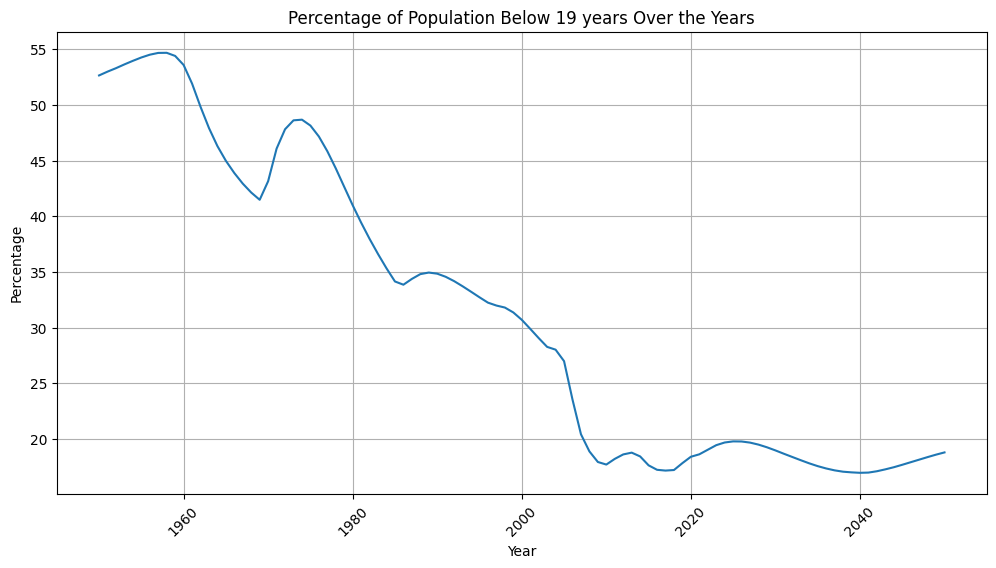

In [71]:
# Filter for AgeClass_Label above 60 and group by year to sum the Absolute value
temp_df = Qatar_df.filter(Qatar_df["AgeClass Label"].isin(['[0-4]', '[5-9]', '[10-14]', '[15-19]'])).groupBy("Year").agg(
    spark_sum("Absolute value in thousands").alias("Value")
)

# Add the new AgeClass_Label
temp_df = temp_df.withColumn("AgeClass Label", lit("Above Sixty"))

# Select columns in the correct order
temp_df = temp_df.select("Year", "AgeClass Label", "Value")

# Combine the original DataFrame with the new rows
Qatar_sixty_df = Qatar_df.union(temp_df)

# Filter to include only rows with AgeClass_Label All age classes and Above Sixty
Qatar_filtered_df = Qatar_sixty_df.filter(Qatar_sixty_df["AgeClass Label"].isin('All age classes', 'Above Sixty'))

# Order by year and AgeClass_Label
Qatar_filtered_df = Qatar_filtered_df.orderBy("Year", "AgeClass Label")

tt_df = Qatar_filtered_df.groupBy("Year").pivot("AgeClass Label").sum("Absolute value in thousands")

percentage_df = tt_df.withColumn("Percentage", round((tt_df['Above Sixty'] * 100)/ tt_df['All age classes'], 2))

# Convert Spark DataFrame to Pandas DataFrame
percentage_pd_df = percentage_df.toPandas()

# Sort the Pandas DataFrame by 'Year'
percentage_pd_df = percentage_pd_df.sort_values(by='Year')

# Plot the percentage over the years
plt.figure(figsize=(12, 6))
plt.plot(percentage_pd_df['Year'], percentage_pd_df['Percentage'])
plt.title('Percentage of Population Below 19 years Over the Years')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

## Analysing Sri Lanka

### total population in the Sri_Lanka over the years

+----+-------+-------------+---+----------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|Year|Economy|Economy Label|Sex|Sex Label |AgeClass|AgeClass Label |Absolute value in thousands|Absolute value in thousands Footnote|Absolute value in thousands Missing value|
+----+-------+-------------+---+----------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|1950|144    |Sri Lanka    |0  |Both sexes|0       |All age classes|7945.977                   |NULL                                |NULL                                     |
|1951|144    |Sri Lanka    |0  |Both sexes|0       |All age classes|8091.461                   |NULL                                |NULL                                     |
|1952|144    |Sri Lanka    |0  |Both sexes|0       |All age classes|8245.475                   |NULL                    

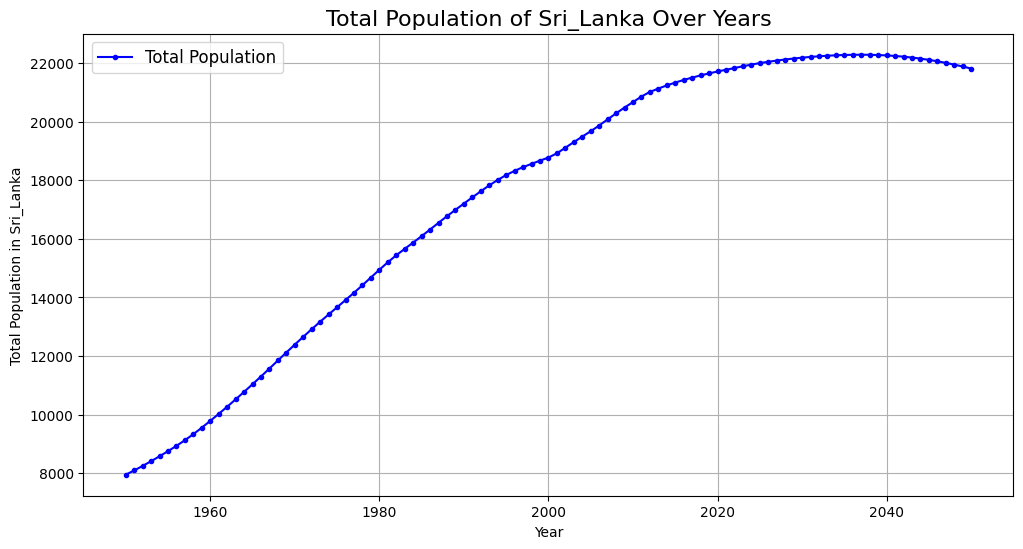

In [72]:
Sri_Lanka_df = df_cleaned.filter((df_cleaned["Economy Label"] == "Sri Lanka"))

Sri_Lanka_all_df = Sri_Lanka_df.filter((Sri_Lanka_df['AgeClass Label'] == 'All age classes') & (Sri_Lanka_df['Sex Label'] == 'Both sexes'))
Sri_Lanka_all_df.show(5,truncate=False)
Sri_Lanka_all_df.describe().show()

# Convert to Pandas DataFrame for visualization
Sri_Lanka_all_pd = Sri_Lanka_all_df.toPandas()

# Plot total population over years
plt.figure(figsize=(12, 6))
plt.plot(Sri_Lanka_all_pd["Year"], Sri_Lanka_all_pd["Absolute value in thousands"], marker='.', linestyle='-', color='blue', label='Total Population')
plt.xlabel("Year")
plt.ylabel("Total Population in Sri_Lanka")
plt.title("Total Population of Sri_Lanka Over Years", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

plt.show()

### total male and female population over the years


Male Population

+----+-------+-------------+---+---------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|Year|Economy|Economy Label|Sex|Sex Label|AgeClass|AgeClass Label |Absolute value in thousands|Absolute value in thousands Footnote|Absolute value in thousands Missing value|
+----+-------+-------------+---+---------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|1950|144    |Sri Lanka    |2  |Male     |0       |All age classes|4327.101                   |NULL                                |NULL                                     |
|1951|144    |Sri Lanka    |2  |Male     |0       |All age classes|4388.097                   |NULL                                |NULL                                     |
|1952|144    |Sri Lanka    |2  |Male     |0       |All age classes|4454.078                   |NULL        

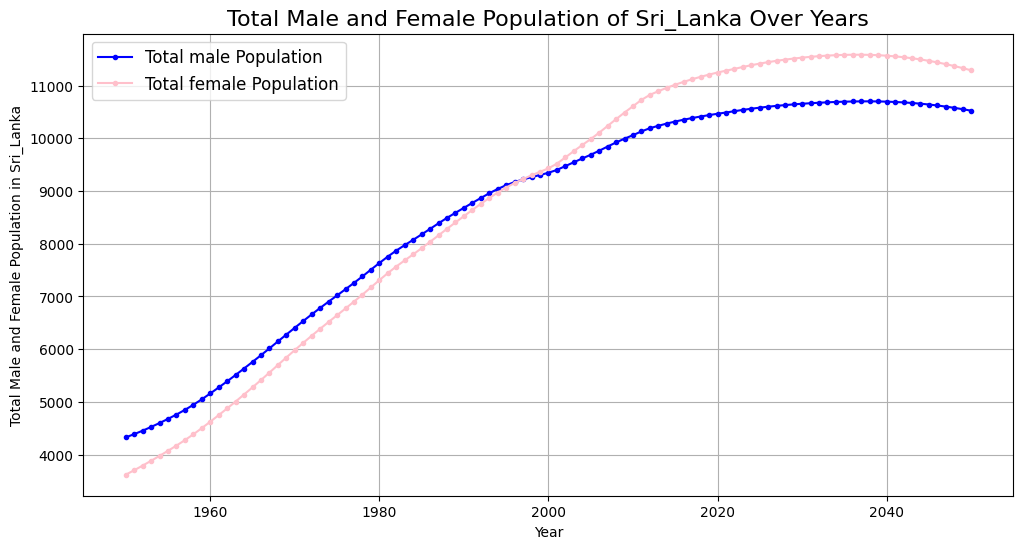

In [73]:
Sri_Lanka_male_df = Sri_Lanka_df[(Sri_Lanka_df['AgeClass Label'] == 'All age classes') & (Sri_Lanka_df['Sex Label'] == 'Male')]
print('\nMale Population\n')
Sri_Lanka_male_df.show(5,truncate=False)
Sri_Lanka_male_df.describe().show()

Sri_Lanka_female_df = Sri_Lanka_df[(Sri_Lanka_df['AgeClass Label'] == 'All age classes') & (Sri_Lanka_df['Sex Label'] == 'Female')]
print('\nFemale Population\n')
Sri_Lanka_female_df.show(5,truncate=False)
Sri_Lanka_female_df.describe().show()

# Convert to Pandas DataFrame for visualization
Sri_Lanka_male_pd = Sri_Lanka_male_df.toPandas()
Sri_Lanka_female_pd = Sri_Lanka_female_df.toPandas()

# Plot total population over years
plt.figure(figsize=(12, 6))
plt.plot(Sri_Lanka_male_pd["Year"], Sri_Lanka_male_pd["Absolute value in thousands"], marker='.', linestyle='-', color='blue', label='Total male Population')
plt.plot(Sri_Lanka_female_pd["Year"], Sri_Lanka_female_pd["Absolute value in thousands"], marker='.', linestyle='-', color='pink', label='Total female Population')
plt.xlabel("Year")
plt.ylabel("Total Male and Female Population in Sri_Lanka")
plt.title("Total Male and Female Population of Sri_Lanka Over Years", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

plt.show()

### population Pyramids

* total population by age in 1950/ 2021 / 2050
* population pyramids in 1950/ 2021 / 2050
* combined male and female population Pyramids in 1950/ 2021 / 2050

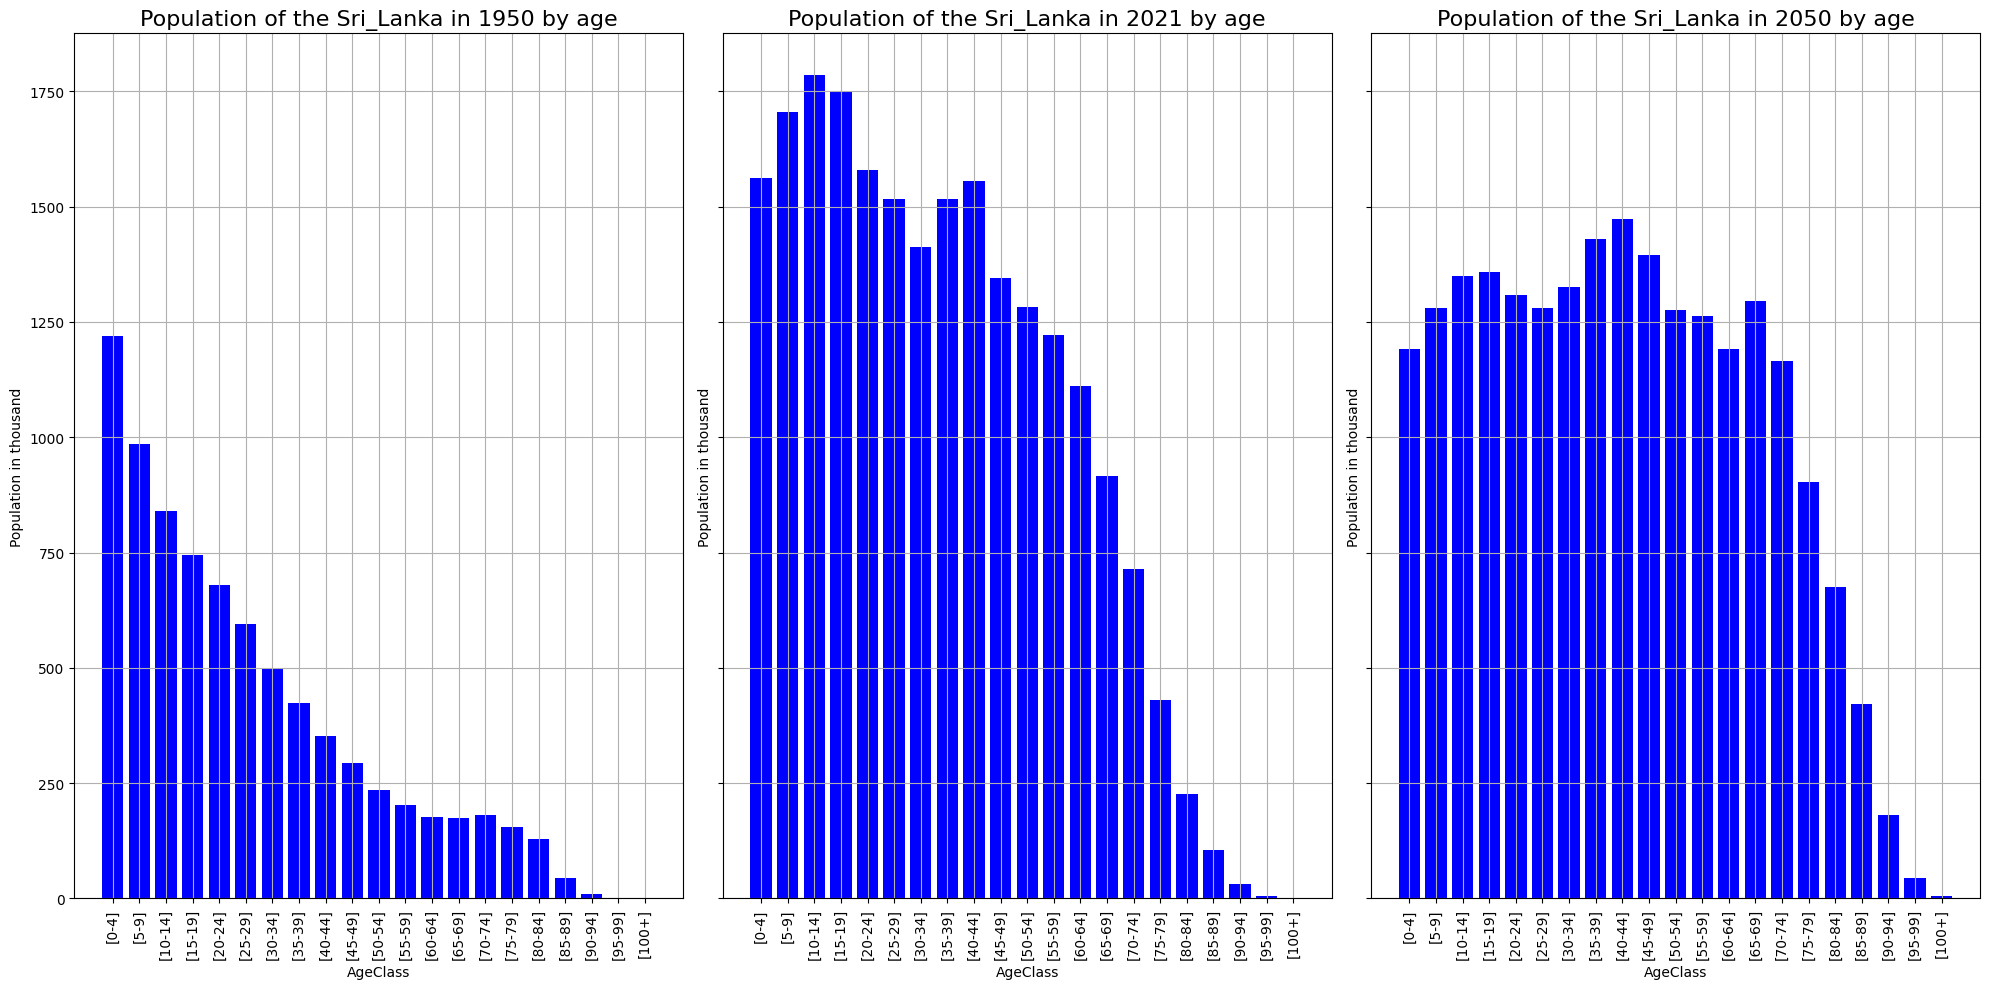

In [74]:
Sri_Lanka_all_agewise_1950_df = Sri_Lanka_df.filter((Sri_Lanka_df['Year'] == '1950') & (Sri_Lanka_df['Sex Label'] == 'Both sexes') & (Sri_Lanka_df['AgeClass'] != '0'))
Sri_Lanka_all_agewise_2021_df = Sri_Lanka_df.filter((Sri_Lanka_df['Year'] == '2021') & (Sri_Lanka_df['Sex Label'] == 'Both sexes') & (Sri_Lanka_df['AgeClass'] != '0'))
Sri_Lanka_all_agewise_2050_df = Sri_Lanka_df.filter((Sri_Lanka_df['Year'] == '2050') & (Sri_Lanka_df['Sex Label'] == 'Both sexes') & (Sri_Lanka_df['AgeClass'] != '0'))

# Convert to Pandas DataFrame for visualization
Sri_Lanka_all_agewise_1950_pd = Sri_Lanka_all_agewise_1950_df.toPandas()
Sri_Lanka_all_agewise_2021_pd = Sri_Lanka_all_agewise_2021_df.toPandas()
Sri_Lanka_all_agewise_2050_pd = Sri_Lanka_all_agewise_2050_df.toPandas()

# Plotting side by side
fig, axes = plt.subplots(1, 3, figsize=(20, 10), sharey=True)

# Plot total population over years
#plt.figure(figsize=(12, 6))

# Plot for 1950
axes[0].bar(Sri_Lanka_all_agewise_1950_pd["AgeClass Label"], Sri_Lanka_all_agewise_1950_pd["Absolute value in thousands"],  color='blue')
axes[0].set_xlabel("AgeClass")
axes[0].set_ylabel("Population in thousand")
axes[0].set_title("Population of the Sri_Lanka in 1950 by age", fontsize=16)
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=90)  # Rotate labels

# Plot for 2021
axes[1].bar(Sri_Lanka_all_agewise_2021_pd["AgeClass Label"], Sri_Lanka_all_agewise_2021_pd["Absolute value in thousands"],  color='blue')
axes[1].set_xlabel("AgeClass")
axes[1].set_ylabel("Population in thousand")
axes[1].set_title("Population of the Sri_Lanka in 2021 by age", fontsize=16)
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=90)  # Rotate labels

# Plot for 2050
axes[2].bar(Sri_Lanka_all_agewise_2050_pd["AgeClass Label"], Sri_Lanka_all_agewise_2050_pd["Absolute value in thousands"],  color='blue')
axes[2].set_xlabel("AgeClass")
axes[2].set_ylabel("Population in thousand")
axes[2].set_title("Population of the Sri_Lanka in 2050 by age", fontsize=16)
axes[2].grid(True)
axes[2].tick_params(axis='x', rotation=90)  # Rotate labels

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

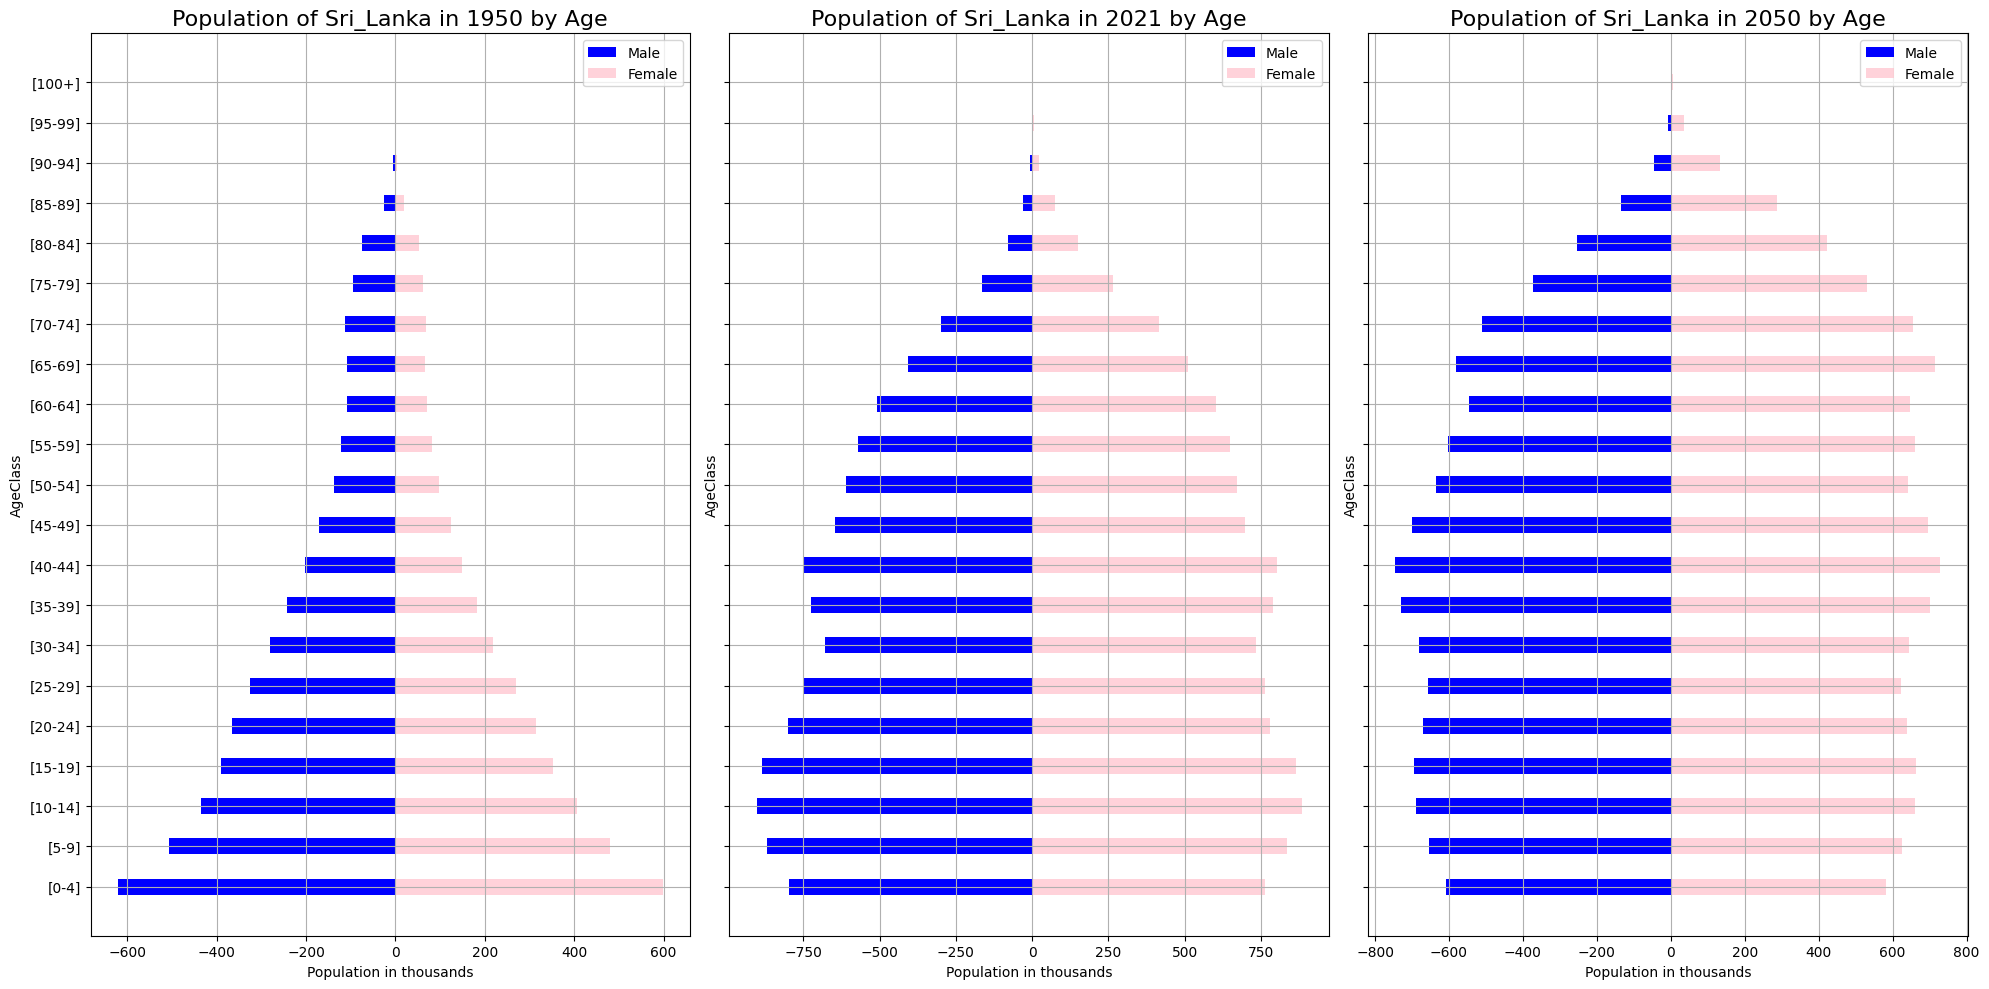

In [75]:
# Sri_Lanka Male Population by Age
Sri_Lanka_male_agewise_1950_df = Sri_Lanka_df.filter((Sri_Lanka_df['Year'] == '1950') & (Sri_Lanka_df['Sex Label'] == 'Male') & (Sri_Lanka_df['AgeClass'] != '0'))
Sri_Lanka_male_agewise_2021_df = Sri_Lanka_df.filter((Sri_Lanka_df['Year'] == '2021') & (Sri_Lanka_df['Sex Label'] == 'Male') & (Sri_Lanka_df['AgeClass'] != '0'))
Sri_Lanka_male_agewise_2050_df = Sri_Lanka_df.filter((Sri_Lanka_df['Year'] == '2050') & (Sri_Lanka_df['Sex Label'] == 'Male') & (Sri_Lanka_df['AgeClass'] != '0'))

# Sri_Lanka Female Population by Age
Sri_Lanka_female_agewise_1950_df = Sri_Lanka_df.filter((Sri_Lanka_df['Year'] == '1950') & (Sri_Lanka_df['Sex Label'] == 'Female') & (Sri_Lanka_df['AgeClass'] != '0'))
Sri_Lanka_female_agewise_2021_df = Sri_Lanka_df.filter((Sri_Lanka_df['Year'] == '2021') & (Sri_Lanka_df['Sex Label'] == 'Female') & (Sri_Lanka_df['AgeClass'] != '0'))
Sri_Lanka_female_agewise_2050_df = Sri_Lanka_df.filter((Sri_Lanka_df['Year'] == '2050') & (Sri_Lanka_df['Sex Label'] == 'Female') & (Sri_Lanka_df['AgeClass'] != '0'))

# Convert to Pandas DataFrame for visualization
Sri_Lanka_male_agewise_1950_pd = Sri_Lanka_male_agewise_1950_df.toPandas()
Sri_Lanka_male_agewise_2021_pd = Sri_Lanka_male_agewise_2021_df.toPandas()
Sri_Lanka_male_agewise_2050_pd = Sri_Lanka_male_agewise_2050_df.toPandas()

Sri_Lanka_female_agewise_1950_pd = Sri_Lanka_female_agewise_1950_df.toPandas()
Sri_Lanka_female_agewise_2021_pd = Sri_Lanka_female_agewise_2021_df.toPandas()
Sri_Lanka_female_agewise_2050_pd = Sri_Lanka_female_agewise_2050_df.toPandas()

# Plotting side by side
fig, axes = plt.subplots(1, 3, figsize=(20, 10), sharey=True)

# Function to plot population pyramid for a given year
def plot_population_pyramid(ax, male_pd, female_pd, year):
    bar_width = 0.4
    age_classes = male_pd["AgeClass Label"]
    male_population = -male_pd["Absolute value in thousands"]  # Negative for left side
    female_population = female_pd["Absolute value in thousands"]

    ax.barh(age_classes, male_population, bar_width, label='Male', color='blue')
    ax.barh(age_classes, female_population, bar_width, label='Female', color='pink', alpha=0.7)

    ax.set_xlabel("Population in thousands")
    ax.set_ylabel("AgeClass")
    ax.set_title(f"Population of Sri_Lanka in {year} by Age", fontsize=16)
    ax.grid(True)
    ax.legend()

# Plot for 1950
plot_population_pyramid(axes[0], Sri_Lanka_male_agewise_1950_pd, Sri_Lanka_female_agewise_1950_pd, 1950)
# Plot for 2021
plot_population_pyramid(axes[1], Sri_Lanka_male_agewise_2021_pd, Sri_Lanka_female_agewise_2021_pd, 2021)
# Plot for 2050
plot_population_pyramid(axes[2], Sri_Lanka_male_agewise_2050_pd, Sri_Lanka_female_agewise_2050_pd, 2050)

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

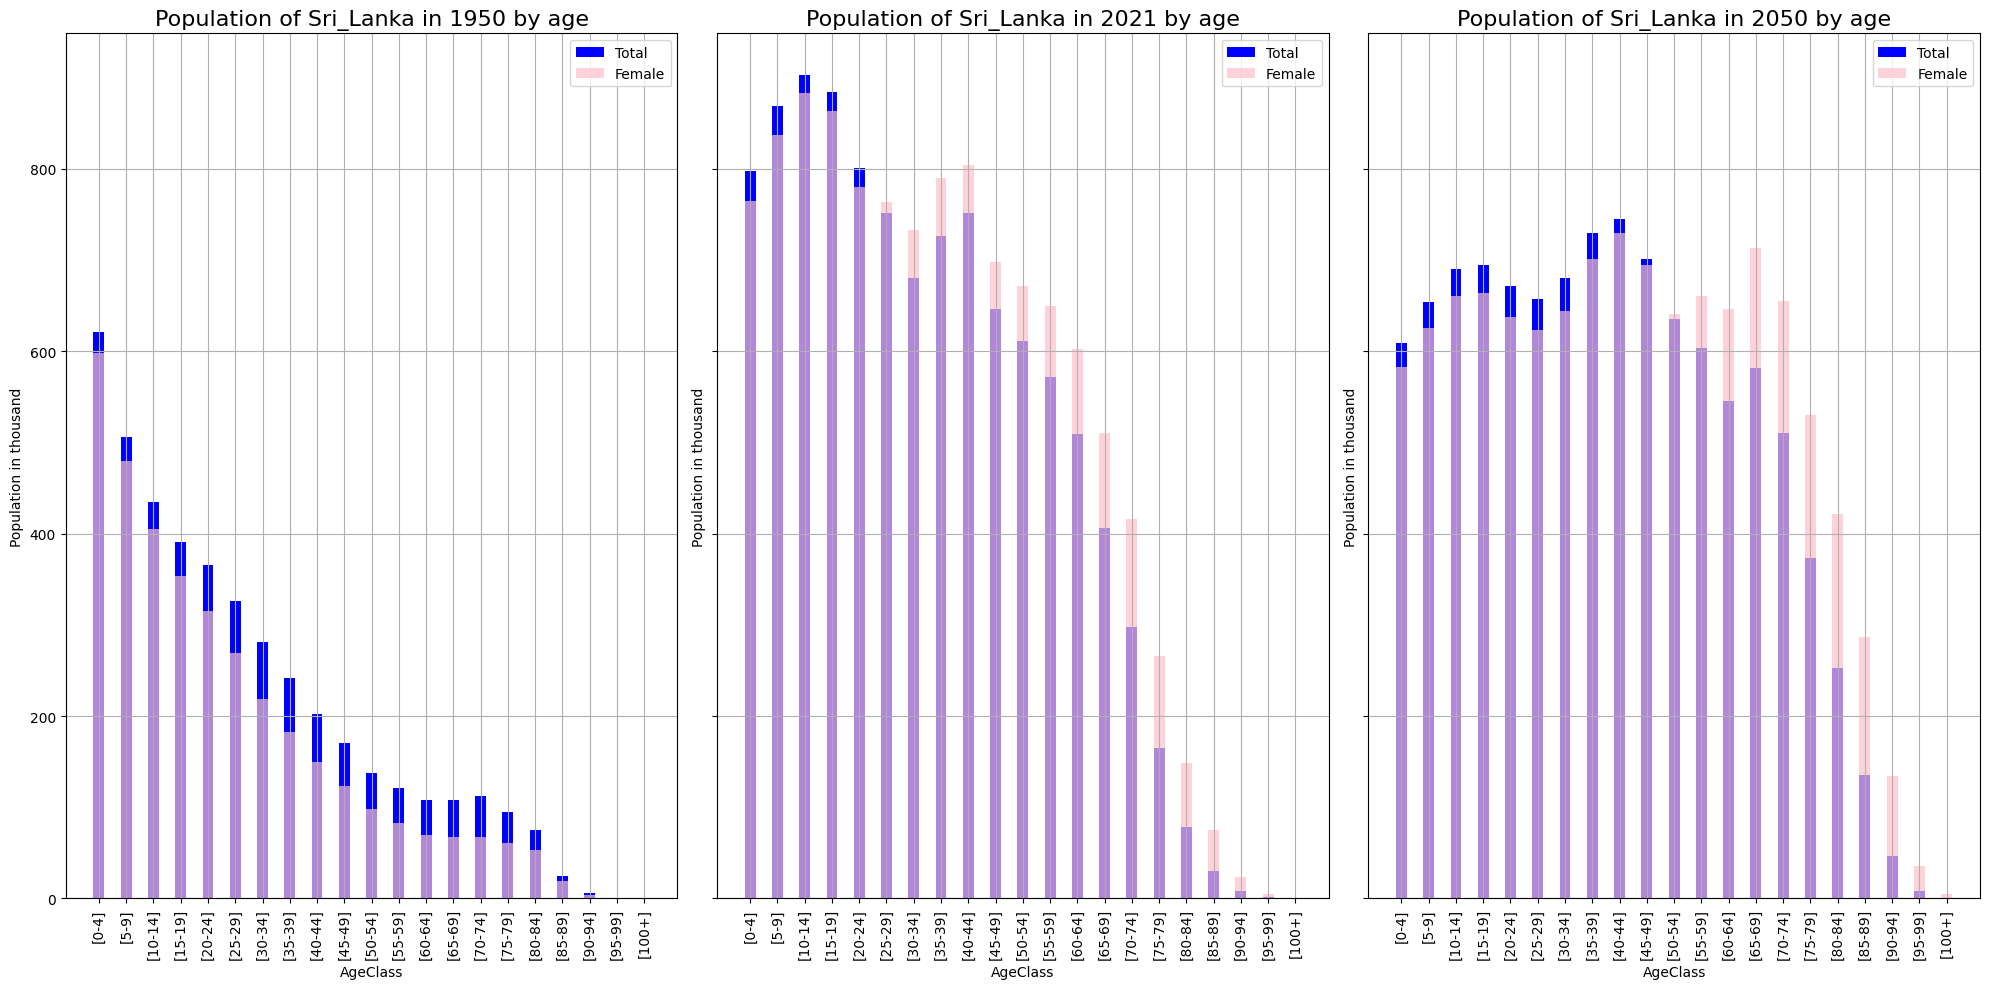

In [76]:
# Sri_Lanka Male Population by Age
Sri_Lanka_male_agewise_1950_df = Sri_Lanka_df.filter((Sri_Lanka_df['Year'] == '1950') & (Sri_Lanka_df['Sex Label'] == 'Male') & (Sri_Lanka_df['AgeClass'] != '0'))
Sri_Lanka_male_agewise_2021_df = Sri_Lanka_df.filter((Sri_Lanka_df['Year'] == '2021') & (Sri_Lanka_df['Sex Label'] == 'Male') & (Sri_Lanka_df['AgeClass'] != '0'))
Sri_Lanka_male_agewise_2050_df = Sri_Lanka_df.filter((Sri_Lanka_df['Year'] == '2050') & (Sri_Lanka_df['Sex Label'] == 'Male') & (Sri_Lanka_df['AgeClass'] != '0'))

# Convert to Pandas DataFrame for visualization
Sri_Lanka_male_agewise_1950_pd = Sri_Lanka_male_agewise_1950_df.toPandas()
Sri_Lanka_male_agewise_2021_pd = Sri_Lanka_male_agewise_2021_df.toPandas()
Sri_Lanka_male_agewise_2050_pd = Sri_Lanka_male_agewise_2050_df.toPandas()

# Sri_Lanka Female Population by Age
Sri_Lanka_female_agewise_1950_df = Sri_Lanka_df.filter((Sri_Lanka_df['Year'] == '1950') & (Sri_Lanka_df['Sex Label'] == 'Female') & (Sri_Lanka_df['AgeClass'] != '0'))
Sri_Lanka_female_agewise_2021_df = Sri_Lanka_df.filter((Sri_Lanka_df['Year'] == '2021') & (Sri_Lanka_df['Sex Label'] == 'Female') & (Sri_Lanka_df['AgeClass'] != '0'))
Sri_Lanka_female_agewise_2050_df = Sri_Lanka_df.filter((Sri_Lanka_df['Year'] == '2050') & (Sri_Lanka_df['Sex Label'] == 'Female') & (Sri_Lanka_df['AgeClass'] != '0'))

# Convert to Pandas DataFrame for visualization
Sri_Lanka_female_agewise_1950_pd = Sri_Lanka_female_agewise_1950_df.toPandas()
Sri_Lanka_female_agewise_2021_pd = Sri_Lanka_female_agewise_2021_df.toPandas()
Sri_Lanka_female_agewise_2050_pd = Sri_Lanka_female_agewise_2050_df.toPandas()


# Plotting side by side
fig, axes = plt.subplots(1, 3, figsize=(20, 10), sharey=True)

# Function to plot population pyramid for a given year
def plot_population_pyramid(ax, male_pd, female_pd, year):
    bar_width = 0.4
    age_classes = male_pd["AgeClass Label"]
    total_population = male_pd["Absolute value in thousands"]
    female_population = female_pd["Absolute value in thousands"]

    ax.bar(age_classes, total_population, bar_width, label='Total', color='blue')
    ax.bar(age_classes, female_population, bar_width, label='Female', color='pink', alpha=0.7)

    ax.set_xlabel("AgeClass")
    ax.set_ylabel("Population in thousand")
    ax.set_title(f"Population of Sri_Lanka in {year} by age", fontsize=16)
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)  # Rotate labels
    ax.legend()

# Plot for 1950
plot_population_pyramid(axes[0], Sri_Lanka_male_agewise_1950_pd, Sri_Lanka_female_agewise_1950_pd, 1950)

# Plot for 2021
plot_population_pyramid(axes[1], Sri_Lanka_male_agewise_2021_pd, Sri_Lanka_female_agewise_2021_pd, 2021)

# Plot for 2050
plot_population_pyramid(axes[2], Sri_Lanka_male_agewise_2050_pd, Sri_Lanka_female_agewise_2050_pd, 2050)

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


### variation of total population by age group over the year

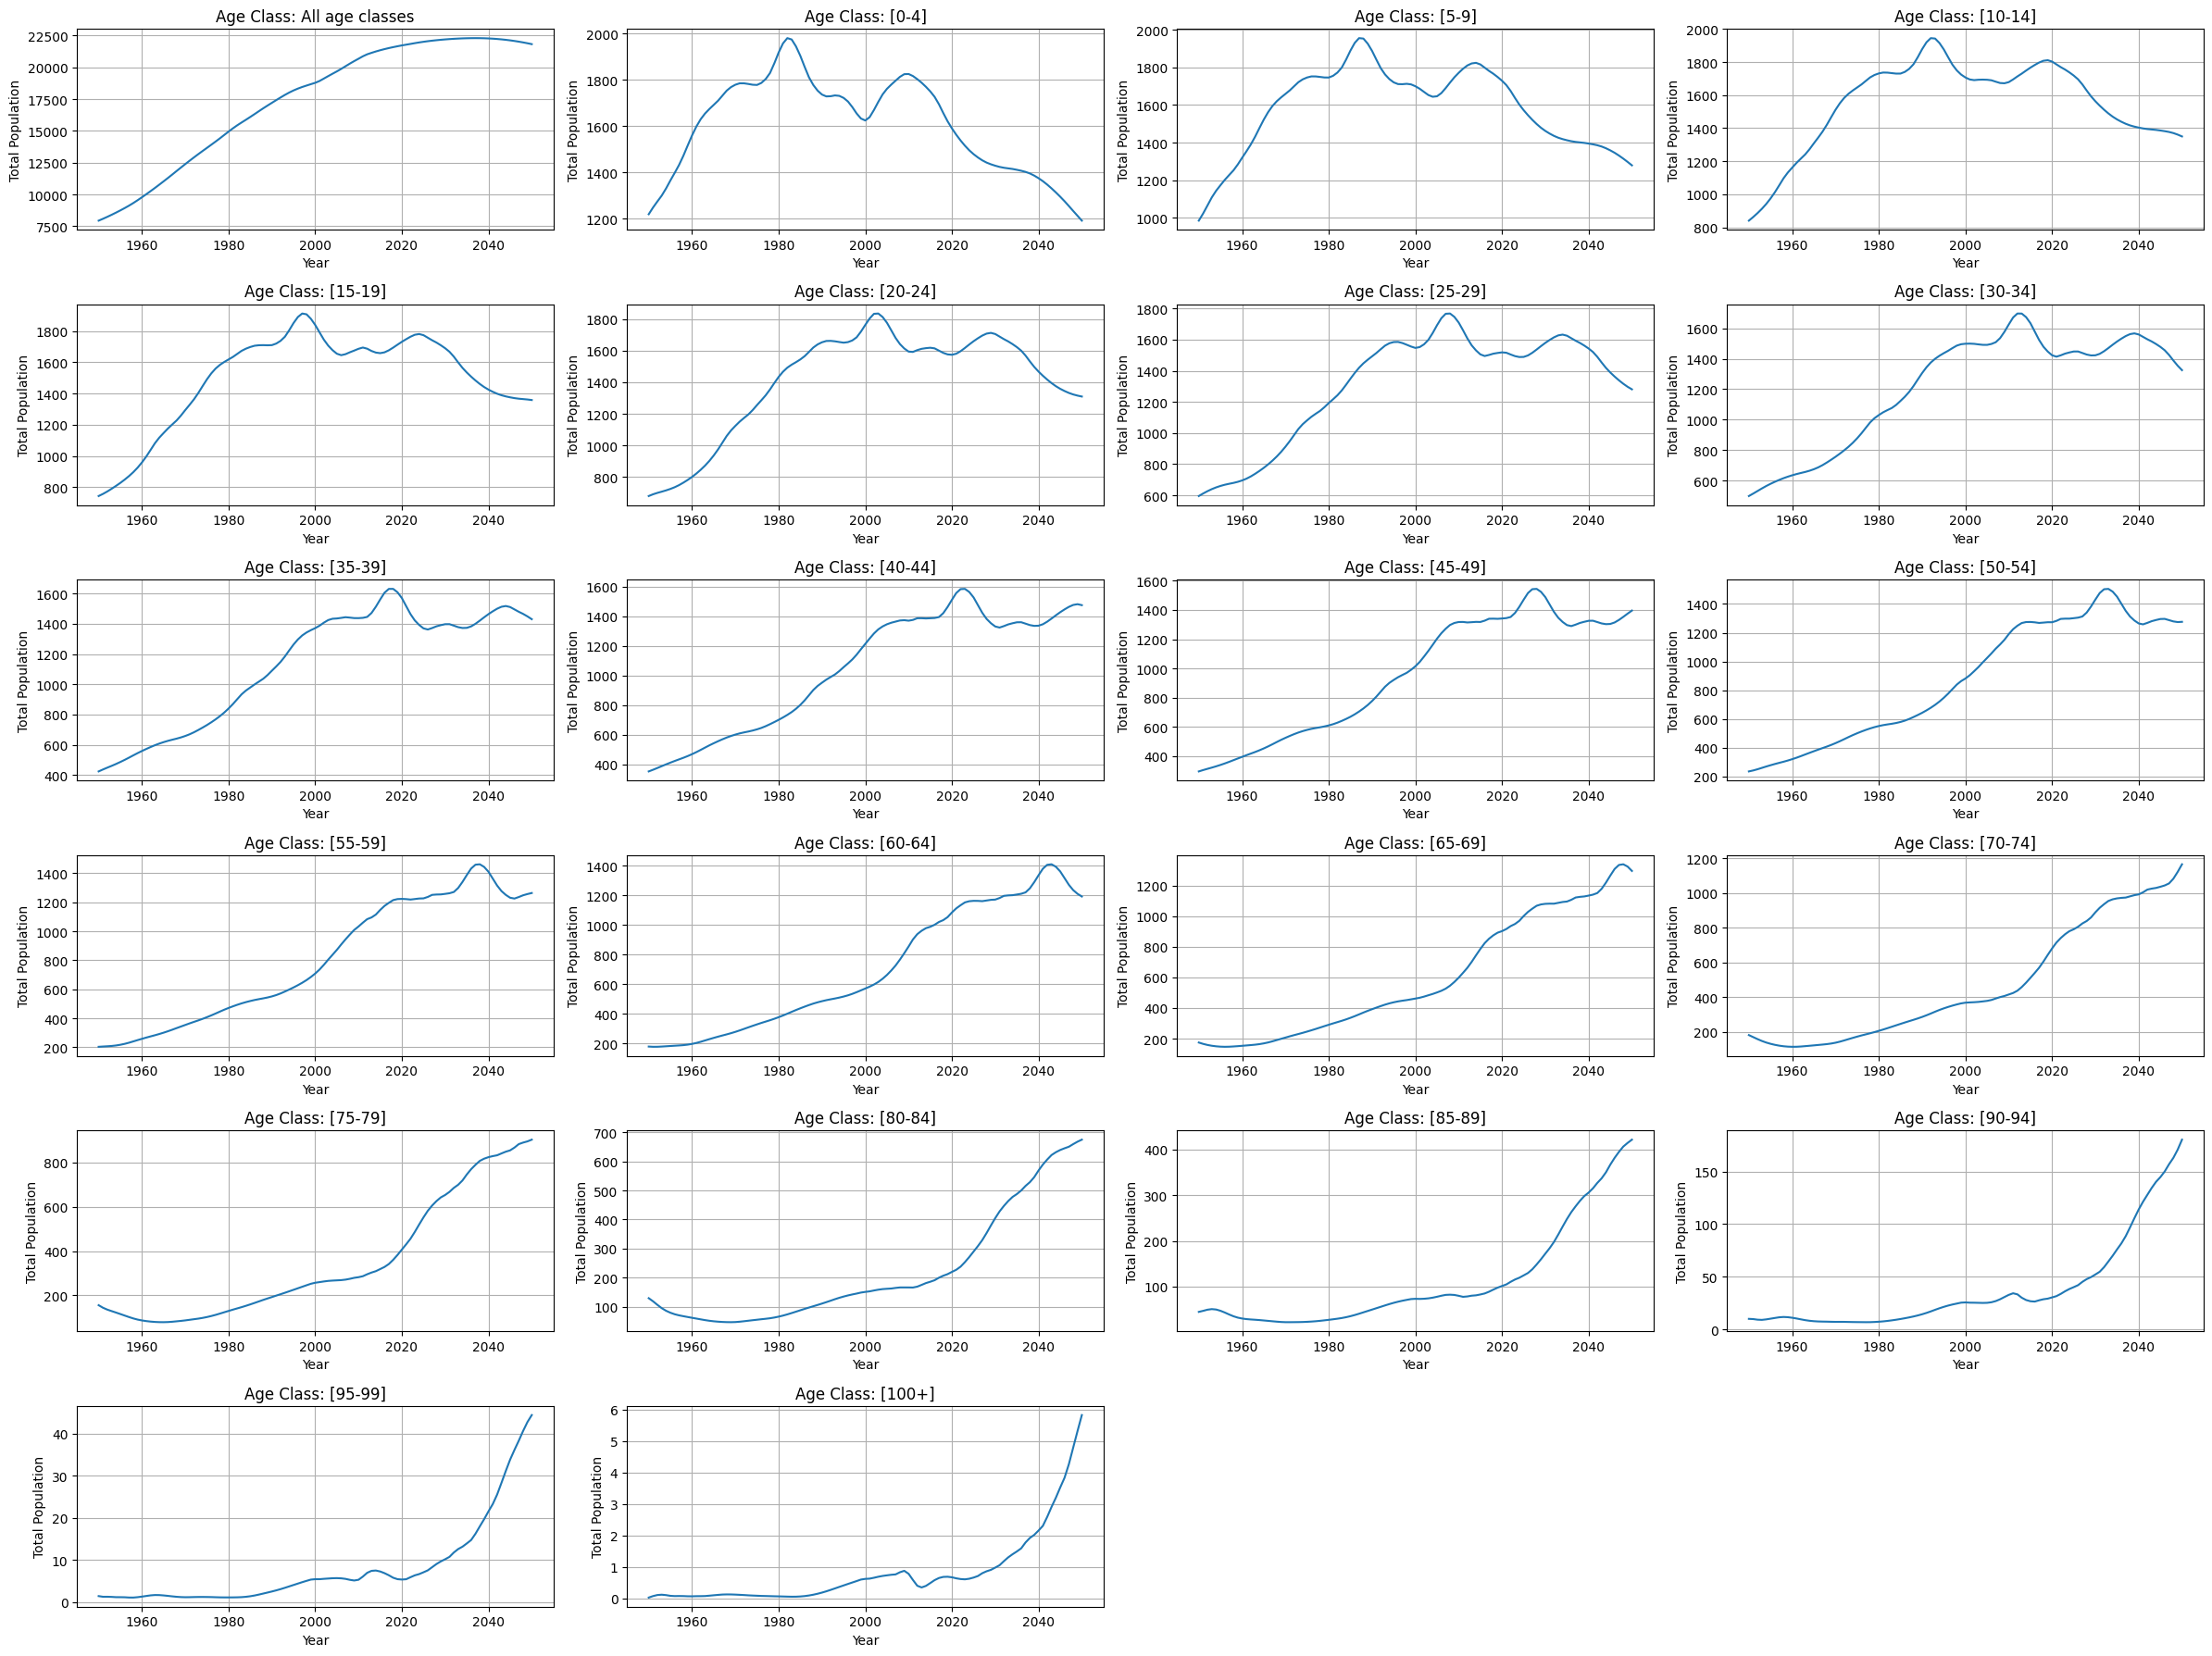

In [77]:
ageClass_labels = ['All age classes',	'[0-4]', '[5-9]', '[10-14]', '[15-19]', '[20-24]' , 	'[25-29]' , 	'[30-34]' , 	'[35-39]' , 	'[40-44]' , 	'[45-49]' , 	'[50-54]' , 	'[55-59]' , 	'[60-64]' , 	'[65-69]' , 	'[70-74]' , 	'[75-79]' , 	'[80-84]' , 	'[85-89]' , 	'[90-94]' , 	'[95-99]' , 	'[100+]']
ageClass_codes = sorted(Sri_Lanka_df.select("AgeClass").distinct().rdd.flatMap(lambda x: x).collect())
age_class_mapping = dict(zip(ageClass_codes, ageClass_labels))

fig, axs = plt.subplots(6, 4, figsize=(24, 18))
axs = axs.flatten()  # Flatten the array for easier indexing

for i, code in enumerate(ageClass_codes):
    ageClass_df = Sri_Lanka_df.filter((Sri_Lanka_df['AgeClass'] == code) & (Sri_Lanka_df['Sex Label'] == 'Both sexes'))
    ageClass_pd = ageClass_df.toPandas()


    if ageClass_pd.empty:
        continue

    age_class = age_class_mapping.get(code, "Label not found")

    axs[i].plot(ageClass_pd['Year'], ageClass_pd['Absolute value in thousands'])
    axs[i].set_xlabel("Year")
    axs[i].set_ylabel("Total Population")
    axs[i].set_title(f"Age Class: {age_class}")
    axs[i].grid(True)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

### variation of male and female total population by age group over the year

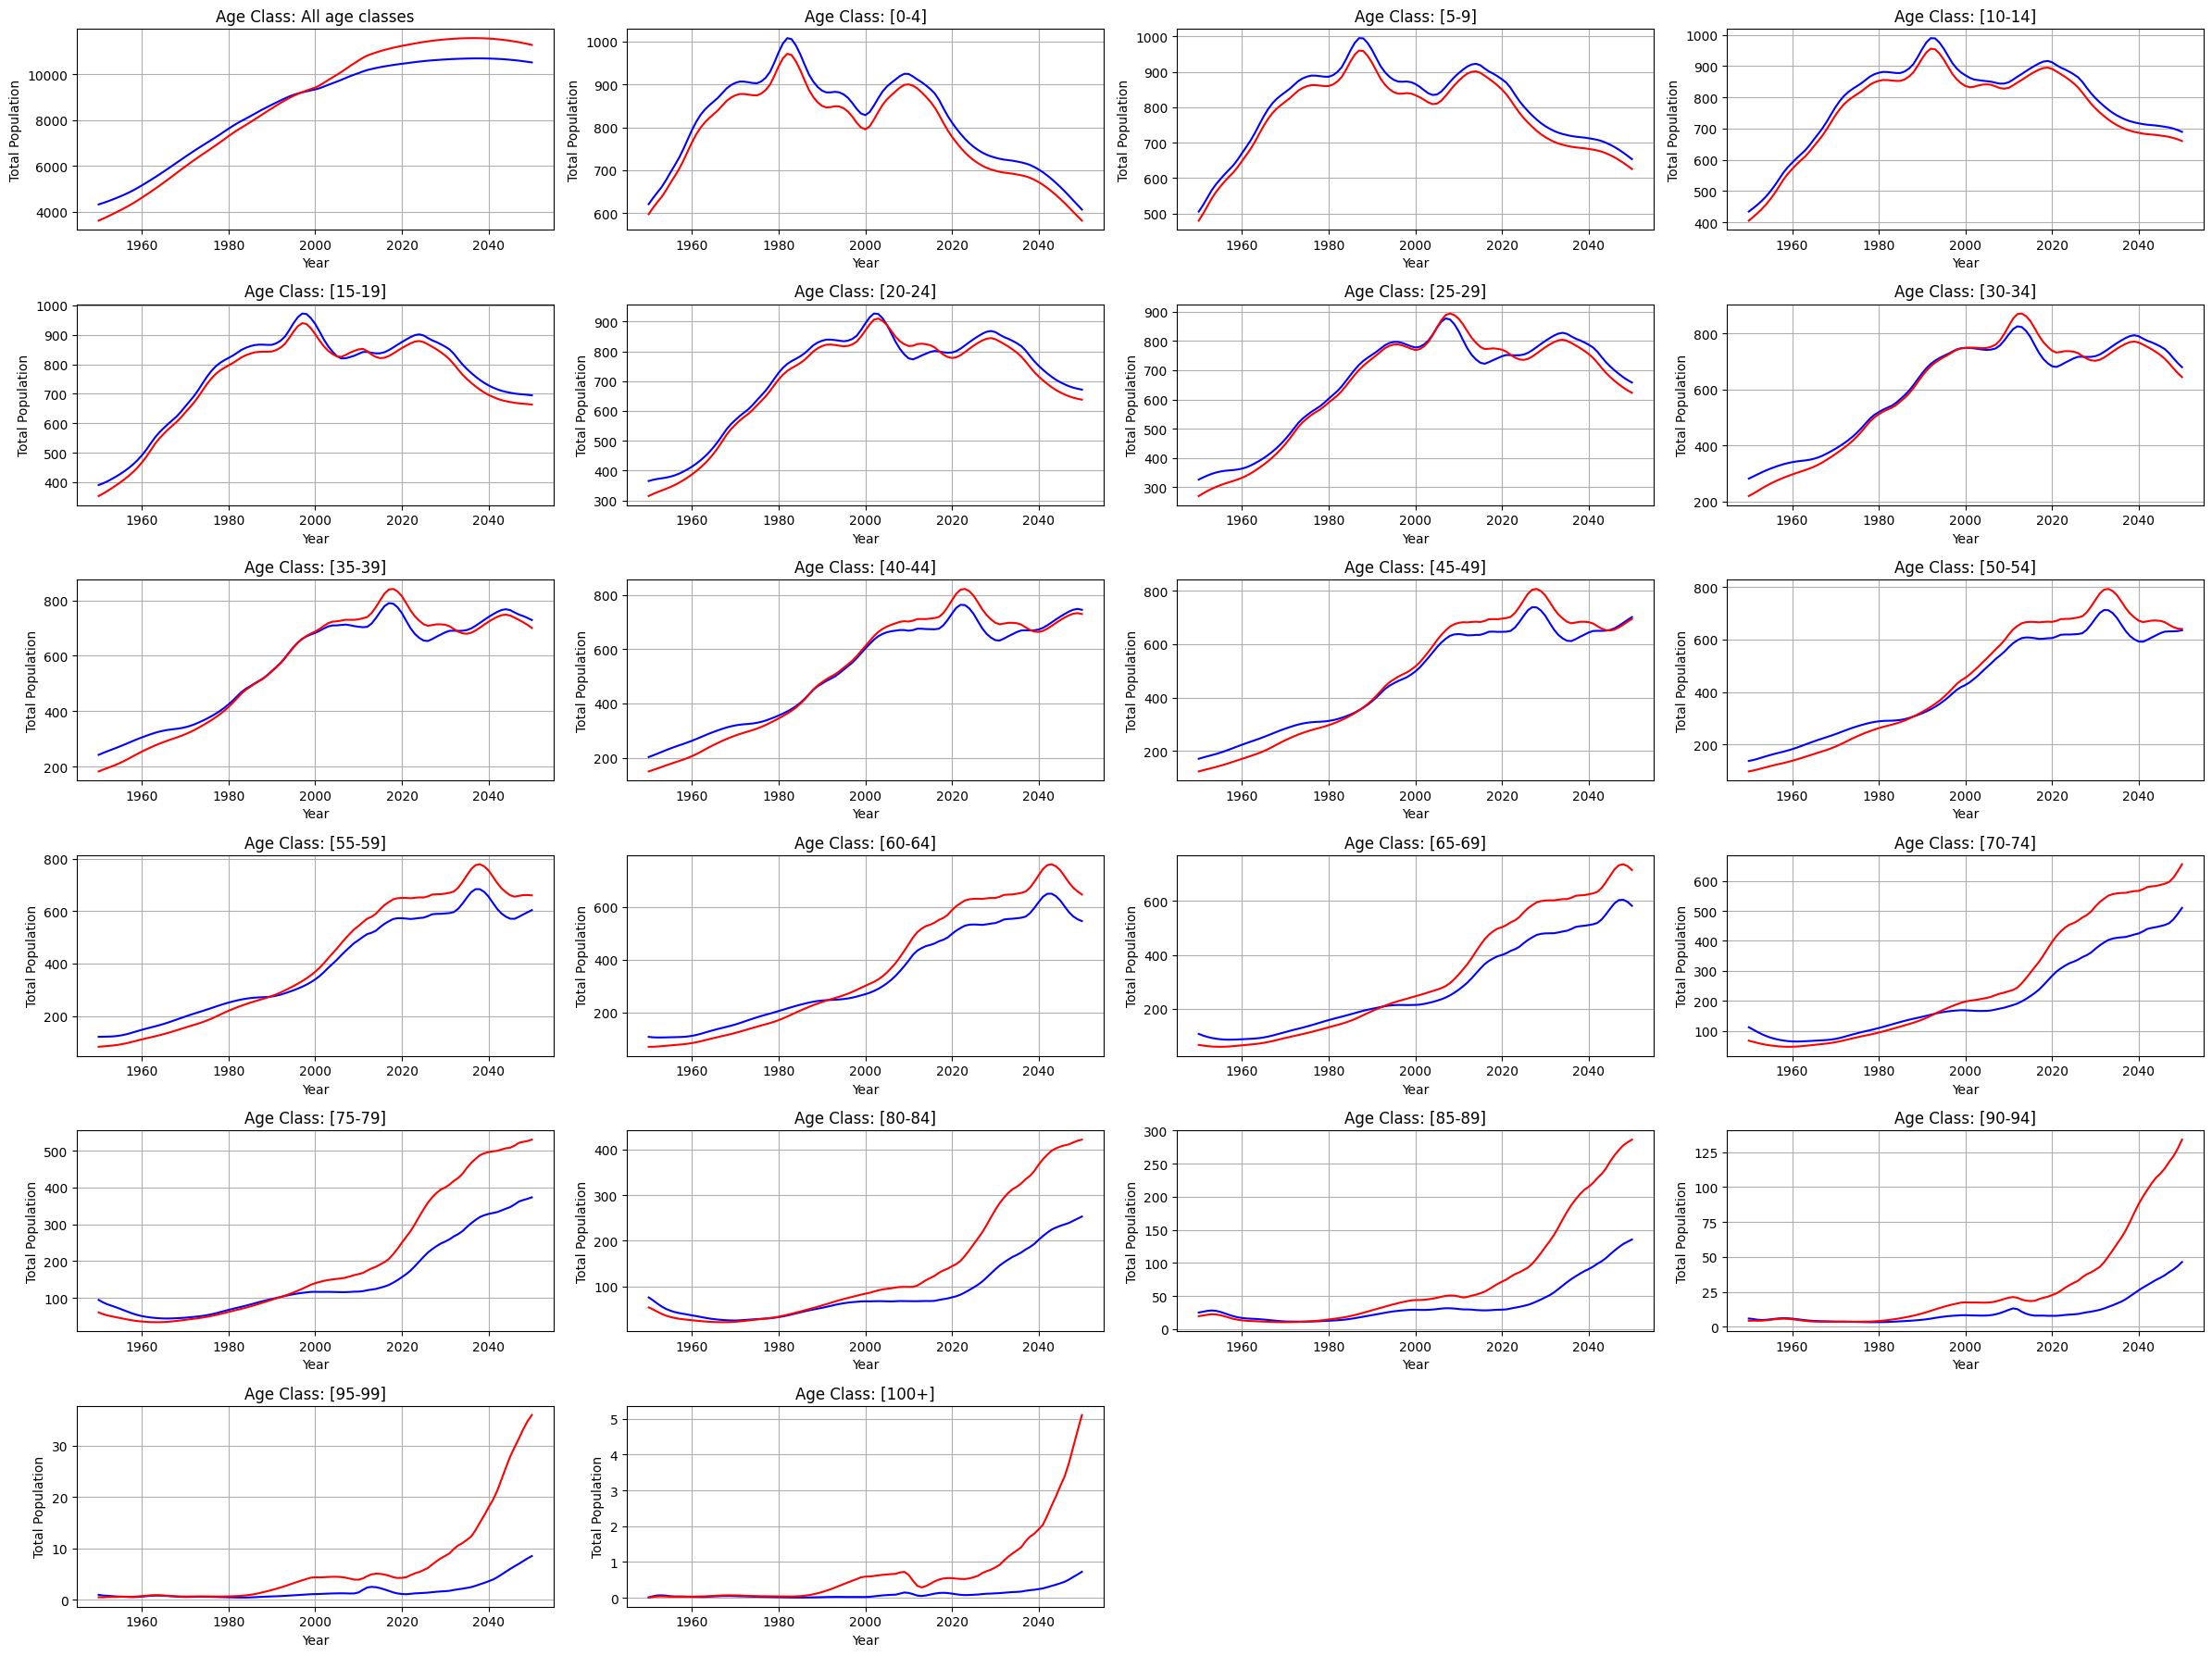

In [78]:
ageClass_labels = ['All age classes',	'[0-4]', '[5-9]', '[10-14]', '[15-19]', '[20-24]' , 	'[25-29]' , 	'[30-34]' , 	'[35-39]' , 	'[40-44]' , 	'[45-49]' , 	'[50-54]' , 	'[55-59]' , 	'[60-64]' , 	'[65-69]' , 	'[70-74]' , 	'[75-79]' , 	'[80-84]' , 	'[85-89]' , 	'[90-94]' , 	'[95-99]' , 	'[100+]']
ageClass_codes = sorted(Sri_Lanka_df.select("AgeClass").distinct().rdd.flatMap(lambda x: x).collect())
age_class_mapping = dict(zip(ageClass_codes, ageClass_labels))

fig, axs = plt.subplots(6, 4, figsize=(24, 18))
axs = axs.flatten()  # Flatten the array for easier indexing

for i, code in enumerate(ageClass_codes):
    ageClass_male_df = Sri_Lanka_df.filter((Sri_Lanka_df['AgeClass'] == code) & (Sri_Lanka_df['Sex Label'] == 'Male'))
    ageClass_female_df = Sri_Lanka_df.filter((Sri_Lanka_df['AgeClass'] == code) & (Sri_Lanka_df['Sex Label'] == 'Female'))
    male_pd = ageClass_male_df.toPandas()
    female_pd = ageClass_female_df.toPandas()


    if ageClass_pd.empty:
        continue

    age_class = age_class_mapping.get(code, "Label not found")

    axs[i].plot(male_pd['Year'], male_pd['Absolute value in thousands'], color = 'blue', label = 'male')
    axs[i].plot(female_pd['Year'], female_pd['Absolute value in thousands'], color = 'red', label = 'female')
    axs[i].set_xlabel("Year")
    axs[i].set_ylabel("Total Population")
    axs[i].set_title(f"Age Class: {age_class}")
    axs[i].grid(True)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

### Percentage of Population Above Sixty Over the Years in the Sri_Lanka

In [79]:
Sri_Lanka_df = df_cleaned[(df_cleaned['Economy Label'] == 'Sri Lanka') & (df_cleaned['Sex Label'] == 'Both sexes')]
Sri_Lanka_df = Sri_Lanka_df[['Year', 'AgeClass Label', 'Absolute value in thousands']]
Sri_Lanka_df.show(5,truncate=False)

+----+---------------+---------------------------+
|Year|AgeClass Label |Absolute value in thousands|
+----+---------------+---------------------------+
|1950|All age classes|7945.977                   |
|1950|[0-4]          |1218.93                    |
|1950|[5-9]          |985.804                    |
|1950|[10-14]        |840.249                    |
|1950|[15-19]        |743.843                    |
+----+---------------+---------------------------+
only showing top 5 rows



In [80]:
# Filter for AgeClass_Label above 60 and group by year to sum the Absolute value
temp_df = Sri_Lanka_df.filter(Sri_Lanka_df["AgeClass Label"].isin(['[60-64]', '[65-69]' ,	'[70-74]' ,	'[75-79]' ,	'[80-84]' ,	'[85-89]' ,	'[90-94]', '[95-99]',	'[100+]'])).groupBy("Year").agg(
    spark_sum("Absolute value in thousands").alias("Value")
)

# Add the new AgeClass_Label
temp_df = temp_df.withColumn("AgeClass Label", lit("Above Sixty"))

# Select columns in the correct order
temp_df = temp_df.select("Year", "AgeClass Label", "Value")

# Combine the original DataFrame with the new rows
Sri_Lanka_sixty_df = Sri_Lanka_df.union(temp_df)

# Show the result
Sri_Lanka_sixty_df.orderBy("Year").show(5,truncate=False)

+----+---------------+---------------------------+
|Year|AgeClass Label |Absolute value in thousands|
+----+---------------+---------------------------+
|1950|Above Sixty    |873.4949999999999          |
|1950|All age classes|7945.977                   |
|1950|[0-4]          |1218.93                    |
|1950|[5-9]          |985.804                    |
|1950|[10-14]        |840.249                    |
+----+---------------+---------------------------+
only showing top 5 rows



In [81]:

# Filter to include only rows with AgeClass_Label All age classes and Above Sixty
Sri_Lanka_filtered_df = Sri_Lanka_sixty_df.filter(Sri_Lanka_sixty_df["AgeClass Label"].isin('All age classes', 'Above Sixty'))
Sri_Lanka_filtered_df.orderBy("Year").show(5)

# Order by year and AgeClass_Label
Sri_Lanka_filtered_df = Sri_Lanka_filtered_df.orderBy("Year", "AgeClass Label")

tt_df = Sri_Lanka_filtered_df.groupBy("Year").pivot("AgeClass Label").sum("Absolute value in thousands")
tt_df.orderBy("Year").show(5)

percentage_df = tt_df.withColumn("Percentage", round((tt_df['Above Sixty'] * 100)/ tt_df['All age classes'], 2))
percentage_df.select("Year","Percentage").orderBy("Year").show(5)
percentage_df.describe().show()


+----+---------------+---------------------------+
|Year| AgeClass Label|Absolute value in thousands|
+----+---------------+---------------------------+
|1950|    Above Sixty|          873.4949999999999|
|1950|All age classes|                   7945.977|
|1951|    Above Sixty|          831.0909999999999|
|1951|All age classes|                   8091.461|
|1952|    Above Sixty|                    794.216|
+----+---------------+---------------------------+
only showing top 5 rows

+----+-----------------+---------------+
|Year|      Above Sixty|All age classes|
+----+-----------------+---------------+
|1950|873.4949999999999|       7945.977|
|1951|831.0909999999999|       8091.461|
|1952|          794.216|       8245.475|
|1953|          762.725|        8406.91|
|1954|735.9499999999998|       8575.075|
+----+-----------------+---------------+
only showing top 5 rows

+----+----------+
|Year|Percentage|
+----+----------+
|1950|     10.99|
|1951|     10.27|
|1952|      9.63|
|1953|      9.

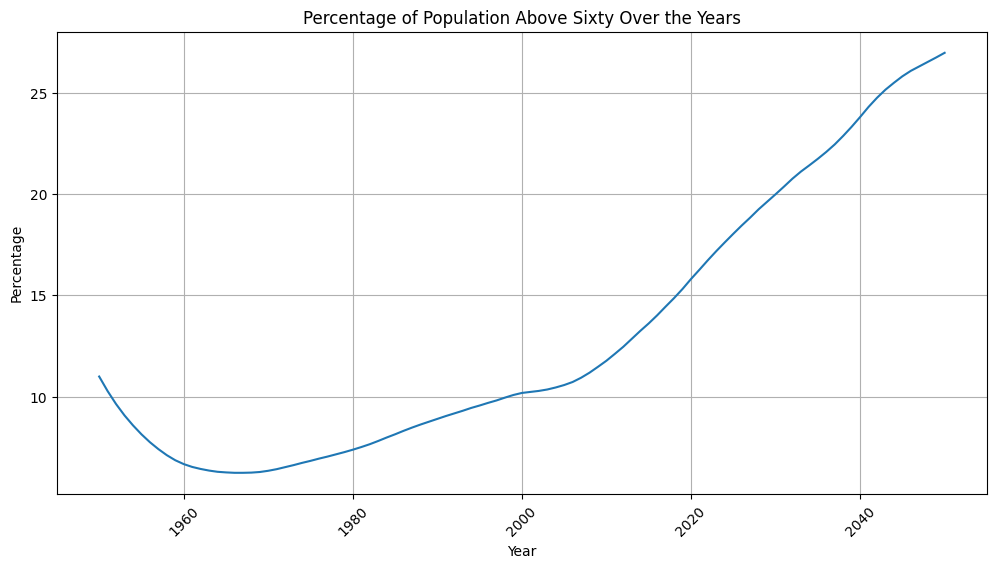

In [82]:
# Convert Spark DataFrame to Pandas DataFrame
percentage_pd_df = percentage_df.toPandas()

# Sort the Pandas DataFrame by 'Year'
percentage_pd_df = percentage_pd_df.sort_values(by='Year')

# Plot the percentage over the years
plt.figure(figsize=(12, 6))
plt.plot(percentage_pd_df['Year'], percentage_pd_df['Percentage'])
plt.title('Percentage of Population Above Sixty Over the Years')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### Percentage of Workforce Over the Years in the Sri_Lanka

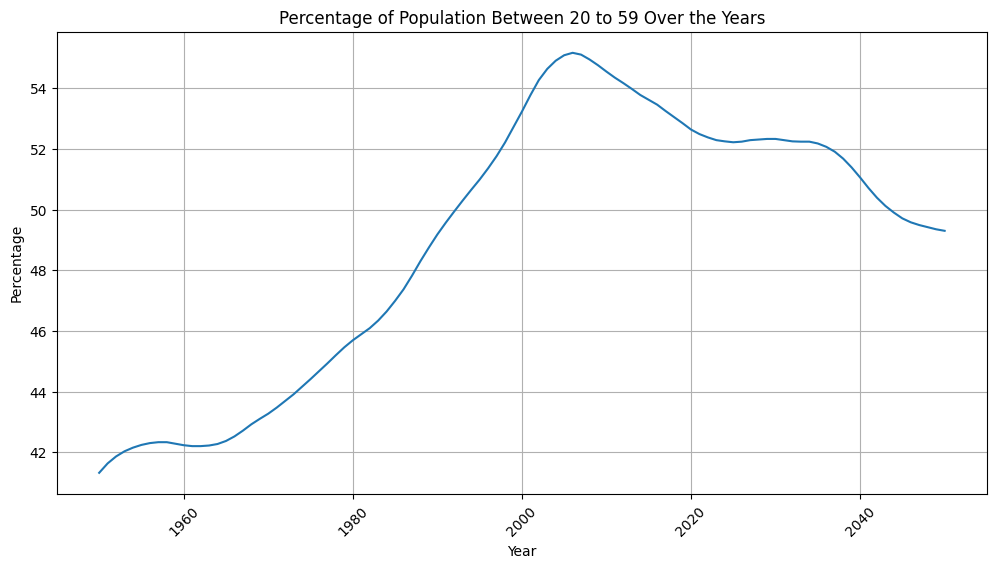

In [83]:
# Filter for AgeClass_Label above 60 and group by year to sum the Absolute value
temp_df = Sri_Lanka_df.filter(Sri_Lanka_df["AgeClass Label"].isin(['[20-24]' , 	'[25-29]' , 	'[30-34]' , 	'[35-39]' , 	'[40-44]' , 	'[45-49]' , 	'[50-54]' , 	'[55-59]'])).groupBy("Year").agg(
    spark_sum("Absolute value in thousands").alias("Value")
)

# Add the new AgeClass_Label
temp_df = temp_df.withColumn("AgeClass Label", lit("Above Sixty"))

# Select columns in the correct order
temp_df = temp_df.select("Year", "AgeClass Label", "Value")

# Combine the original DataFrame with the new rows
Sri_Lanka_sixty_df = Sri_Lanka_df.union(temp_df)

# Filter to include only rows with AgeClass_Label All age classes and Above Sixty
Sri_Lanka_filtered_df = Sri_Lanka_sixty_df.filter(Sri_Lanka_sixty_df["AgeClass Label"].isin('All age classes', 'Above Sixty'))

# Order by year and AgeClass_Label
Sri_Lanka_filtered_df = Sri_Lanka_filtered_df.orderBy("Year", "AgeClass Label")

tt_df = Sri_Lanka_filtered_df.groupBy("Year").pivot("AgeClass Label").sum("Absolute value in thousands")

percentage_df = tt_df.withColumn("Percentage", round((tt_df['Above Sixty'] * 100)/ tt_df['All age classes'], 2))

# Convert Spark DataFrame to Pandas DataFrame
percentage_pd_df = percentage_df.toPandas()

# Sort the Pandas DataFrame by 'Year'
percentage_pd_df = percentage_pd_df.sort_values(by='Year')

# Plot the percentage over the years
plt.figure(figsize=(12, 6))
plt.plot(percentage_pd_df['Year'], percentage_pd_df['Percentage'])
plt.title('Percentage of Population Between 20 to 59 Over the Years')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

### Percentage of Children Over the Years in the Sri_Lanka

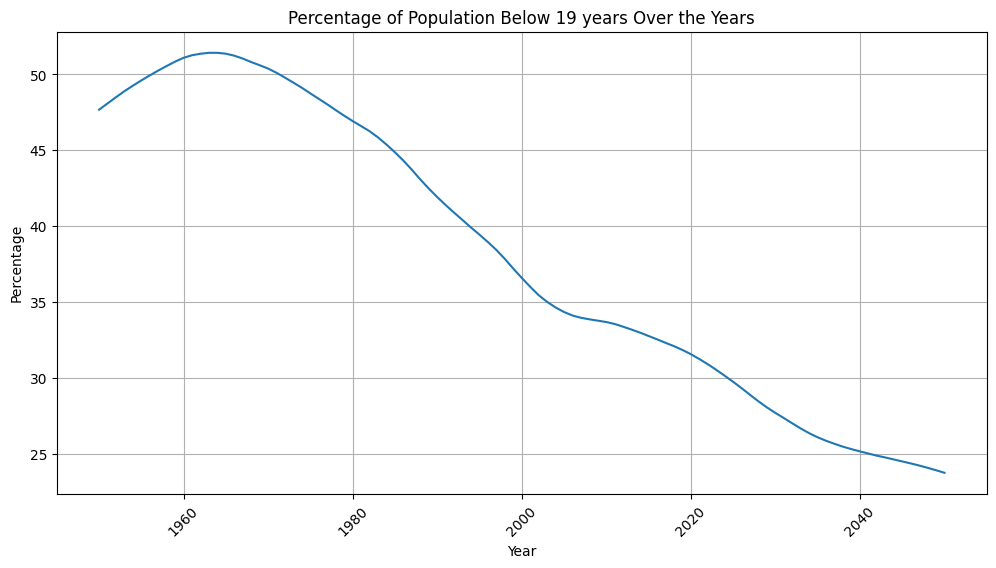

In [84]:
# Filter for AgeClass_Label above 60 and group by year to sum the Absolute value
temp_df = Sri_Lanka_df.filter(Sri_Lanka_df["AgeClass Label"].isin(['[0-4]', '[5-9]', '[10-14]', '[15-19]'])).groupBy("Year").agg(
    spark_sum("Absolute value in thousands").alias("Value")
)

# Add the new AgeClass_Label
temp_df = temp_df.withColumn("AgeClass Label", lit("Above Sixty"))

# Select columns in the correct order
temp_df = temp_df.select("Year", "AgeClass Label", "Value")

# Combine the original DataFrame with the new rows
Sri_Lanka_sixty_df = Sri_Lanka_df.union(temp_df)

# Filter to include only rows with AgeClass_Label All age classes and Above Sixty
Sri_Lanka_filtered_df = Sri_Lanka_sixty_df.filter(Sri_Lanka_sixty_df["AgeClass Label"].isin('All age classes', 'Above Sixty'))

# Order by year and AgeClass_Label
Sri_Lanka_filtered_df = Sri_Lanka_filtered_df.orderBy("Year", "AgeClass Label")

tt_df = Sri_Lanka_filtered_df.groupBy("Year").pivot("AgeClass Label").sum("Absolute value in thousands")

percentage_df = tt_df.withColumn("Percentage", round((tt_df['Above Sixty'] * 100)/ tt_df['All age classes'], 2))

# Convert Spark DataFrame to Pandas DataFrame
percentage_pd_df = percentage_df.toPandas()

# Sort the Pandas DataFrame by 'Year'
percentage_pd_df = percentage_pd_df.sort_values(by='Year')

# Plot the percentage over the years
plt.figure(figsize=(12, 6))
plt.plot(percentage_pd_df['Year'], percentage_pd_df['Percentage'])
plt.title('Percentage of Population Below 19 years Over the Years')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Analysing non-country list

In [85]:
non_countries_df.show(truncate=False)
non_countries_df.describe().show()

+----+-------+--------------+---+----------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|Year|Economy|Economy Label |Sex|Sex Label |AgeClass|AgeClass Label |Absolute value in thousands|Absolute value in thousands Footnote|Absolute value in thousands Missing value|
+----+-------+--------------+---+----------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|1950|16     |American Samoa|0  |Both sexes|0       |All age classes|19.032                     |NULL                                |NULL                                     |
|1950|16     |American Samoa|0  |Both sexes|1       |[0-4]          |3.554                      |NULL                                |NULL                                     |
|1950|16     |American Samoa|0  |Both sexes|2       |[5-9]          |2.886                      |NULL              

In [86]:
non_country_labels = non_countries_temp_df.select("Economy Label").rdd.flatMap(lambda x: x).collect()

In [87]:
print("non_country_labels:", len(non_country_labels))

non_country_labels: 111


In [88]:
# Import SparkContext
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

print(non_country_labels)

rdd = sc.parallelize(non_country_labels)
# Split lines into words and transform into pairs
words_rdd = rdd.flatMap(lambda line: line.split(" "))
pairs_rdd = words_rdd.map(lambda word: (word, 1))

# Reduce by key to count each word
word_counts_rdd = pairs_rdd.reduceByKey(lambda a, b: a + b)

# Collect results and print
results = word_counts_rdd.collect()
for word, count in results:
    print(f"{word}: {count}")

['Southern Africa', 'Developed economies: Oceania', 'Saint Helena', 'British Virgin Islands', 'Pacific Islands, Trust Territory', 'Anguilla', 'BRICS', 'Puerto Rico', 'Yugoslavia, Soc. Fed. Rep. of', 'LDCs: Asia', 'Switzerland, Liechtenstein', 'Sub-Saharan Africa', 'Eastern and South-Eastern Asia', 'Developing economies excluding LDCs', 'Eastern Asia', 'United States Virgin Islands', 'Central America', 'Developing economies: Asia', 'Developing economies', 'Europe, Northern America, Australia and New Zealand', 'G20 (Group of Twenty)', 'Caribbean', 'Low-income developing economies', 'Eastern Europe', 'Falkland Islands (Malvinas)', 'Developed economies: Europe', 'Latin America and the Caribbean', 'Developed economies: Asia', 'Oceania', 'Developed economies', 'Western Asia and Northern Africa', 'OECD (Organisation for Economic Cooperation and Development)', 'European Union (2020 …)', 'Cayman Islands', 'High-income developing economies', 'LDCs: Africa', 'Panama, excluding Canal Zone', 'Réuni

In [89]:
# Select the Economy Labels from the DataFrame and collect them into a list
non_country_labels = non_countries_temp_df.select("Economy Label").rdd.flatMap(lambda x: x).collect()

# Filter entries containing specific keywords into separate lists (case insensitive)
developed_list = [label for label in non_country_labels if 'developed' in label.lower()]
developing_list = [label for label in non_country_labels if 'developing' in label.lower()]
islands_list = [label for label in non_country_labels if 'islands' in label.lower()]

# Get the remaining entries
remaining_list = [label for label in non_country_labels if 'developed' not in label.lower() and 'developing' not in label.lower() and 'islands' not in label.lower()]

# Print the lists
print("Developed Entries:")
for entry in developed_list:
    print(entry)

print("\nDeveloping Entries:")
for entry in developing_list:
    print(entry)

print("\nIslands Entries:")
for entry in islands_list:
    print(entry)

print("\nRemaining Entries:")
for entry in remaining_list:
    print(entry)

print(f"\nTotal number of remaining entries: {len(remaining_list)}")


Developed Entries:
Developed economies: Oceania
Developed economies: Europe
Developed economies: Asia
Developed economies
Developed economies: Americas
LDCs (Least developed countries)
Developed economies: Asia and Oceania

Developing Entries:
Developing economies excluding LDCs
Developing economies: Asia
Developing economies
Low-income developing economies
High-income developing economies
LLDCs (Landlocked developing countries)
Developing economies: Oceania
Developing economies: Americas
Developing economies excluding China
SIDS (Small island developing States) (UN-OHRLLS)
Developing economies: Asia and Oceania
Developing economies: Africa
Middle-income developing economies

Islands Entries:
British Virgin Islands
Pacific Islands, Trust Territory
United States Virgin Islands
Falkland Islands (Malvinas)
Cayman Islands
LDCs: Islands and Haiti
Channel Islands
Wallis and Futuna Islands
Faroe Islands
Cook Islands
United Kingdom excl. Channel Islands and Isle of Man
United States of America

# Predicting total population using Linear Regression

In [90]:
#Selecting total population up to 2021 by year
df_total_world_population_upto_2021 = df_cleaned.filter((df_cleaned['Economy Label'] == 'World') & (df_cleaned['AgeClass Label'] == 'All age classes')
                                  & (df_cleaned['Sex Label'] == 'Both sexes') & (df_cleaned['Year'] < '2022'))
df_total_world_population_upto_2021 = df_total_world_population_upto_2021['Year','Absolute value in thousands']

In [91]:
from pyspark.ml.feature import VectorAssembler

# Prepare the data for ML model
assembler= VectorAssembler(inputCols =['Year'], outputCol="features")

temp_df = assembler.transform(df_total_world_population_upto_2021)

assembled_df = temp_df.select(["features", col("Absolute value in thousands").alias("population")])
assembled_df.show(5)

# Split the data into training and test sets
training_df, test_df = assembled_df.randomSplit([0.7,0.3], seed=42)
print("training data: ", training_df.count(), ", test data: ", test_df.count() )

+--------+-----------+
|features| population|
+--------+-----------+
|[1950.0]|2499322.166|
|[1951.0]|2543130.378|
|[1952.0]|2590270.906|
|[1953.0]|2640278.794|
|[1954.0]|2691979.337|
+--------+-----------+
only showing top 5 rows

training data:  40 , test data:  32


In [92]:
from pyspark.ml.regression import LinearRegression

# Build and train the model
lr_model = LinearRegression(labelCol="population").fit(training_df)
#predictions = lr_model.transform(test_df)

# Evaluate the model
predictions = lr_model.transform(test_df)
predictions.orderBy("features").show(5)

+--------+-----------+------------------+
|features| population|        prediction|
+--------+-----------+------------------+
|[1952.0]|2590270.906|2388113.6450195312|
|[1956.0]|2801002.636|2702582.0026237667|
|[1958.0]|2916108.105|2859816.1814258695|
|[1959.0]| 2970292.19| 2938433.270826936|
|[1963.0]|3195779.257| 3252901.628431171|
+--------+-----------+------------------+
only showing top 5 rows



+----+-----------------+
|Year|       prediction|
+----+-----------------+
|2022|7891309.903093487|
|2023|7969926.992494553|
|2024| 8048544.08189562|
|2025|8127161.171296656|
|2026|8205778.260697722|
+----+-----------------+
only showing top 5 rows

+----+-------+-------------+---+----------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|Year|Economy|Economy Label|Sex| Sex Label|AgeClass| AgeClass Label|Absolute value in thousands|Absolute value in thousands Footnote|Absolute value in thousands Missing value|
+----+-------+-------------+---+----------+--------+---------------+---------------------------+------------------------------------+-----------------------------------------+
|2022|      0|        World|  0|Both sexes|       0|All age classes|                7975105.157|                                NULL|                                     NULL|
|2023|      0|        World|  0|Both sexes|   

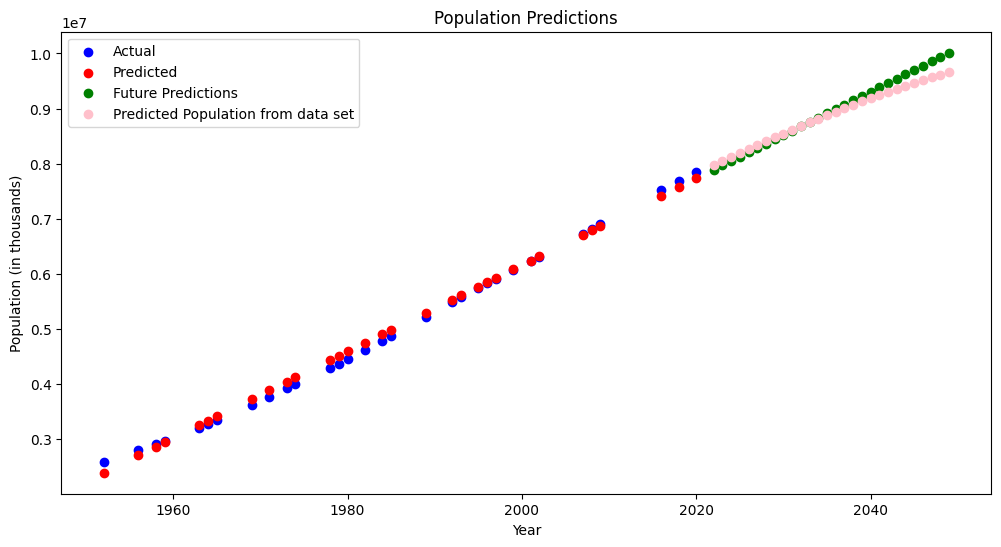

In [93]:
# Create a DataFrame for future years (2024 to 2050)
future_years_df = spark.createDataFrame([(year,) for year in range(2022, 2050)], ["Year"])

# Transform future years using the same assemble
assembled_future_years_df = assembler.transform(future_years_df)

# Make predictions for future years
future_predictions = lr_model.transform(assembled_future_years_df)
future_predictions = future_predictions.select("Year", "prediction")
future_predictions.show(5)

# Collecting data for visualization
predictions_df = predictions.select("features", "population", "prediction").toPandas()
future_predictions_df = future_predictions.toPandas()
datset_future = df_cleaned.filter(
    (col('Economy Label') == 'World') &
    (col('AgeClass Label') == 'All age classes') &
    (col('Sex Label') == 'Both sexes') &
    (col('Year') > 2021) &
    (col('Year') < 2050)
)
datset_future.show(5)
datset_future_df = datset_future.toPandas()

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.scatter(predictions_df["features"].apply(lambda x: x[0]), predictions_df["population"], color='blue', label='Actual')
plt.scatter(predictions_df["features"].apply(lambda x: x[0]), predictions_df["prediction"], color='red', label='Predicted')
plt.scatter(future_predictions_df["Year"], future_predictions_df["prediction"], color='green', label='Future Predictions')
plt.scatter(datset_future_df["Year"], datset_future_df["Absolute value in thousands"], color='pink', label='Predicted Population from data set')
plt.xlabel("Year")
plt.ylabel("Population (in thousands)")
plt.legend()
plt.title("Population Predictions")
plt.show()




In [110]:
evaluator = RegressionEvaluator(labelCol="population", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")

Root Mean Squared Error (RMSE) on test data: 92813.89606622588
